In [96]:
import os
import sys
sys.path.insert(0, '../scripts')
from l5kit_modified.l5kit_modified import AgentDatasetModified
from kalman import KalmanTrackerPredictor
from lane_follower import ConstantSpeedLaneFollower
import pickle
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, create_chopped_dataset
from l5kit.evaluation.metrics import neg_multi_log_likelihood
from l5kit.data import LocalDataManager, ChunkedDataset
from pathlib import Path
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
    
os.environ["L5KIT_DATA_FOLDER"] = "../input/"

In [8]:
with open('../output/experiment__20200830-174752/best_parameters_400.23820122613597.pkl', 'rb') as f:
    kalman_params = pickle.load(f)

In [9]:
FILTER_AGENTS_THRESHOLD = 0.5
NUM_FRAMES_TO_CHOP = 100
FUTURE_NUM_FRAMES = 50
MIN_FUTURE_STEPS = 10
BATCH_SIZE = 256
dataset_path = 'scenes/validate.zarr'
# dataset_path = 'scenes/test.zarr'
# eval_mask = np.load(os.path.join(f"{os.environ['L5KIT_DATA_FOLDER']}",
#                                          "scenes/mask.npz"))["arr_0"]
# eval_zarr = ChunkedDataset(dm.require(dataset_path)).open()

dm = LocalDataManager(None)
eval_base_path = create_chopped_dataset(dm.require(dataset_path),
                                                     FILTER_AGENTS_THRESHOLD,
                                                     NUM_FRAMES_TO_CHOP,
                                                     FUTURE_NUM_FRAMES,
                                                     MIN_FUTURE_STEPS)
eval_gt_path = os.path.join(eval_base_path, 'gt.csv')

eval_zarr_path = str(Path(eval_base_path) / Path(dm.require(dataset_path)).name)
eval_mask_path = str(Path(eval_base_path) / "mask.npz")
eval_mask = np.load(eval_mask_path)["arr_0"]
eval_zarr = ChunkedDataset(eval_zarr_path).open()



cfg = {"model_params": {"history_num_frames": kalman_params["history_num_frames"],
                                    "history_step_size": kalman_params["history_step_size"],
                                    "future_num_frames": FUTURE_NUM_FRAMES,
                                    "future_step_size": 1},
                   "raster_params": {"filter_agents_threshold": FILTER_AGENTS_THRESHOLD}}

del kalman_params['history_num_frames']
del kalman_params['history_step_size']

copying: 100%|██████████| 16220/16220 [04:58<00:00, 54.27it/s]


warning, you're running with a custom agents_mask


extracting GT: 100%|██████████| 94694/94694 [10:22<00:00, 152.15it/s]


In [28]:
dataset = AgentDatasetModified(cfg, eval_zarr, agents_mask=eval_mask)
dataloader = DataLoader(dataset, shuffle=False, batch_size=256,
                        num_workers=10,
                        collate_fn=lambda x: x)

warning, you're running with a custom agents_mask


In [30]:
debug = True

In [159]:
from multiprocessing import Pool
from tqdm.auto import tqdm
from functools import partial

lane_follower = ConstantSpeedLaneFollower()

def compute_track_predictions(batch_i, data, params):
    timestamp = data[batch_i]['timestamp']
    agent_id = data[batch_i]['track_id']
    if data[batch_i]['label_probabilities'][-3] >= 0.9:
        # pedestrian
        history_measurements = data[batch_i]['history_positions']
        params.update({'fps': 10})
        kalman_tracker_predictor = KalmanTrackerPredictor(**params)
        kalman_tracker_predictor.process_history(history_measurements, data[batch_i]['history_availabilities'])
        future_coords_offsets = kalman_tracker_predictor.predict_future_positions(multi_mode=True)
        confidences = np.array([1, 0, 0])
        return future_coords_offsets, timestamp, agent_id, confidences
    else:
        start_speed = -data[batch_i]['history_positions'][1]
        start_coordinates = data[batch_i]['centroid']
        future_coordinates_tracks = lane_follower.get_prediction(start_coordinates, start_speed)
        future_coords_offsets = future_coordinates_tracks - start_coordinates
        if len(future_coords_offsets[0]) < 3:
            temp = future_coords_offsets[0]
            while len(temp) < 3:
                temp = np.concatenate((temp, np.expand_dims(temp[-1], 0)))
            future_coords_offsets = np.expand_dims(temp, 0)
        confidences = np.array([1/3, 1/3, 1/3])
        return future_coords_offsets, timestamp, agent_id, confidences
        
        

future_coords_offsets = []
timestamps = []
agent_ids = []
confidences = []
        
for data in tqdm(dataloader, desc='Iterating over data...'):
    compute_track_predictions_partial = partial(compute_track_predictions,
                                                data=data,
                                                params=kalman_params)
    if debug:
        results_list = [compute_track_predictions_partial(batch_i) for batch_i in range(len(data))]
    else:
        pool = Pool(26)
        with pool as p:
            results_list = p.map(compute_track_predictions_partial, list(range(len(data))))
        pool.join()
    future_coords_batch = list(map(lambda x: x[0], results_list))
    timestamps_batch = list(map(lambda x: x[1], results_list))
    agent_ids_batch = list(map(lambda x: x[2], results_list))
    confidences_batch = list(map(lambda x: x[3], results_list))
    future_coords_offsets.extend(future_coords_batch)
    timestamps.extend(timestamps_batch)
    agent_ids.extend(agent_ids_batch)
    confidences.extend(confidences_batch)

pred_path_temp = 'submission.csv'
write_pred_csv(pred_path_temp,
               timestamps=np.array(timestamps),
               track_ids=np.array(agent_ids),
               coords=np.concatenate(future_coords_offsets),
               confs=np.stack(confidences)
               )

In [160]:
metrics = compute_metrics_csv(eval_gt_path, pred_path_temp, [neg_multi_log_likelihood])
metrics

{'neg_multi_log_likelihood': 654.6884989300274}

In [161]:
from collections import OrderedDict, defaultdict
from typing import Callable, List

import numpy as np

from l5kit.evaluation.csv_utils import read_gt_csv, read_pred_csv

def check_the_worst_predictions(ground_truth_path: str, inference_output_path: str, metric: Callable):

    ground_truth = OrderedDict()
    inference = OrderedDict()

    shown = False
    for el in read_gt_csv(ground_truth_path):
        if not shown:
            shown = True
            print(el.keys())
        ground_truth[(el["track_id"], el["timestamp"])] = el
    for el in read_pred_csv(inference_output_path):
        inference[(el["track_id"], el["timestamp"])] = el

    
    metric_pred_gt_list = []

    for key, ground_truth_value in tqdm(ground_truth.items()):
        gt_coord = ground_truth_value["coord"]
        avail = ground_truth_value["avail"]

        pred_coords = inference[key]["coords"]
        conf = inference[key]["conf"]
        metric_val = metric(gt_coord, pred_coords, conf, avail)
        metric_pred_gt_list.append((metric_val, pred_coords, gt_coord, avail, conf, key))
            
    return metric_pred_gt_list

metric_pred_gt_list = check_the_worst_predictions(eval_gt_path, pred_path_temp, neg_multi_log_likelihood)

dict_keys(['track_id', 'timestamp', 'coord', 'avail'])


<AxesSubplot:>

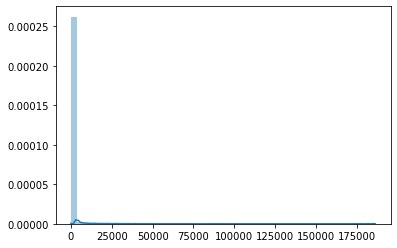

In [162]:
metric_vals = [x[0] for x in metric_pred_gt_list]
sns.distplot(metric_vals)

In [163]:
metric_pred_gt_list_sorted = sorted(metric_pred_gt_list, key=lambda x: x[0])

In [164]:
len(metric_pred_gt_list_sorted)

94694

In [166]:
np.mean([x[0] for x in metric_pred_gt_list_sorted[:90000]])

146.71630306177858

In [167]:
i = 1
metric_pred_gt_list_sorted[-i][0]

186239.3649191349

('9', '1581352327102628306')
('9', '1581352327102628306')
('9', '1581352327102628306')
('10', '1579730178802495956')
('10', '1579730178802495956')
('10', '1579730178802495956')
('6', '1577125997802477276')
('6', '1577125997802477276')
('6', '1577125997802477276')
('191', '1578441079702131836')
('191', '1578441079702131836')
('191', '1578441079702131836')
('22', '1579732678202339836')
('22', '1579732678202339836')
('22', '1579732678202339836')
('628', '1582572572402578956')
('628', '1582572572402578956')
('628', '1582572572402578956')
('462', '1579803648002728156')
('462', '1579803648002728156')
('462', '1579803648002728156')
('14', '1576617524302951746')
('14', '1576617524302951746')
('14', '1576617524302951746')
('9', '1579905250402823166')
('9', '1579905250402823166')
('9', '1579905250402823166')
('174', '1580246914502724246')


/home/raman/anaconda3/envs/trajectory/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


('174', '1580246914502724246')
('174', '1580246914502724246')
('243', '1579905325403372166')
('243', '1579905325403372166')
('243', '1579905325403372166')
('305', '1576264014801899306')
('305', '1576264014801899306')
('305', '1576264014801899306')
('3', '1580166601402327254')
('3', '1580166601402327254')
('3', '1580166601402327254')
('10', '1576184308002133694')
('10', '1576184308002133694')
('10', '1576184308002133694')
('528', '1581547565202791486')
('528', '1581547565202791486')
('528', '1581547565202791486')
('286', '1581543829602557426')
('286', '1581543829602557426')
('286', '1581543829602557426')
('2', '1580333116502682246')
('2', '1580333116502682246')
('2', '1580333116502682246')
('9', '1583350437102614186')
('9', '1583350437102614186')
('9', '1583350437102614186')
('6', '1579126395302890986')
('6', '1579126395302890986')
('6', '1579126395302890986')
('342', '1577728187702851926')
('342', '1577728187702851926')
('342', '1577728187702851926')


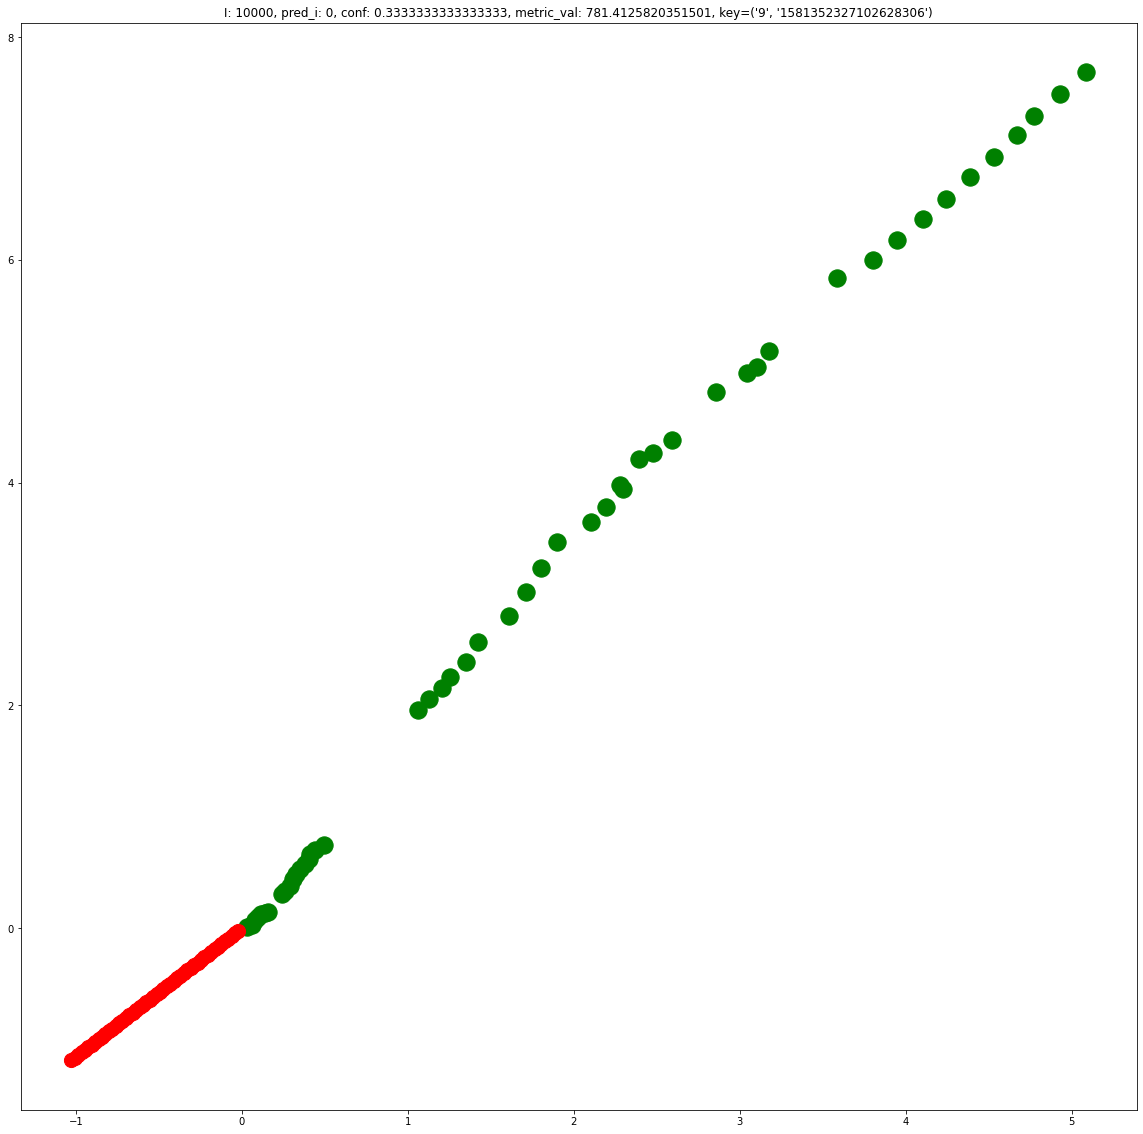

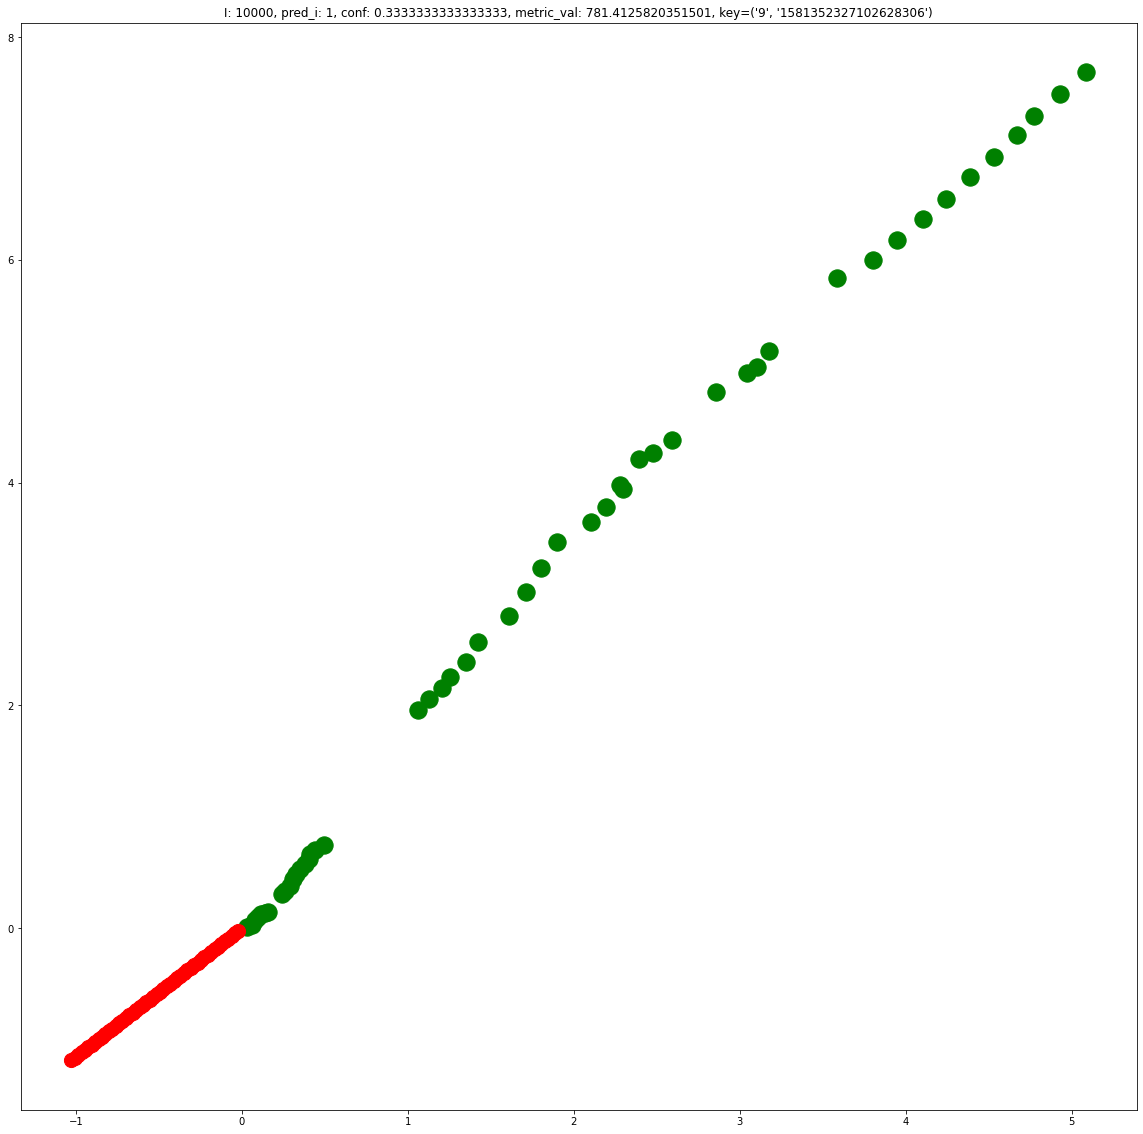

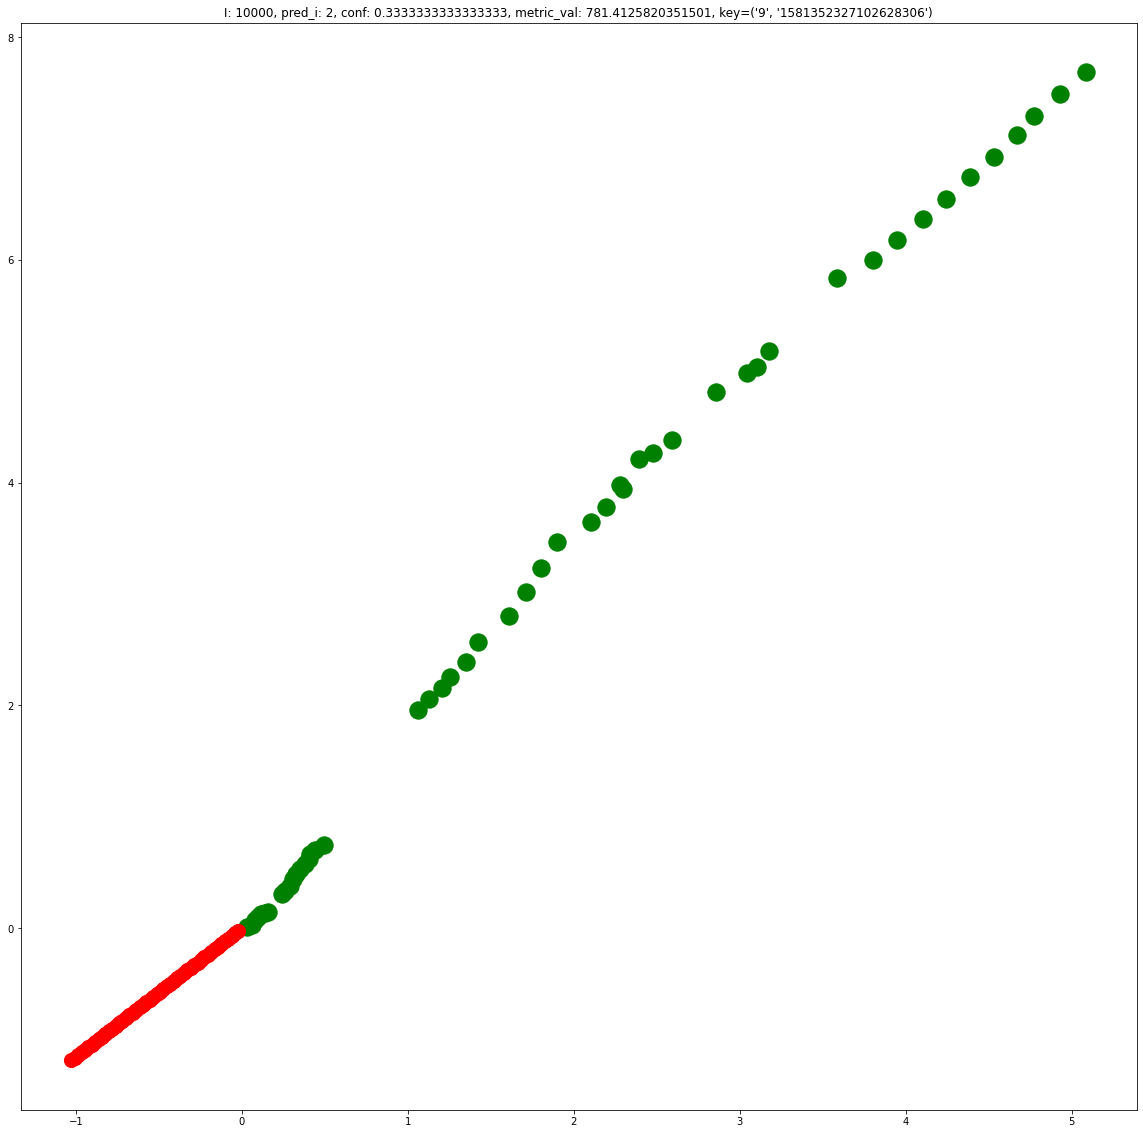

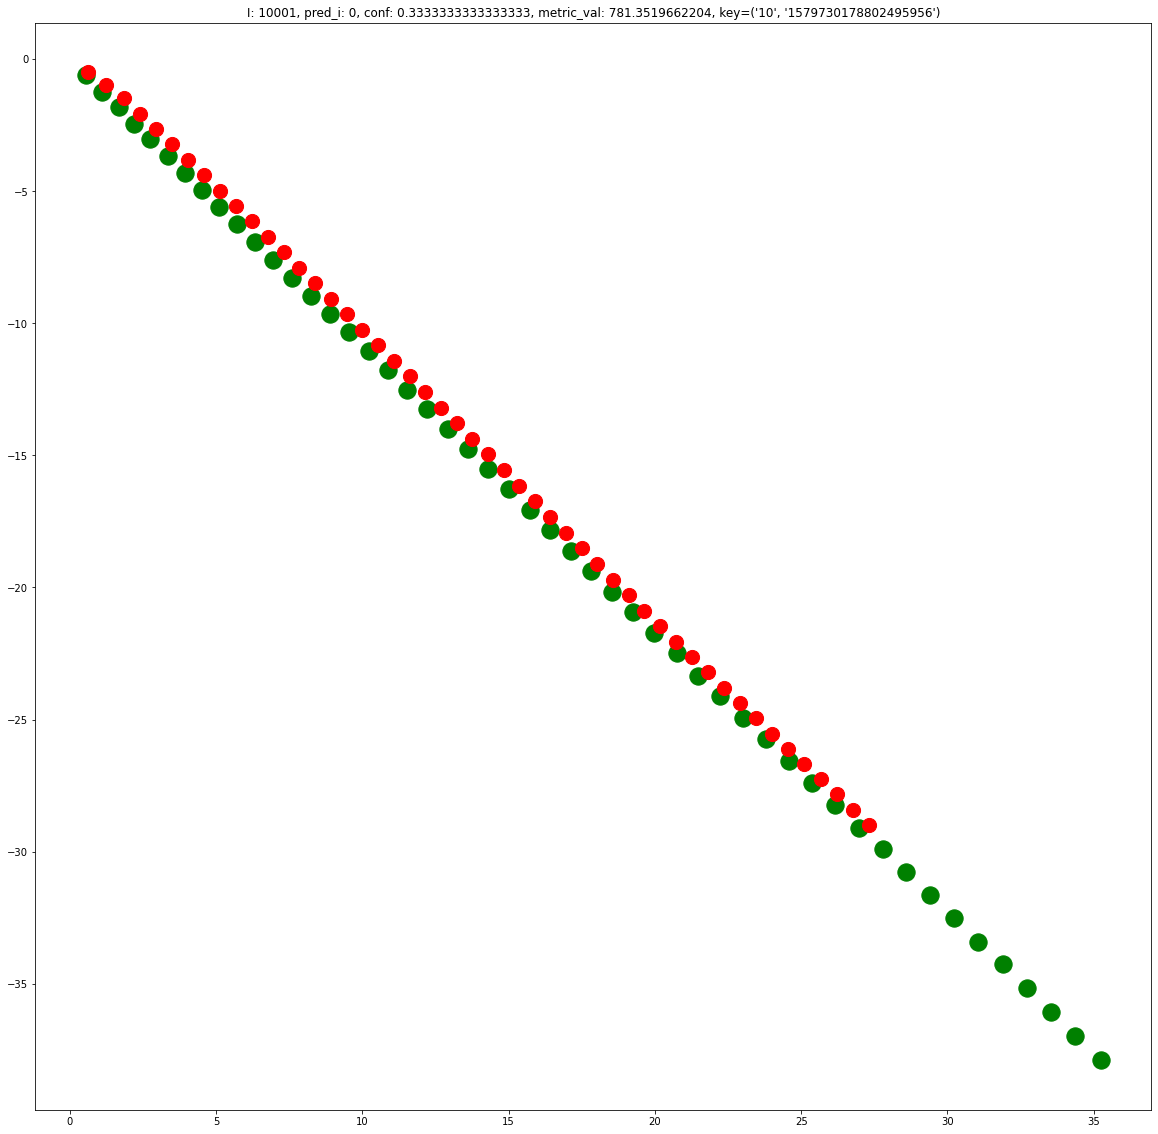

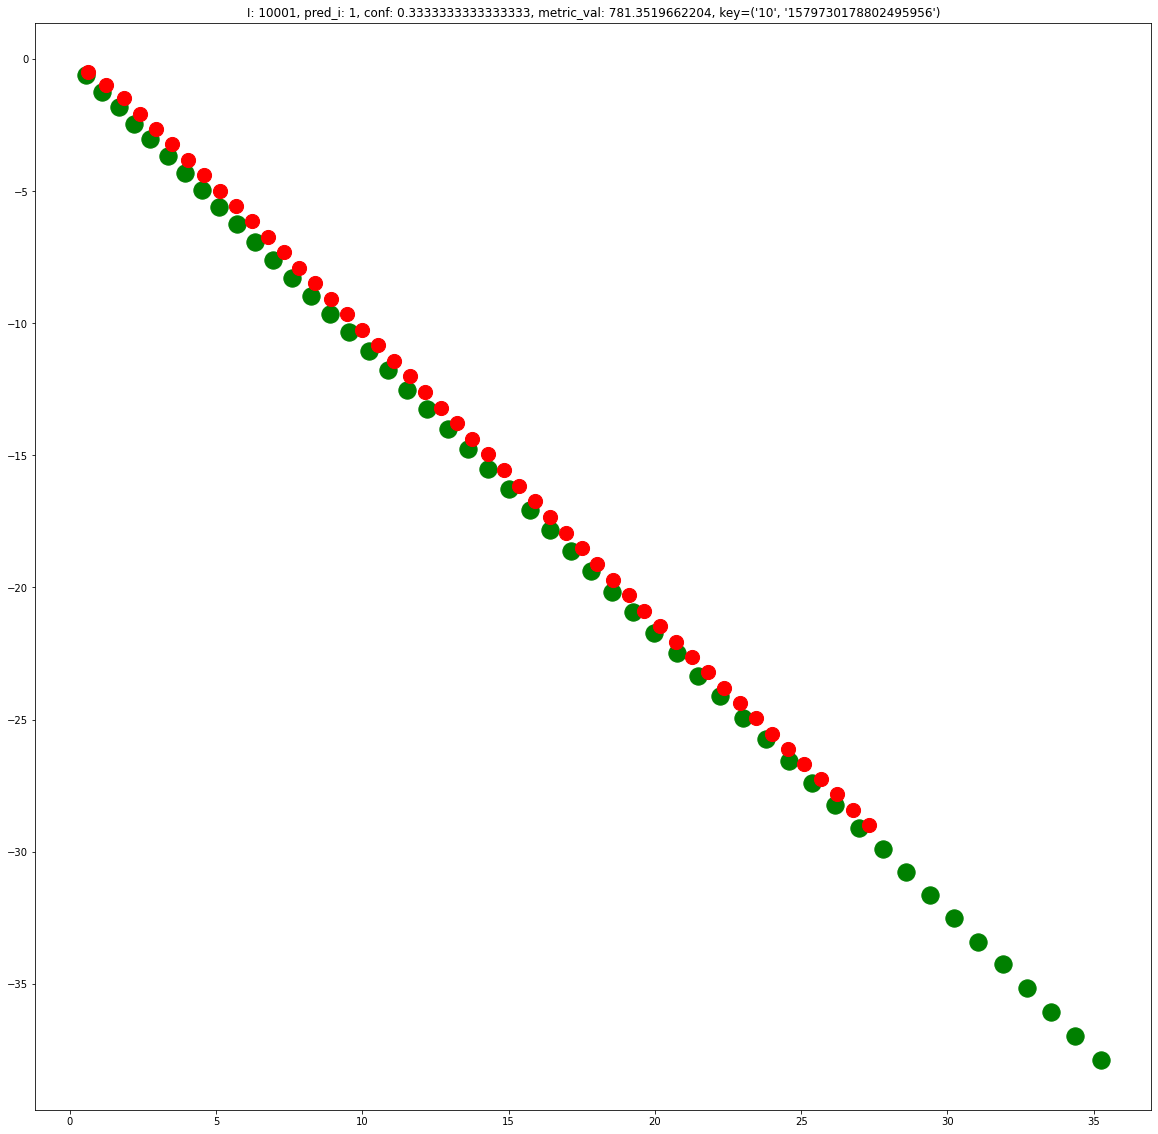

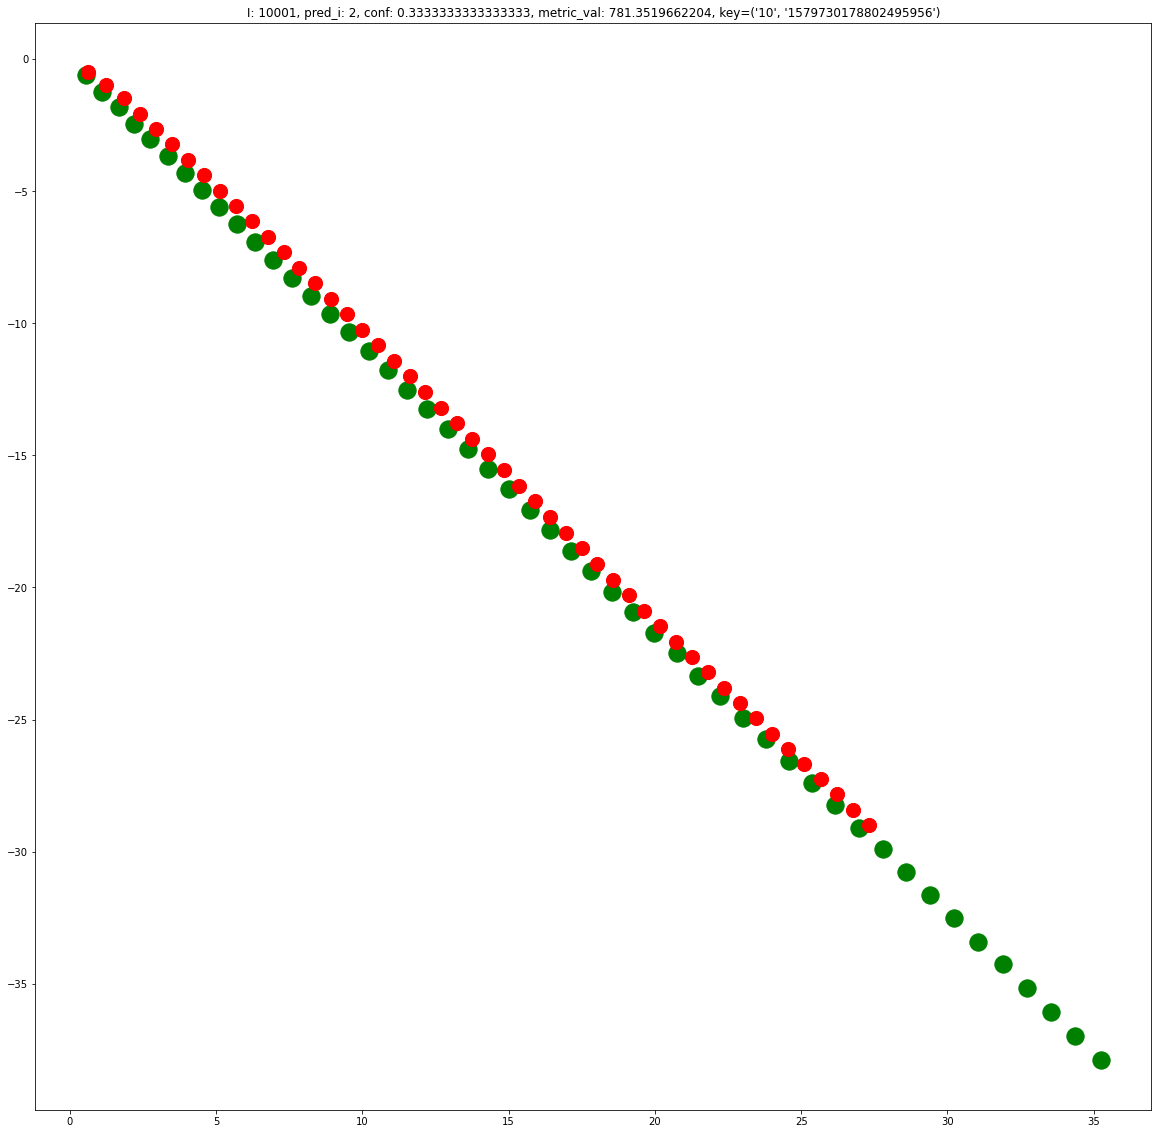

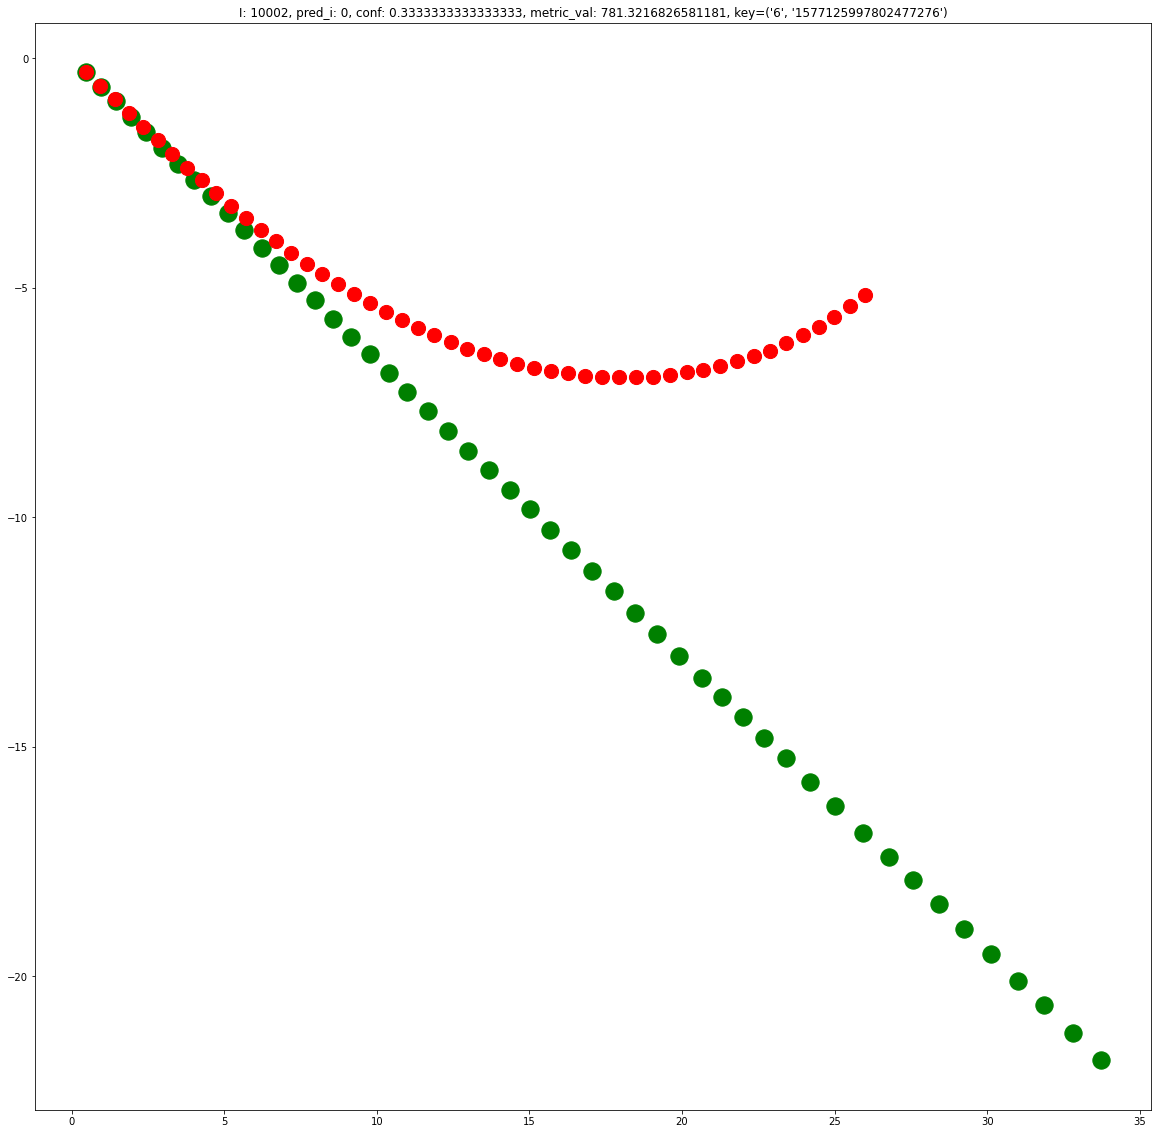

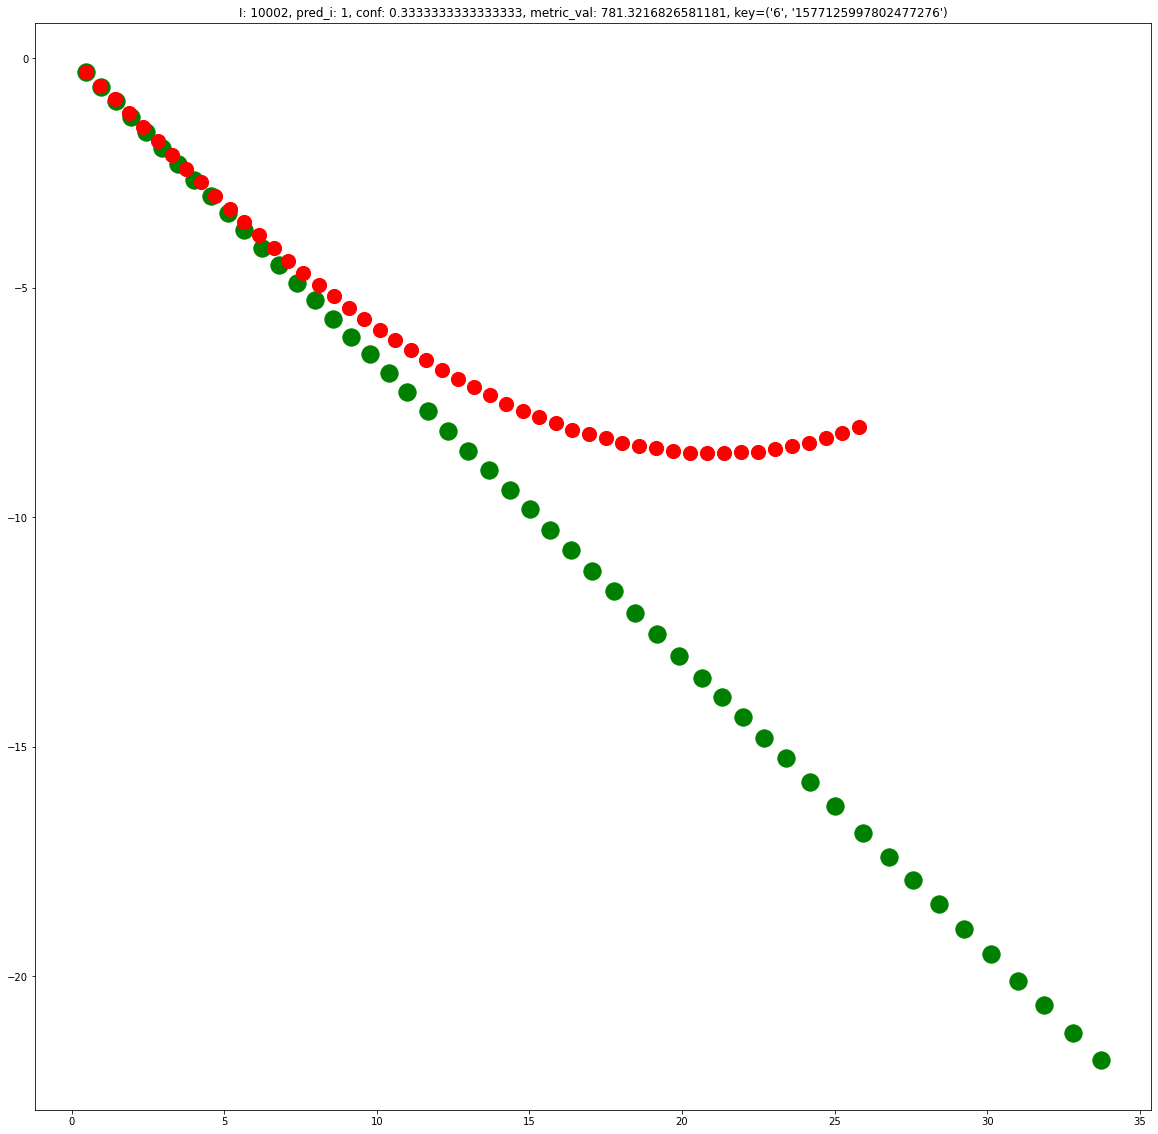

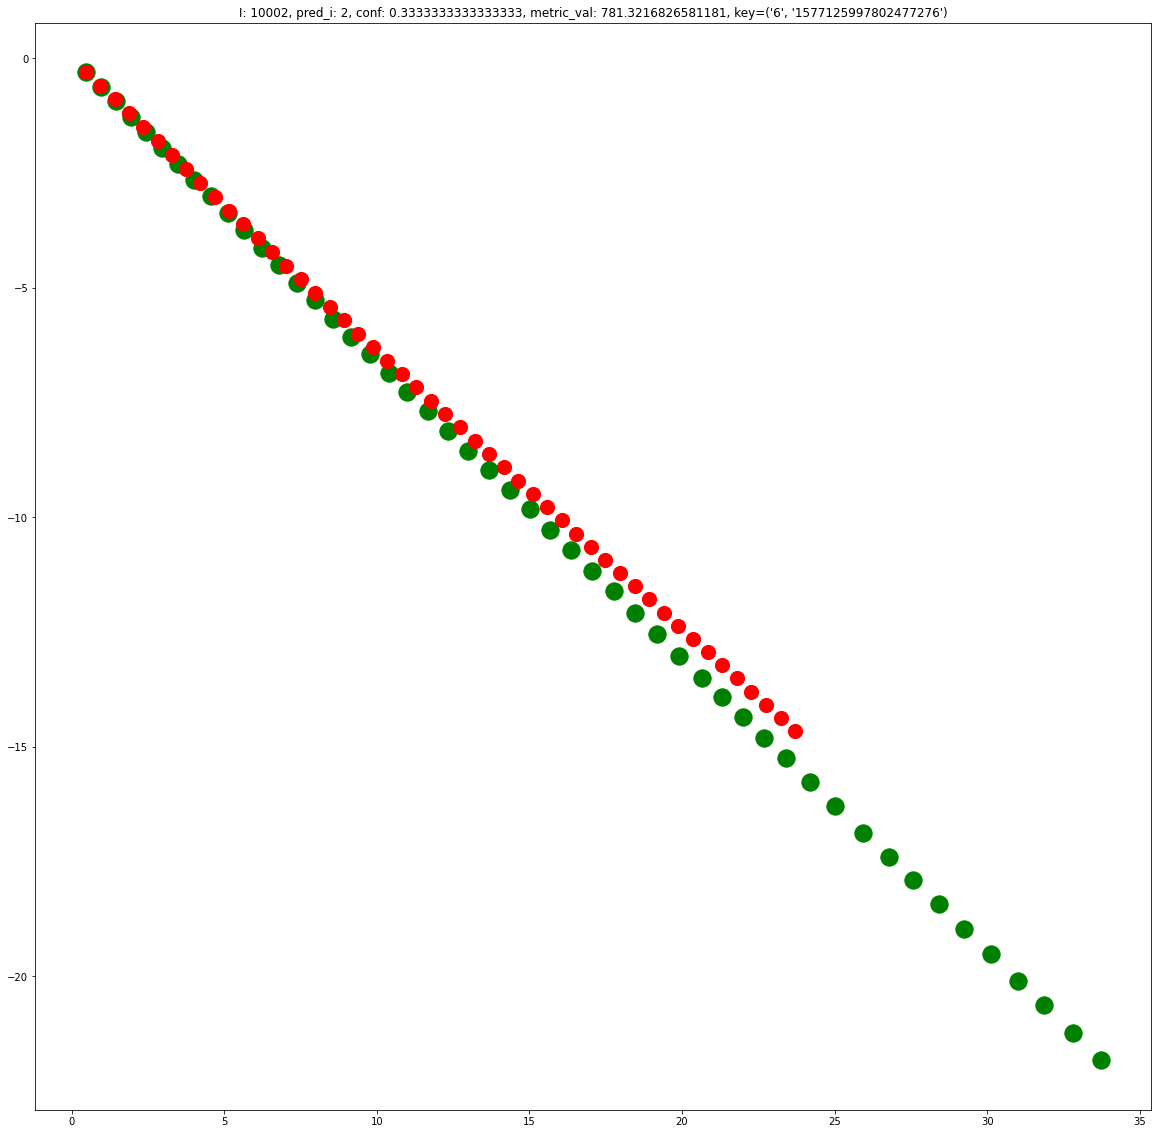

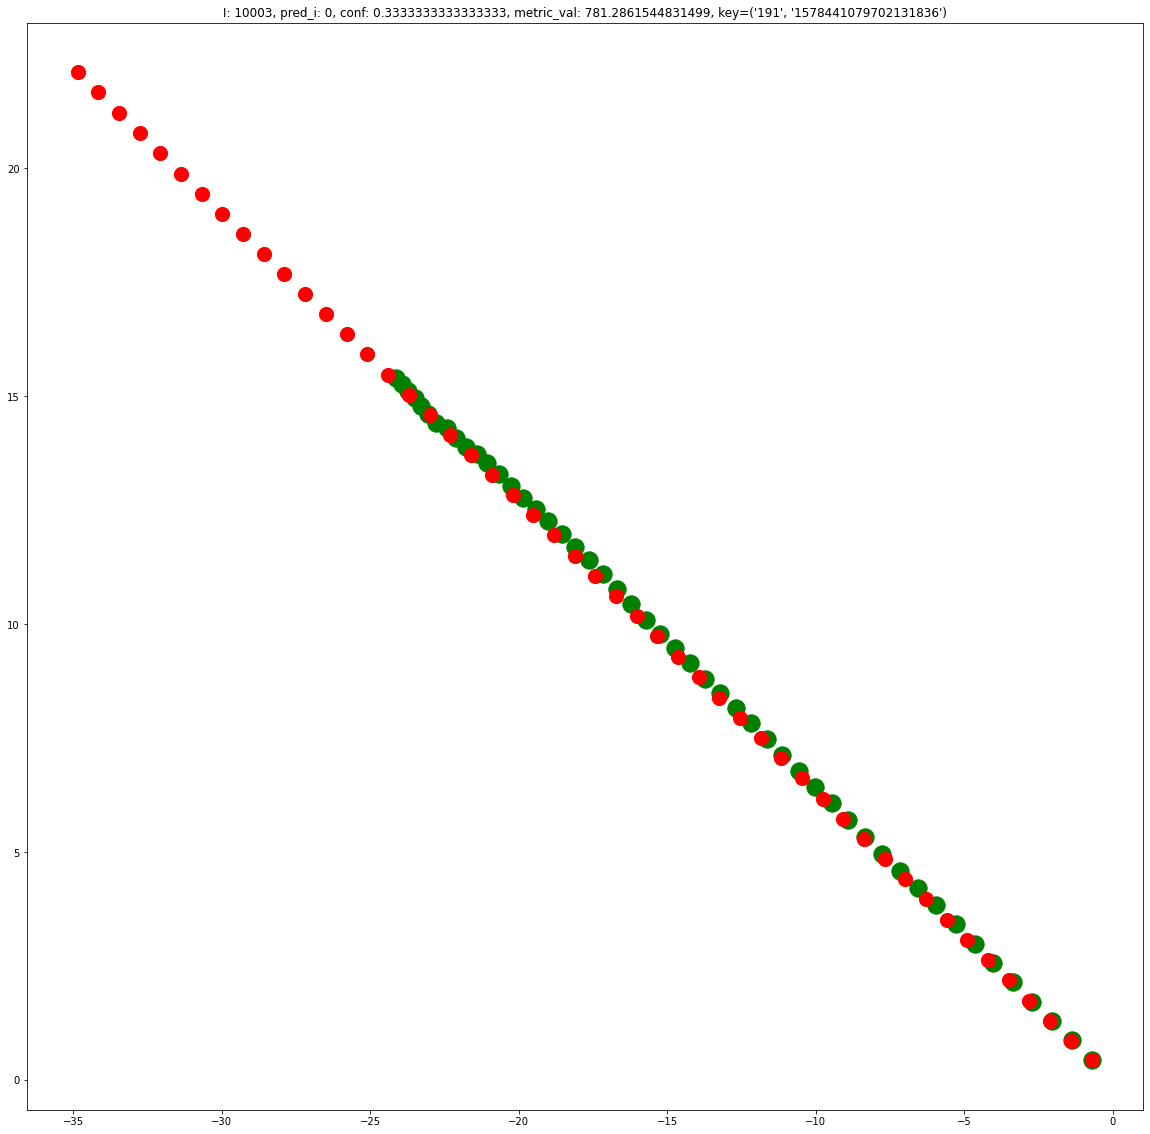

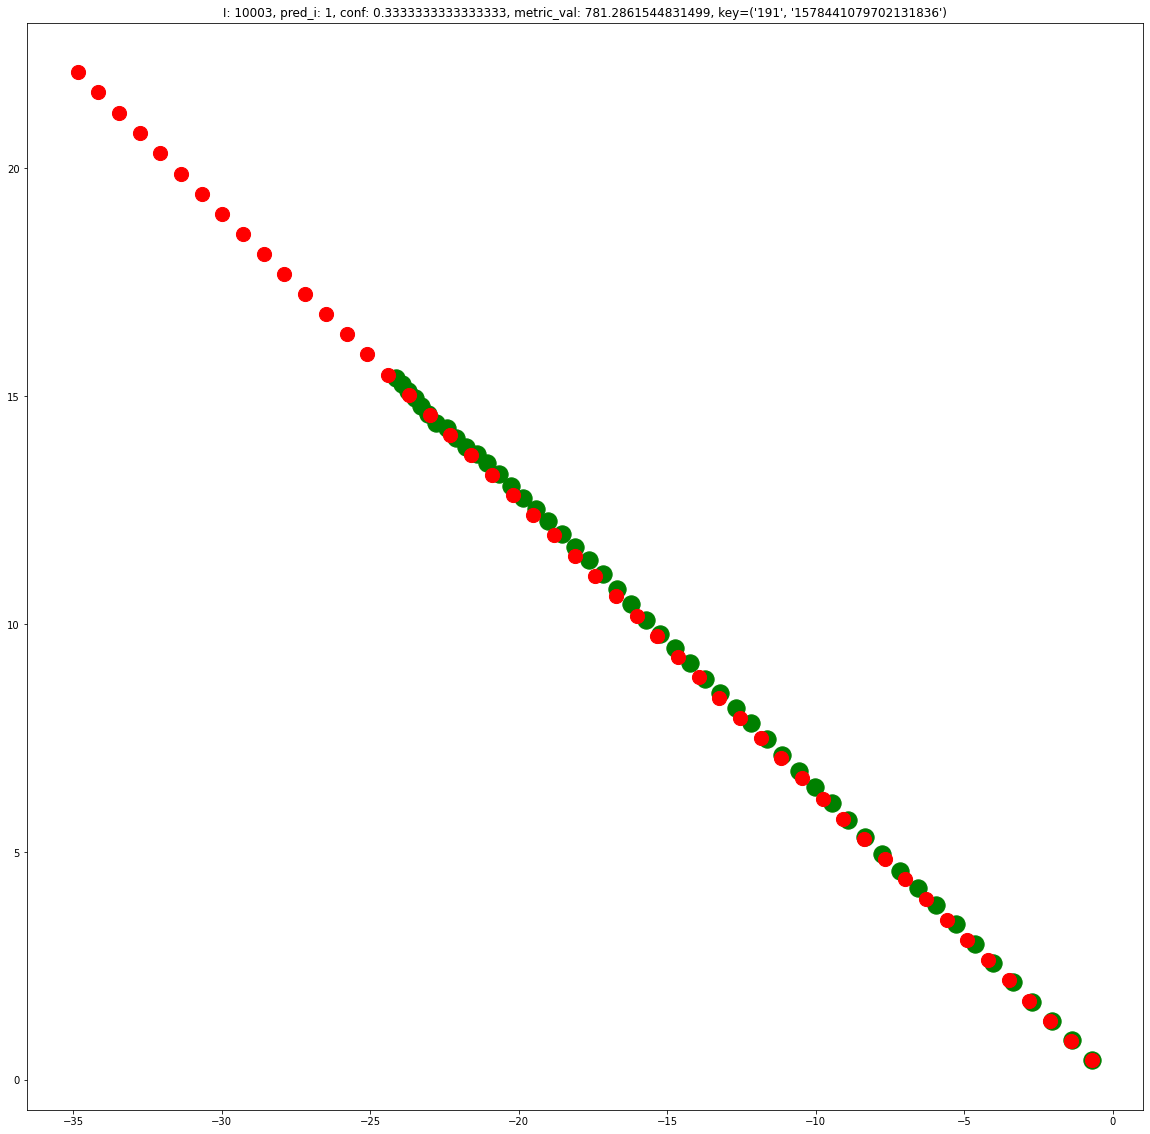

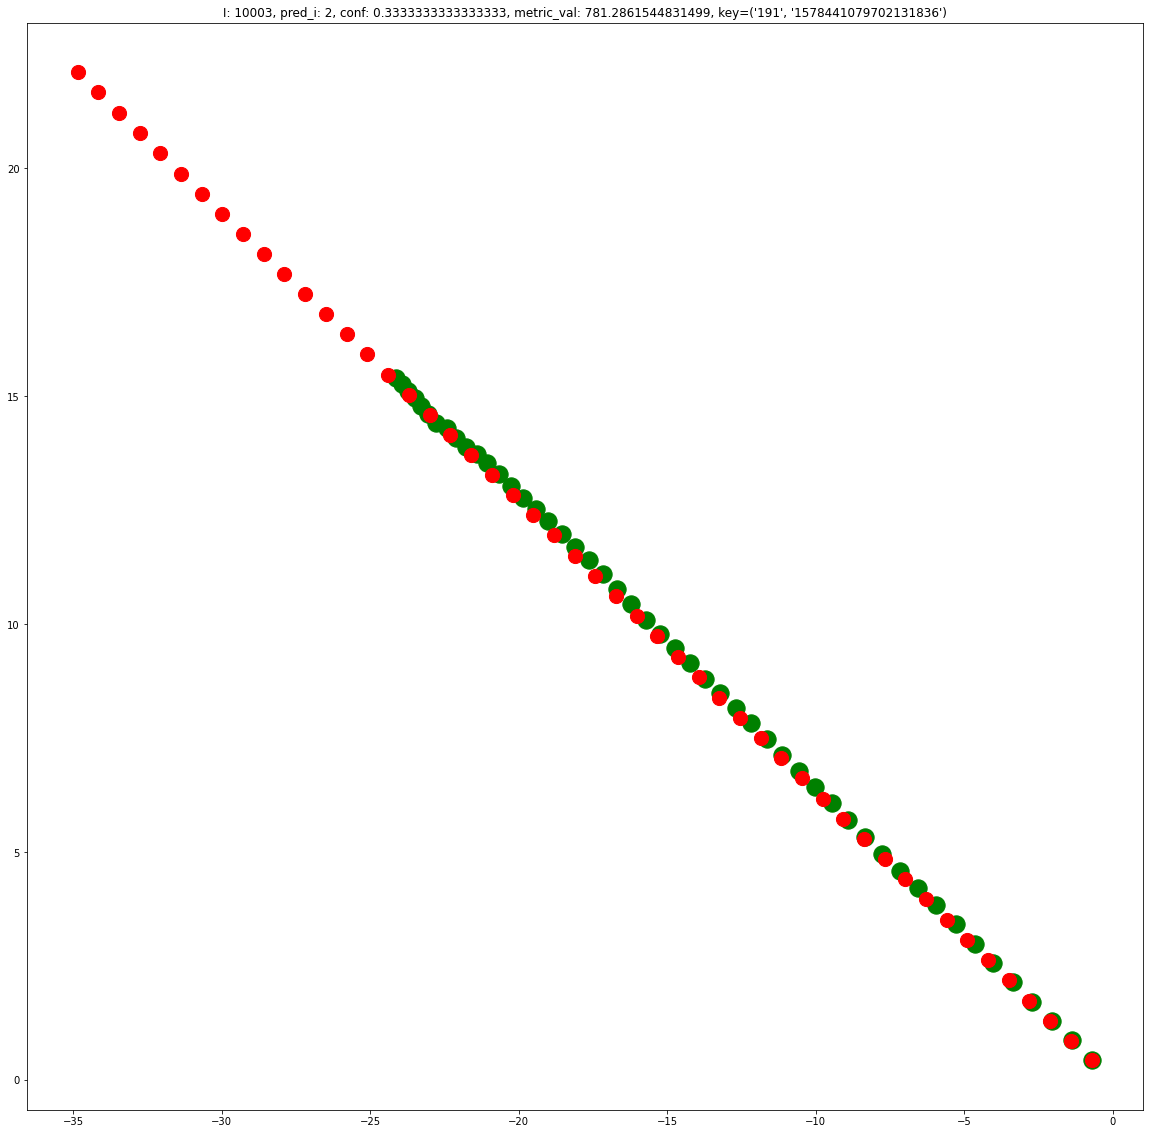

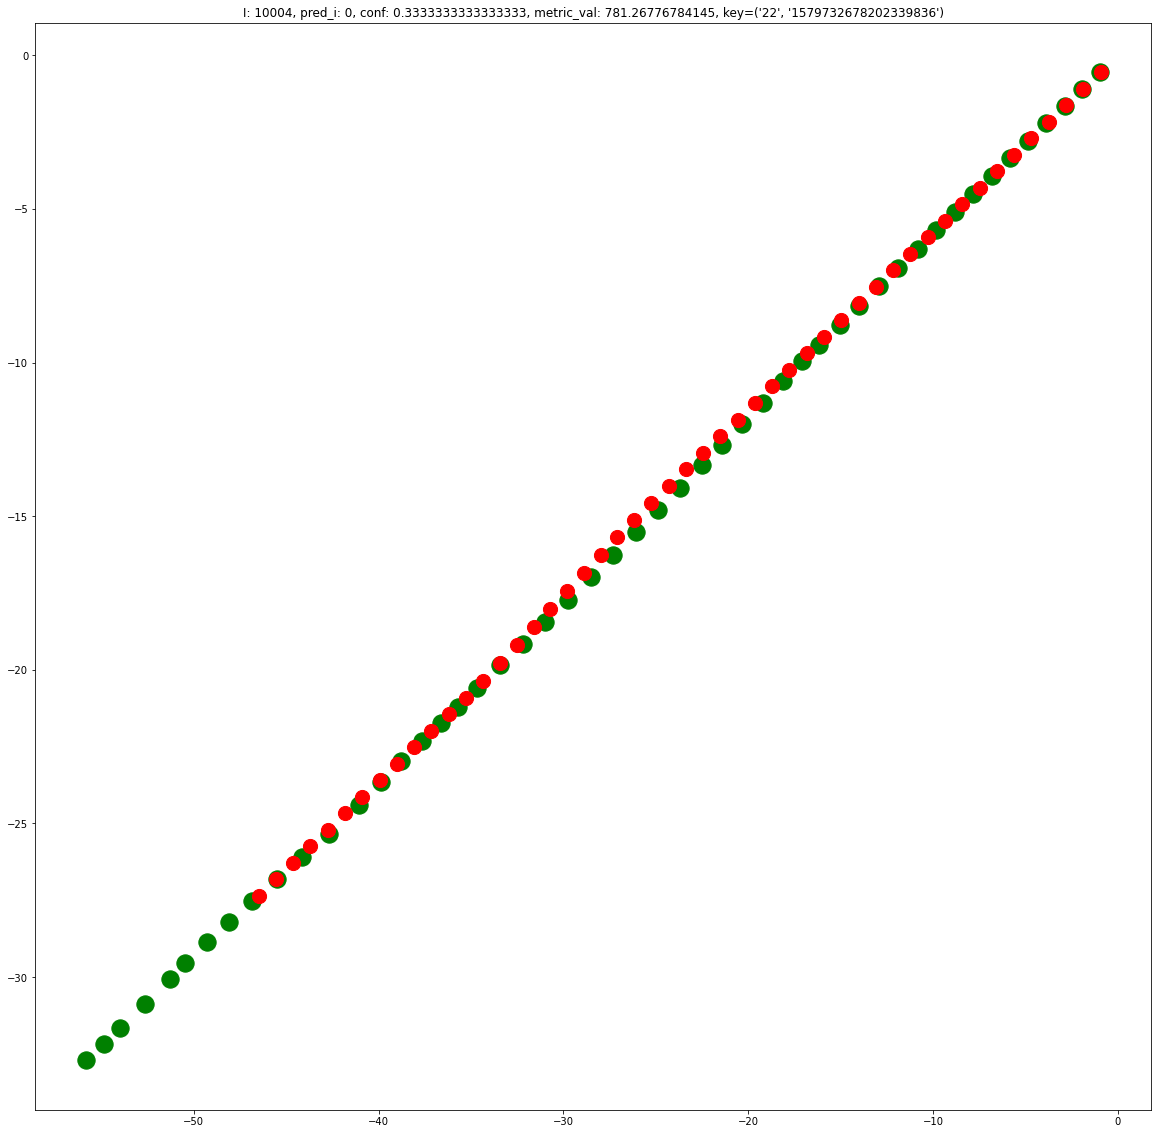

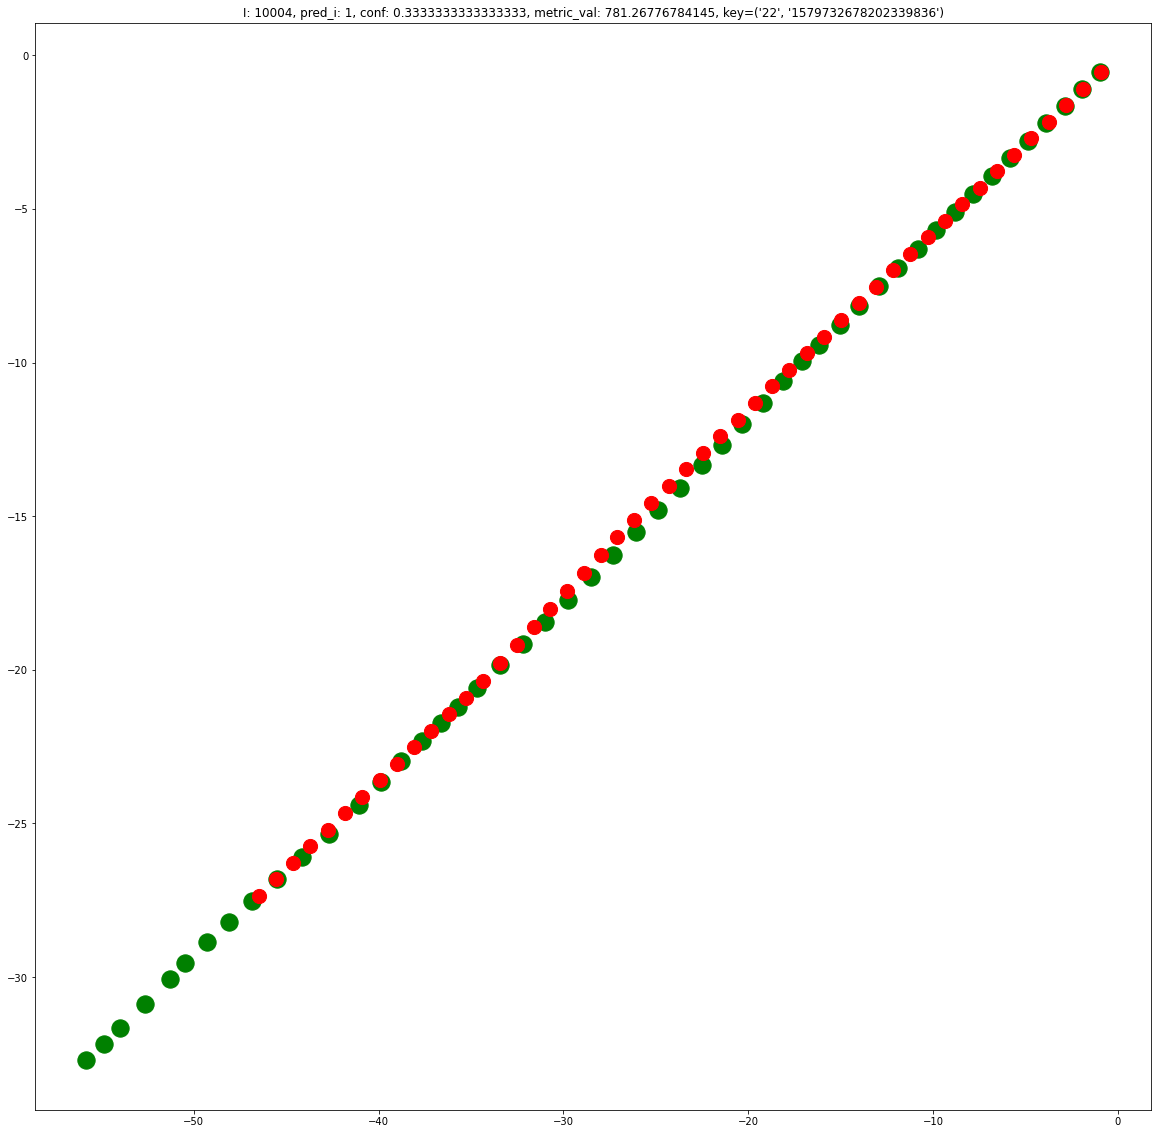

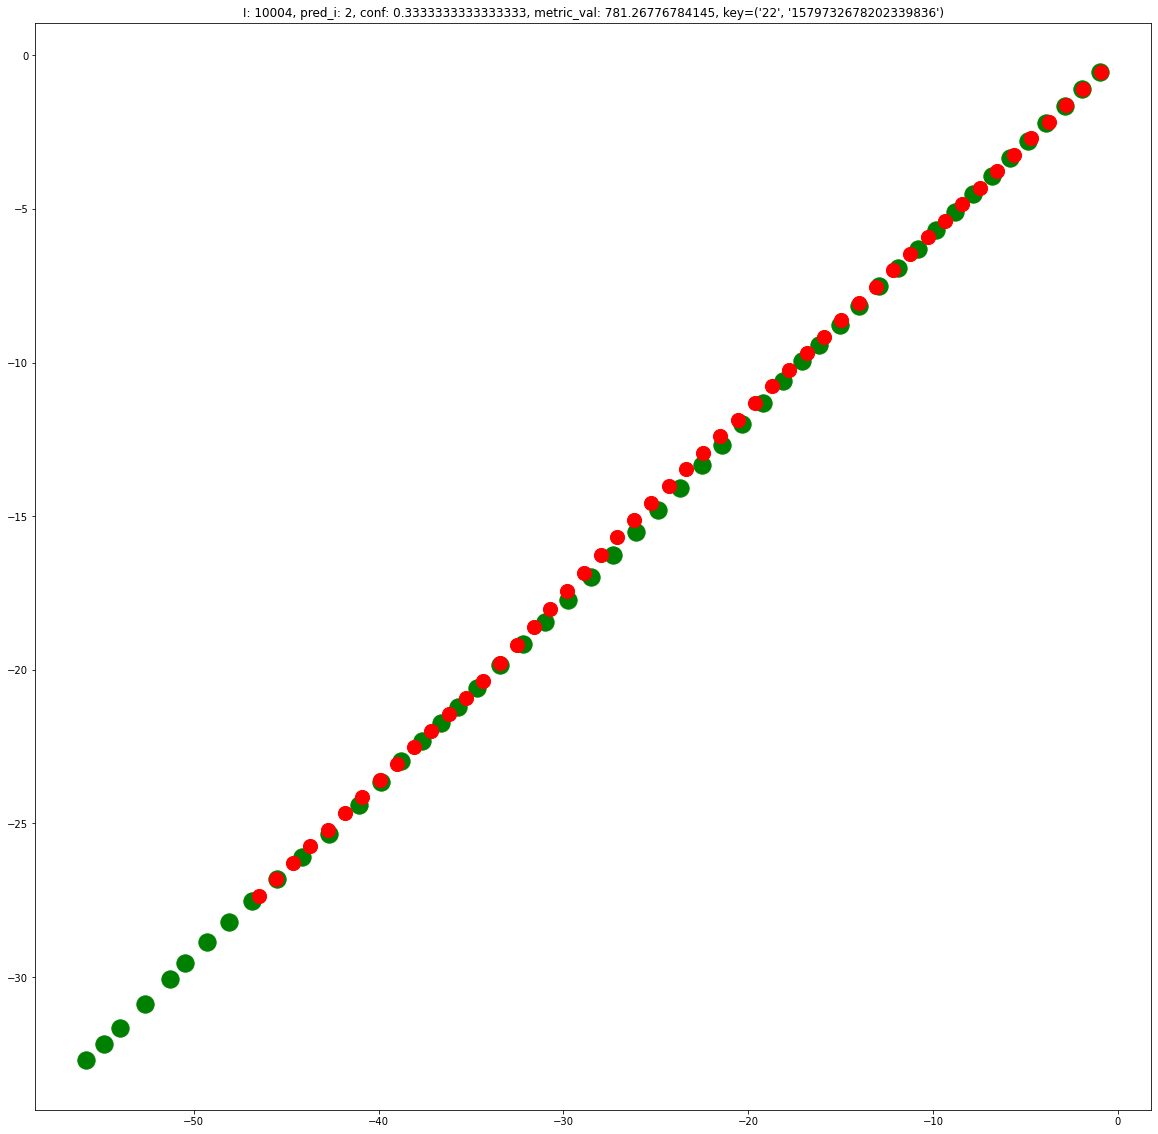

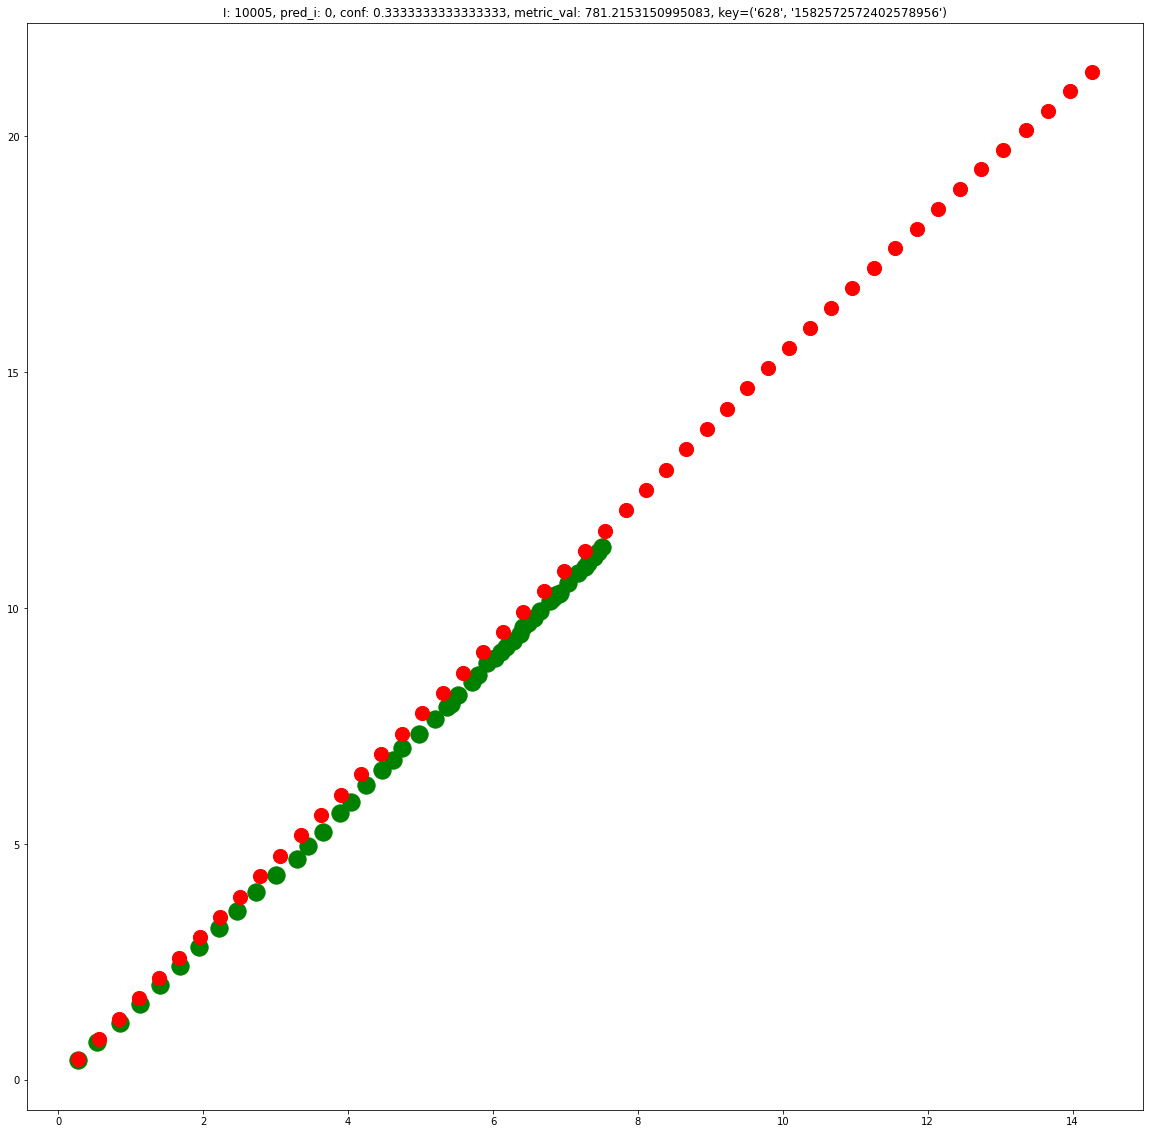

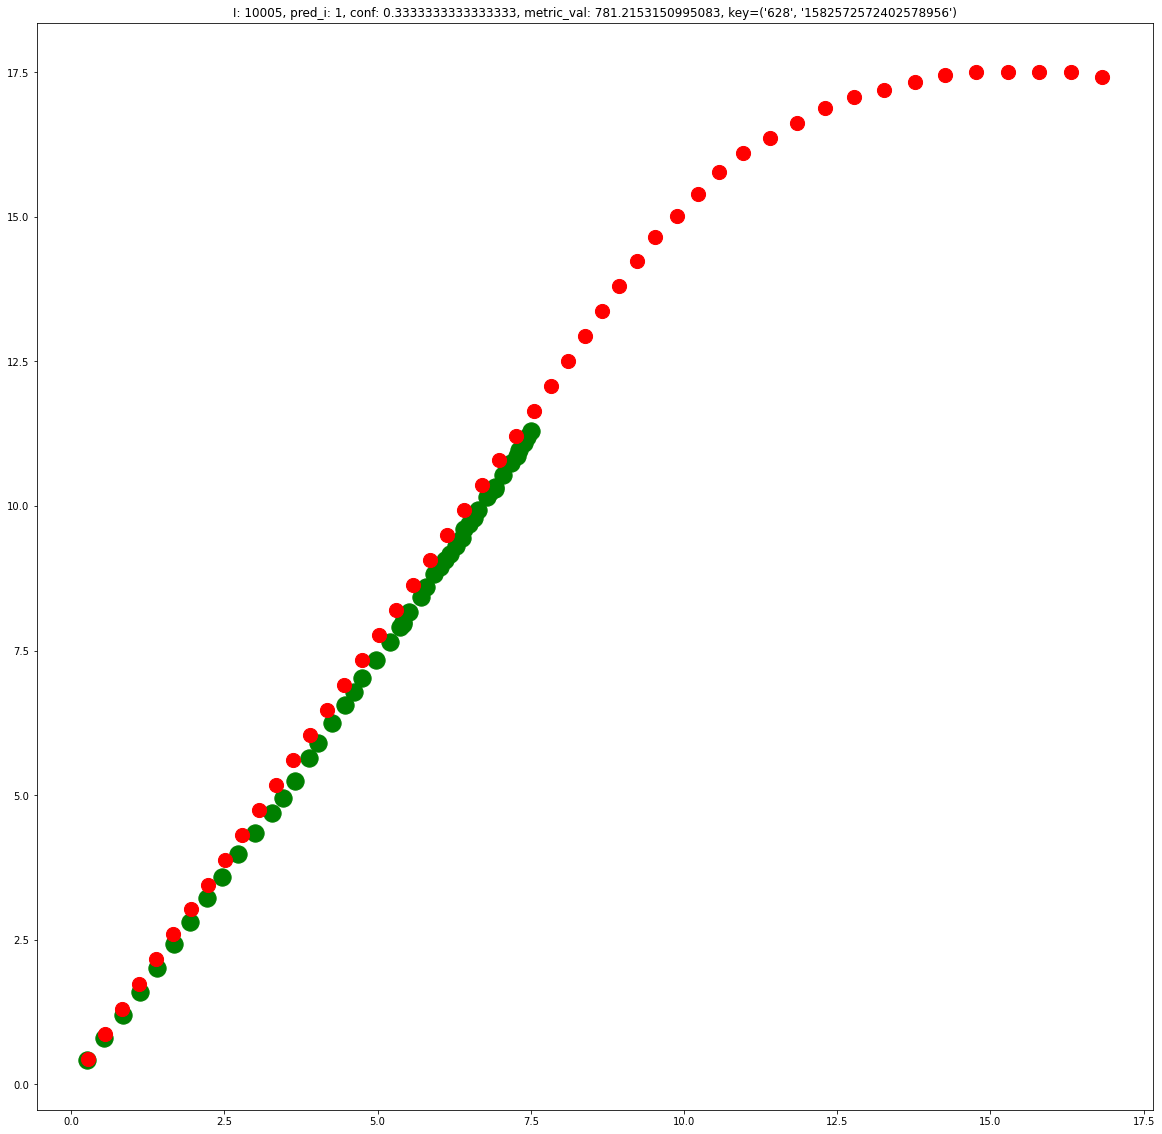

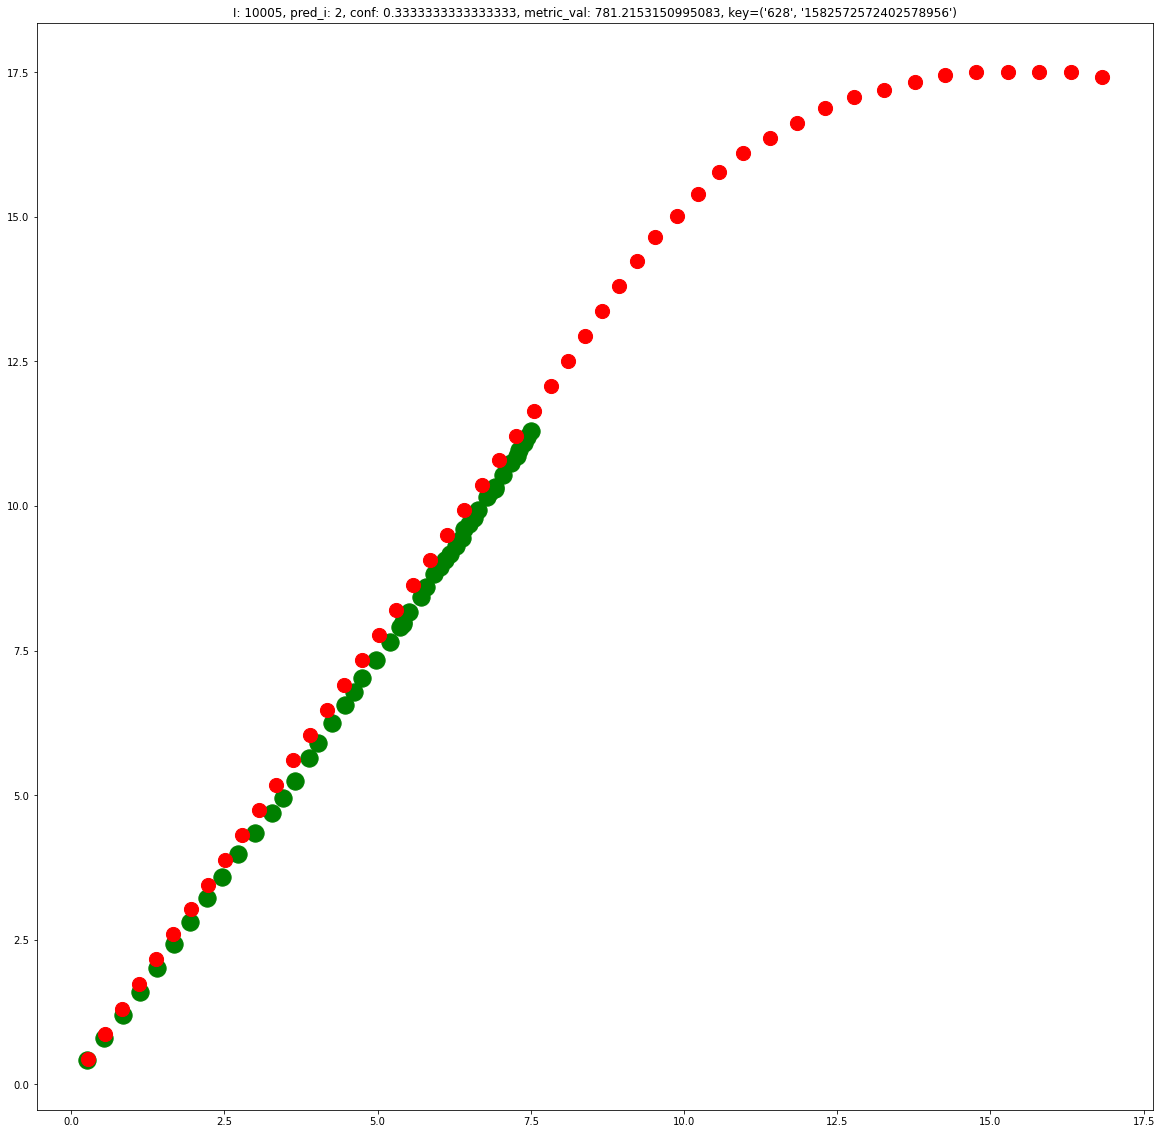

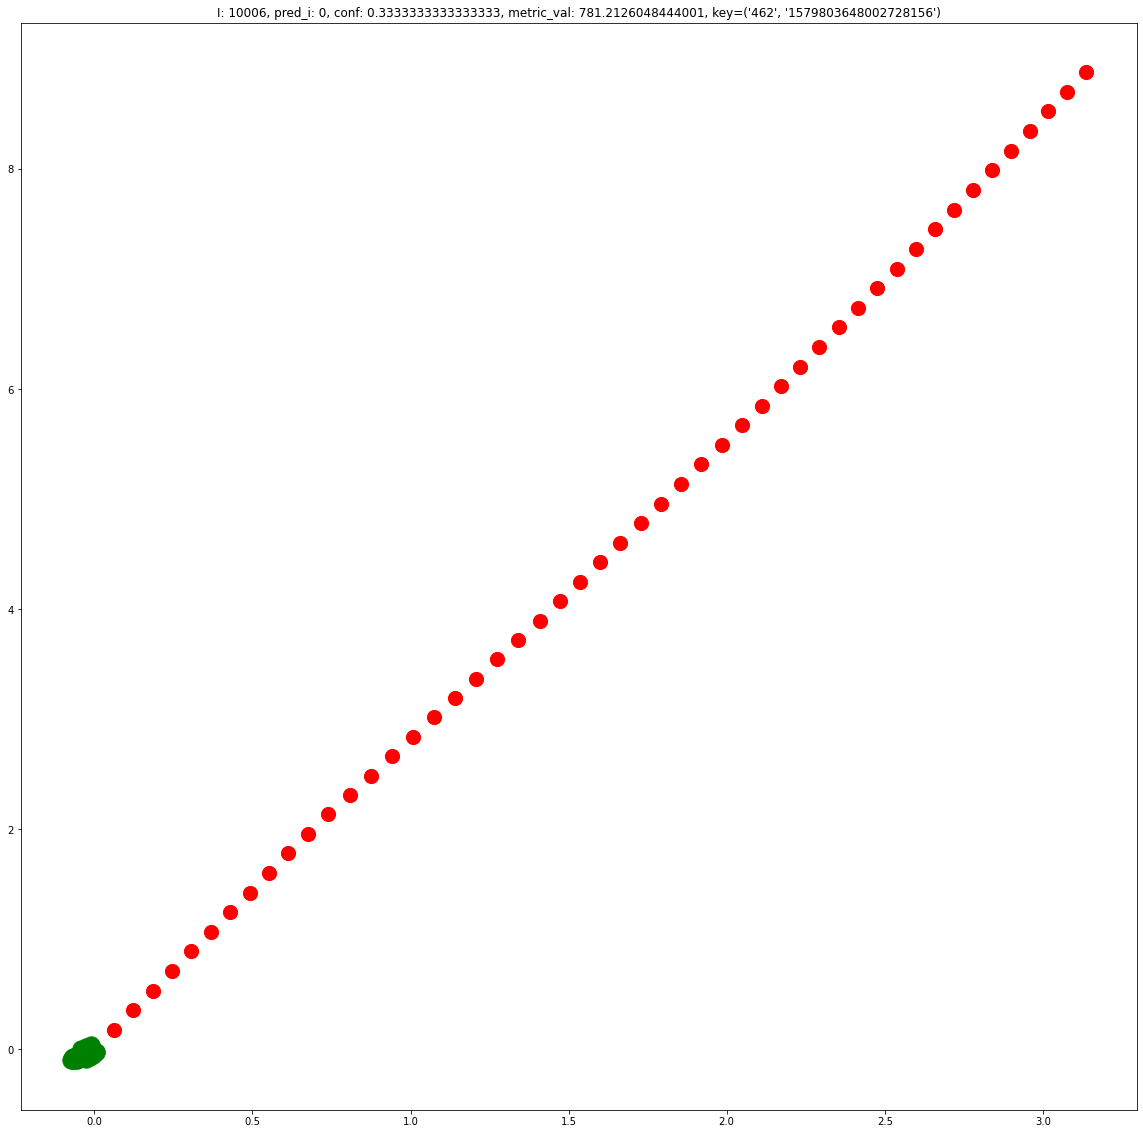

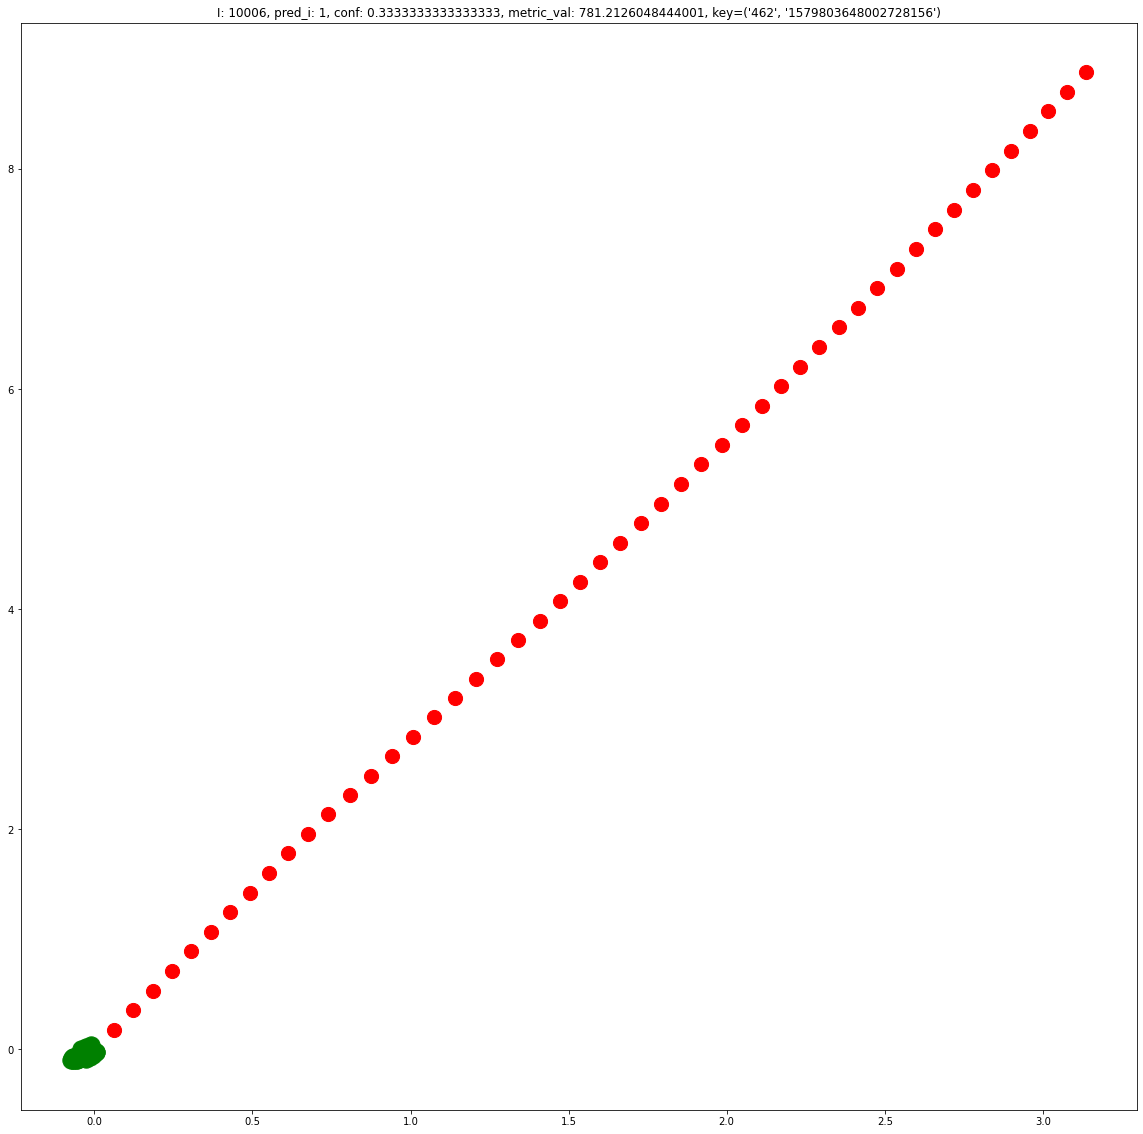

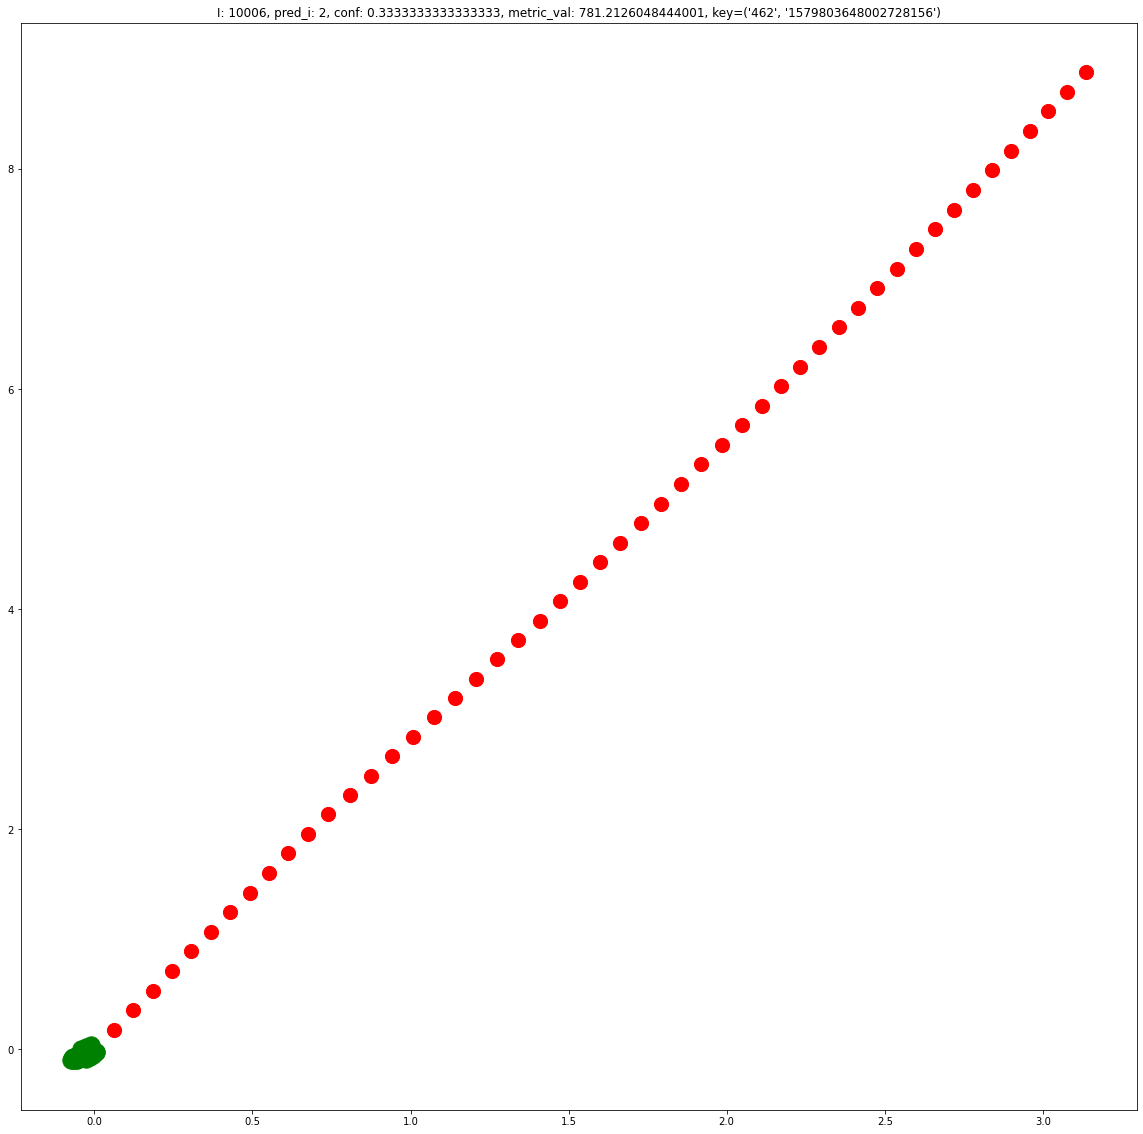

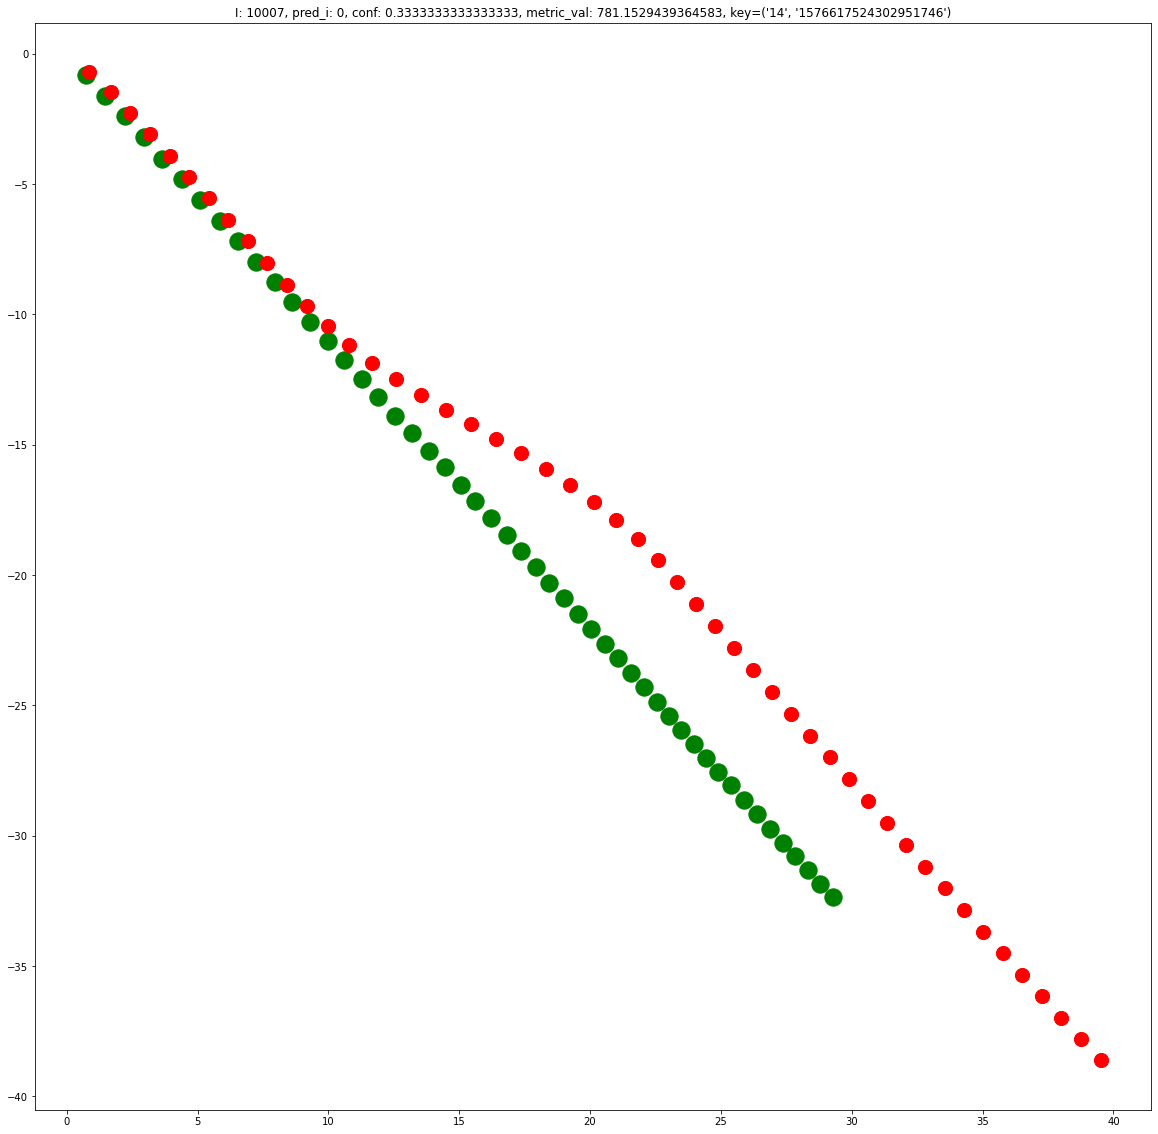

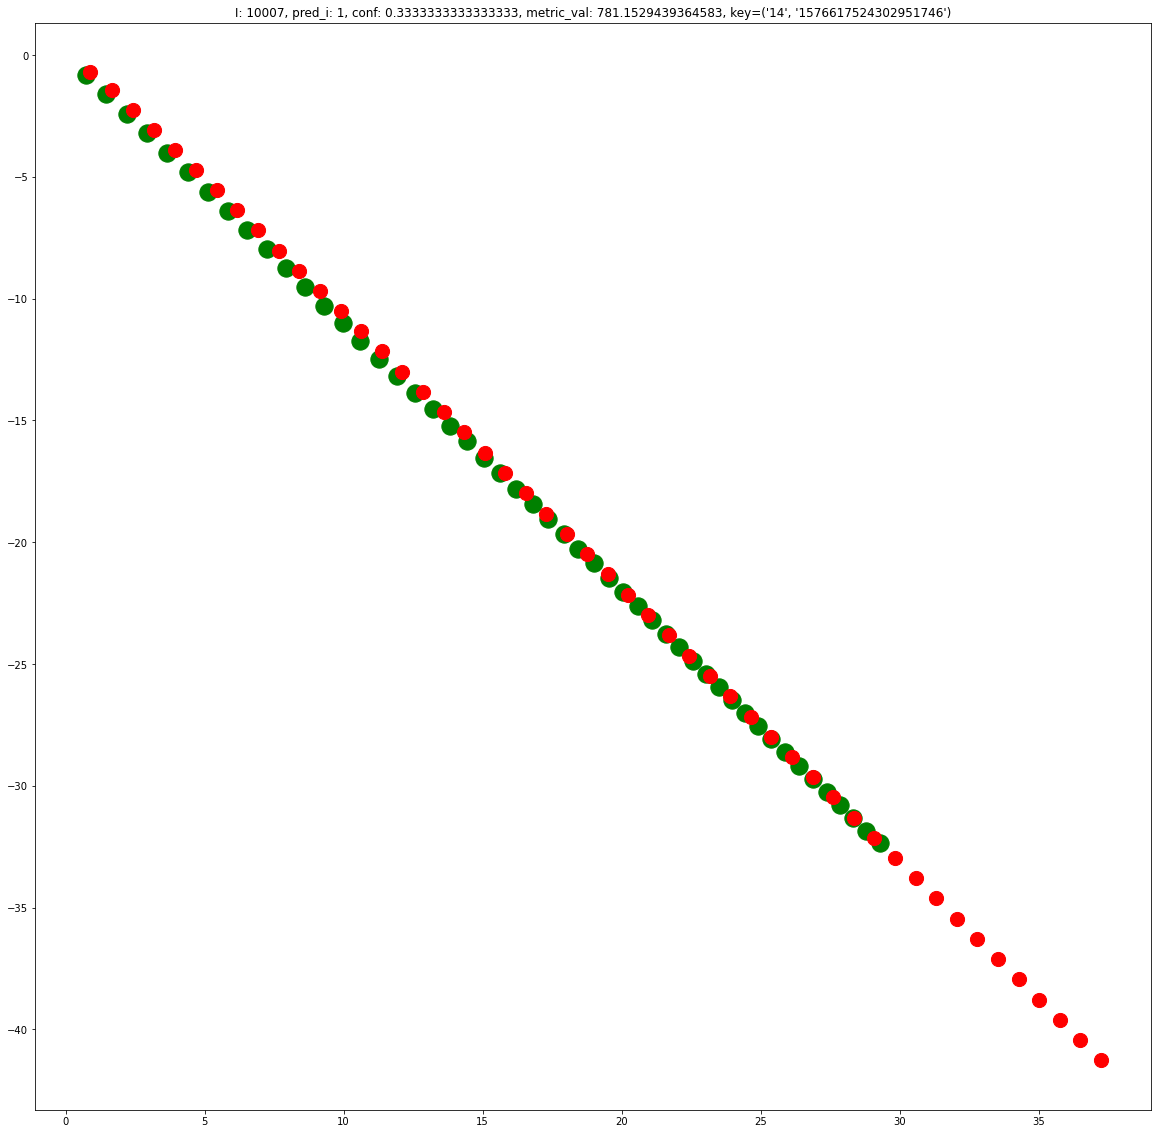

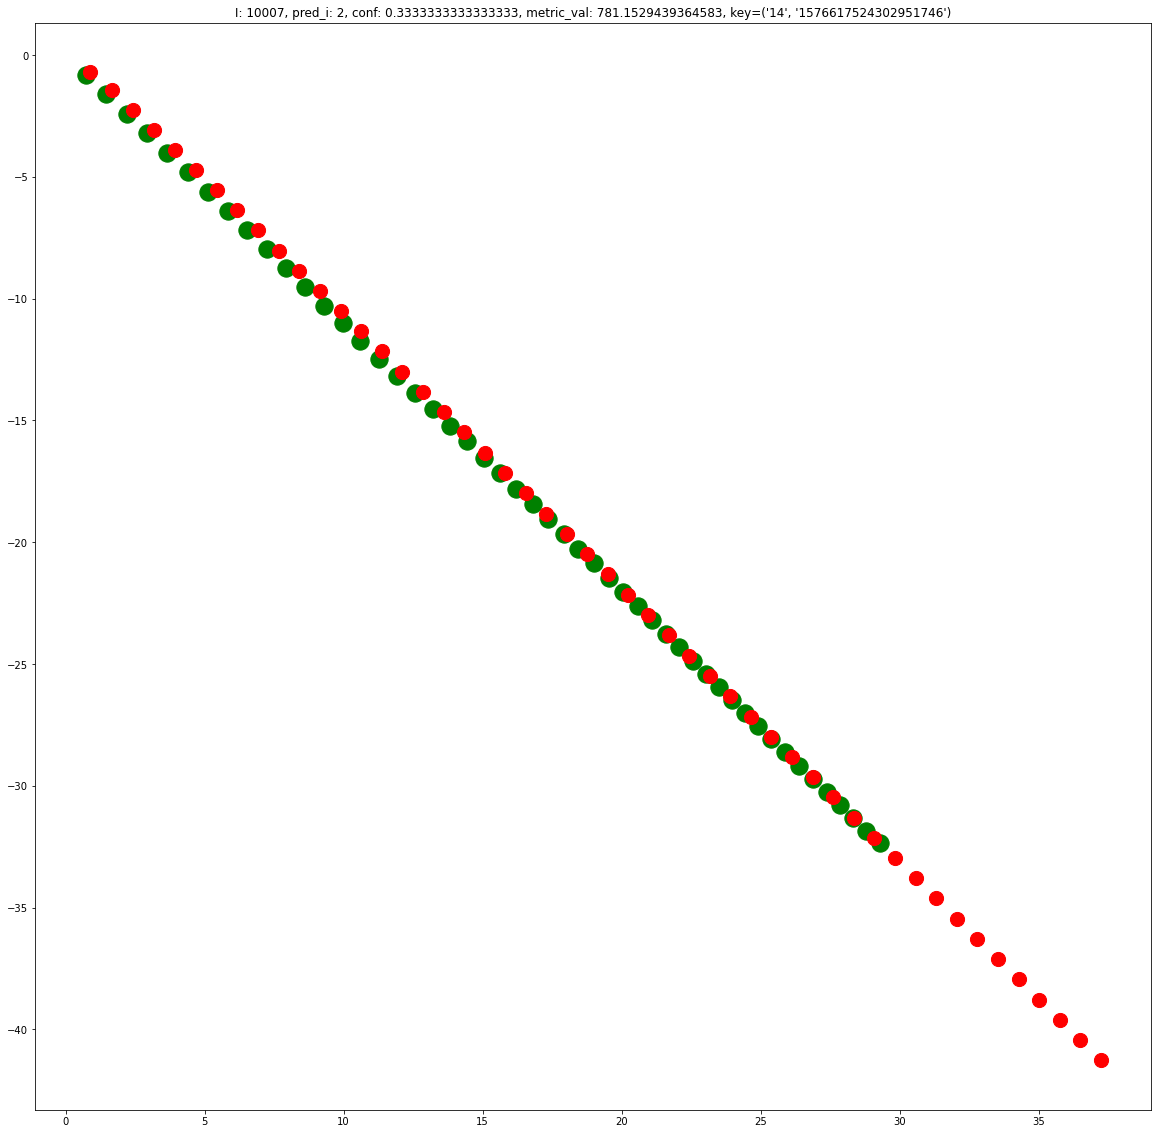

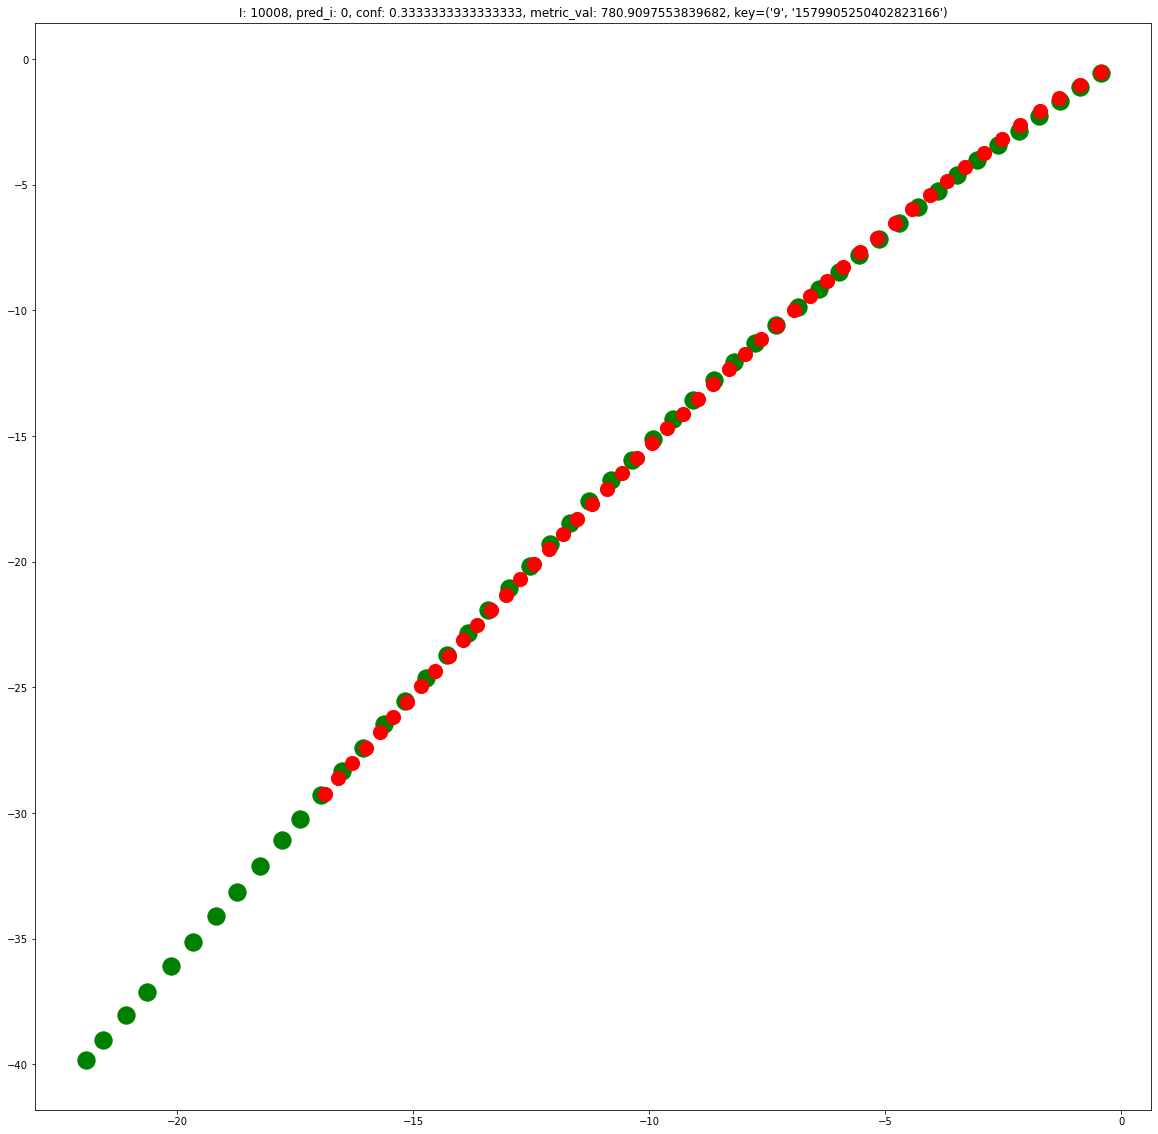

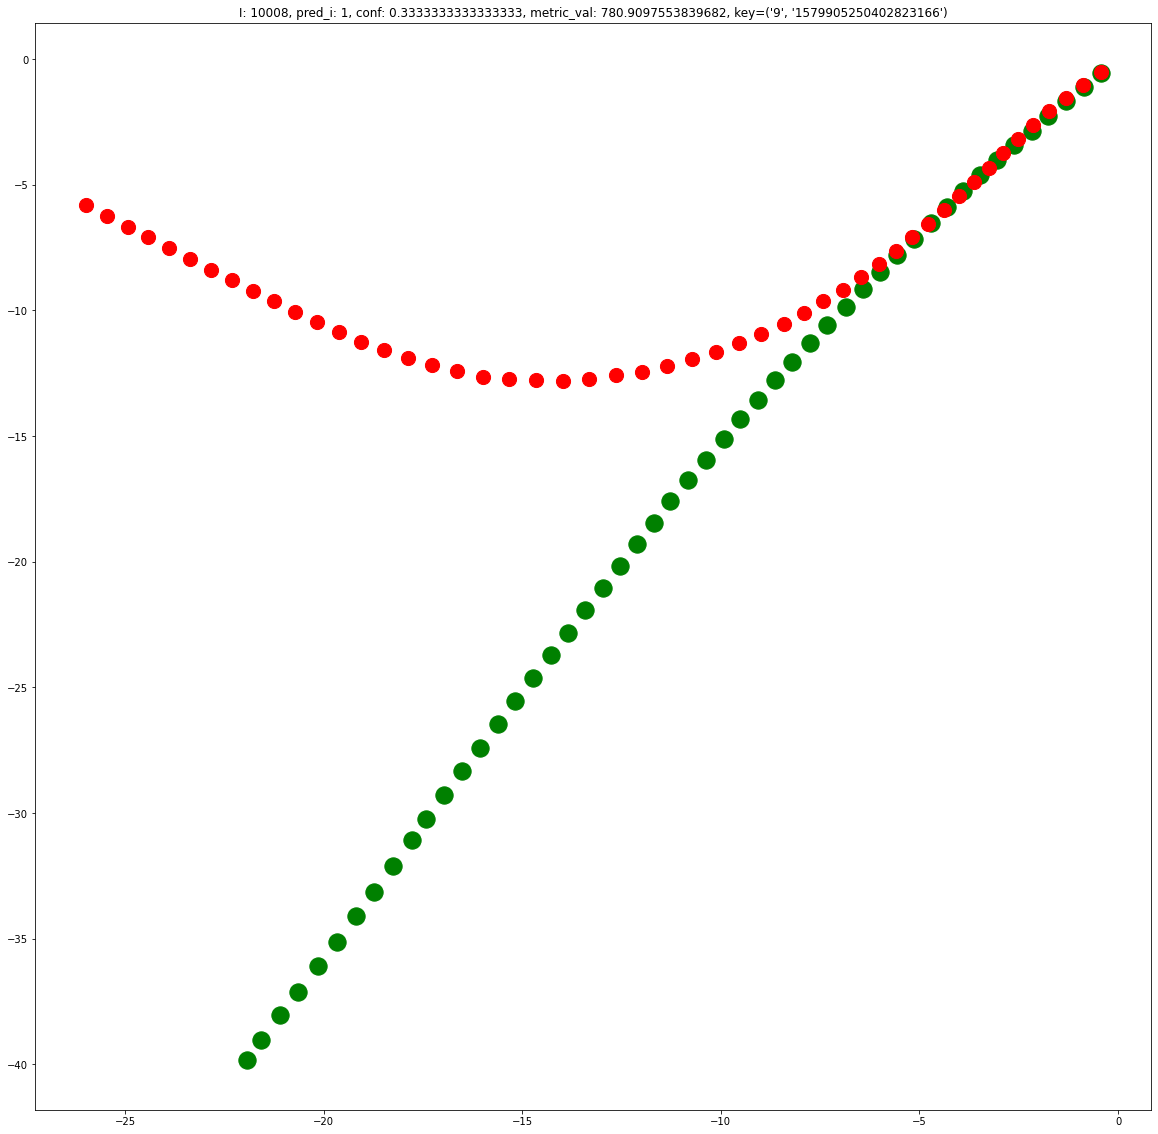

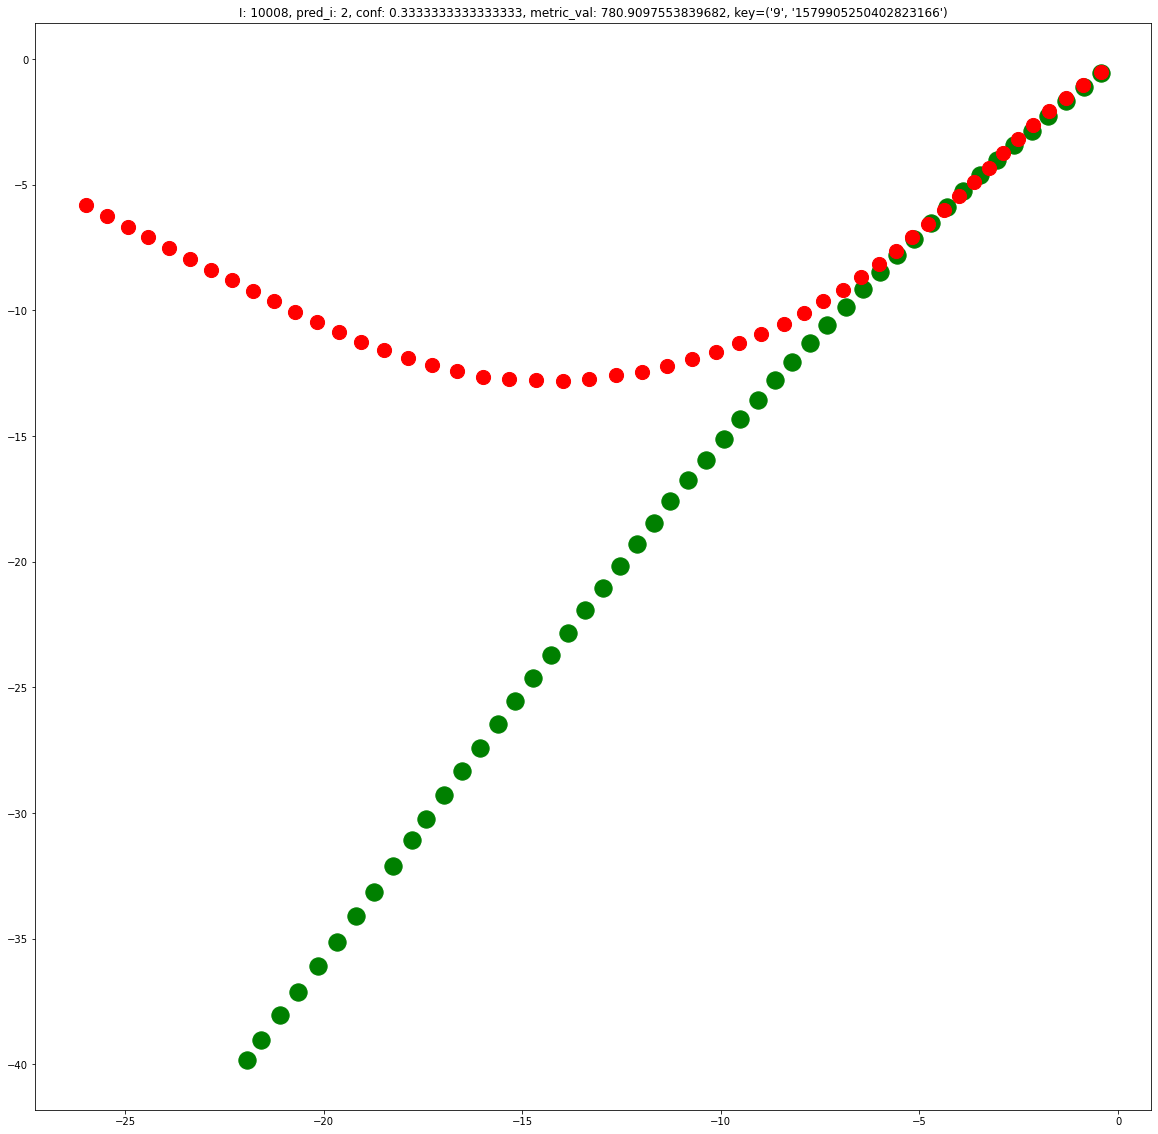

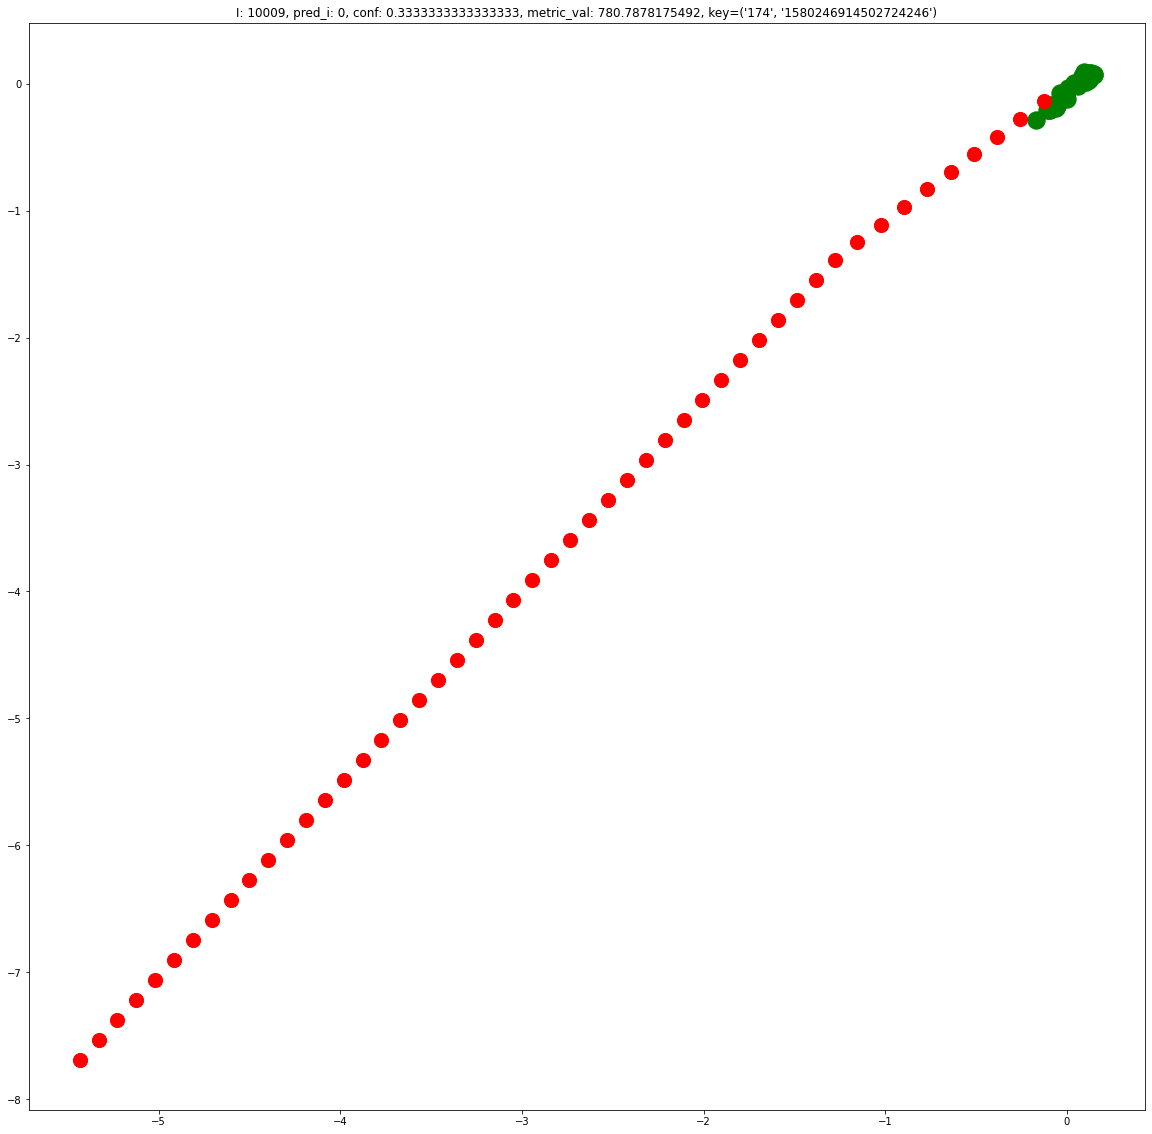

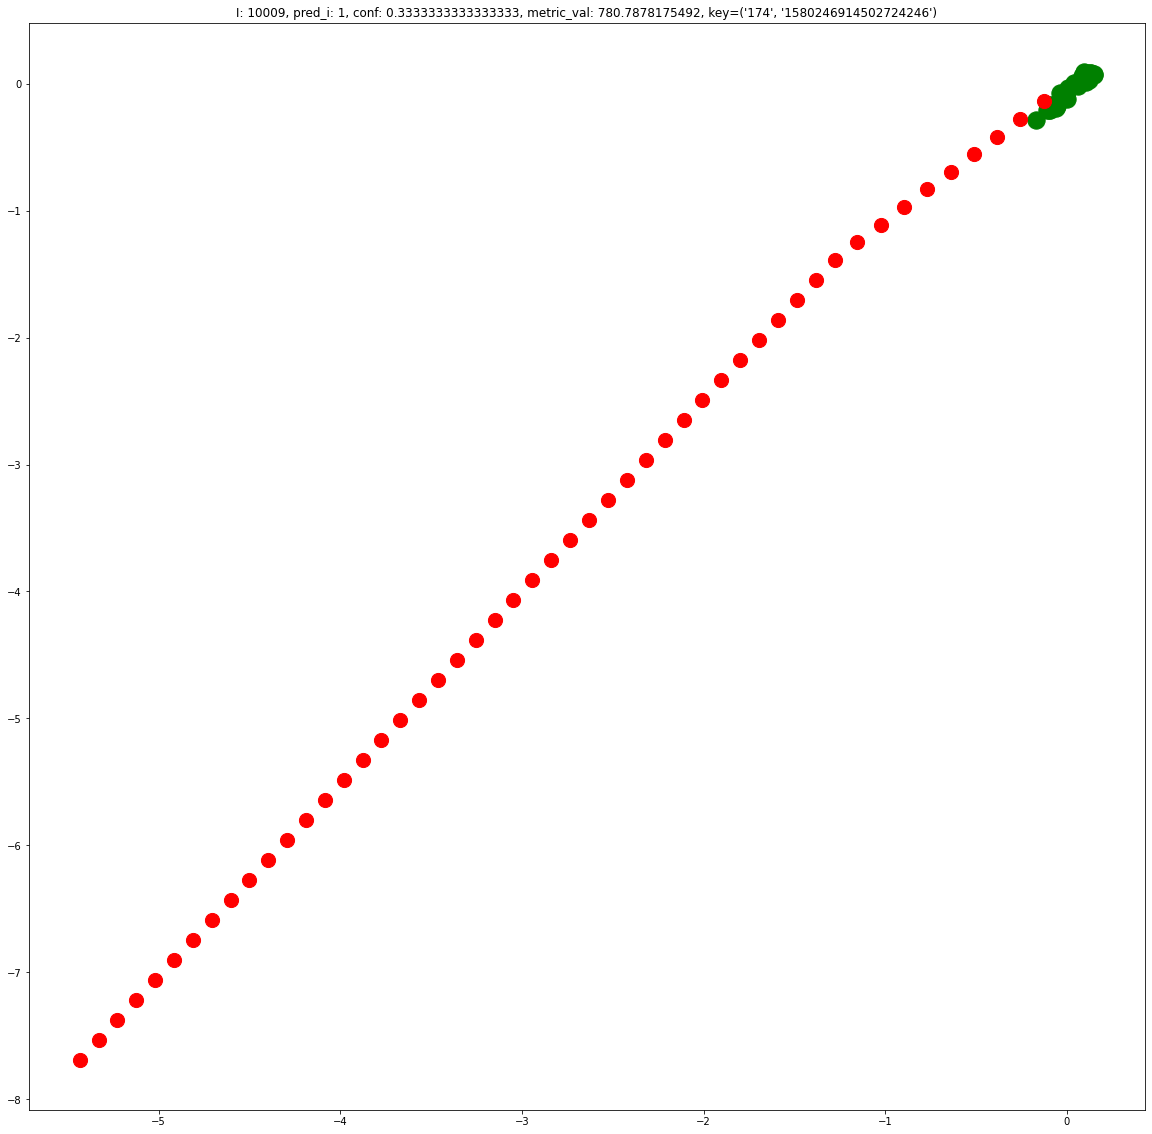

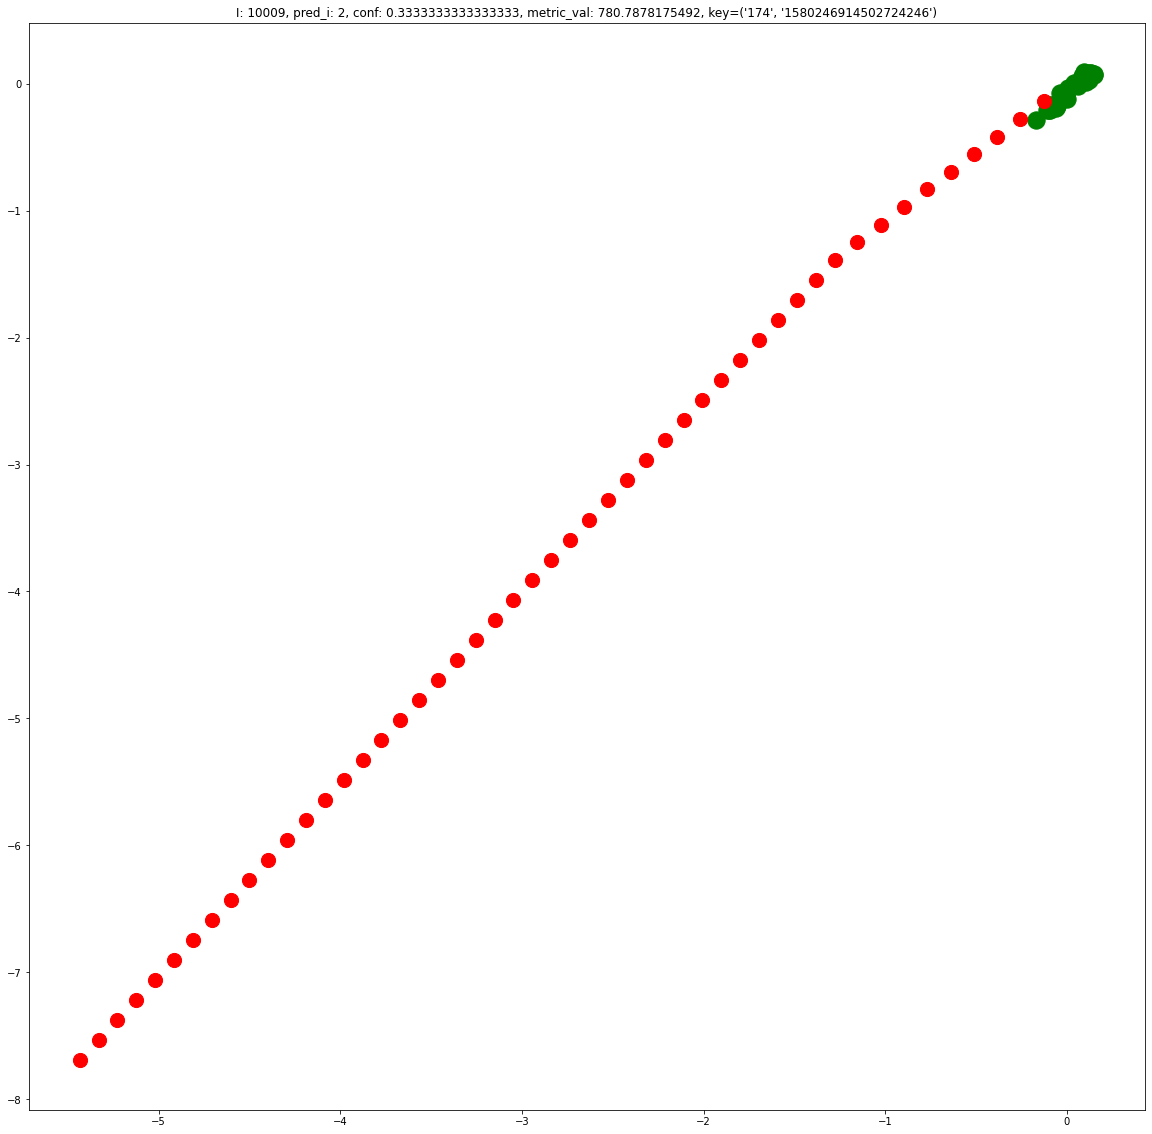

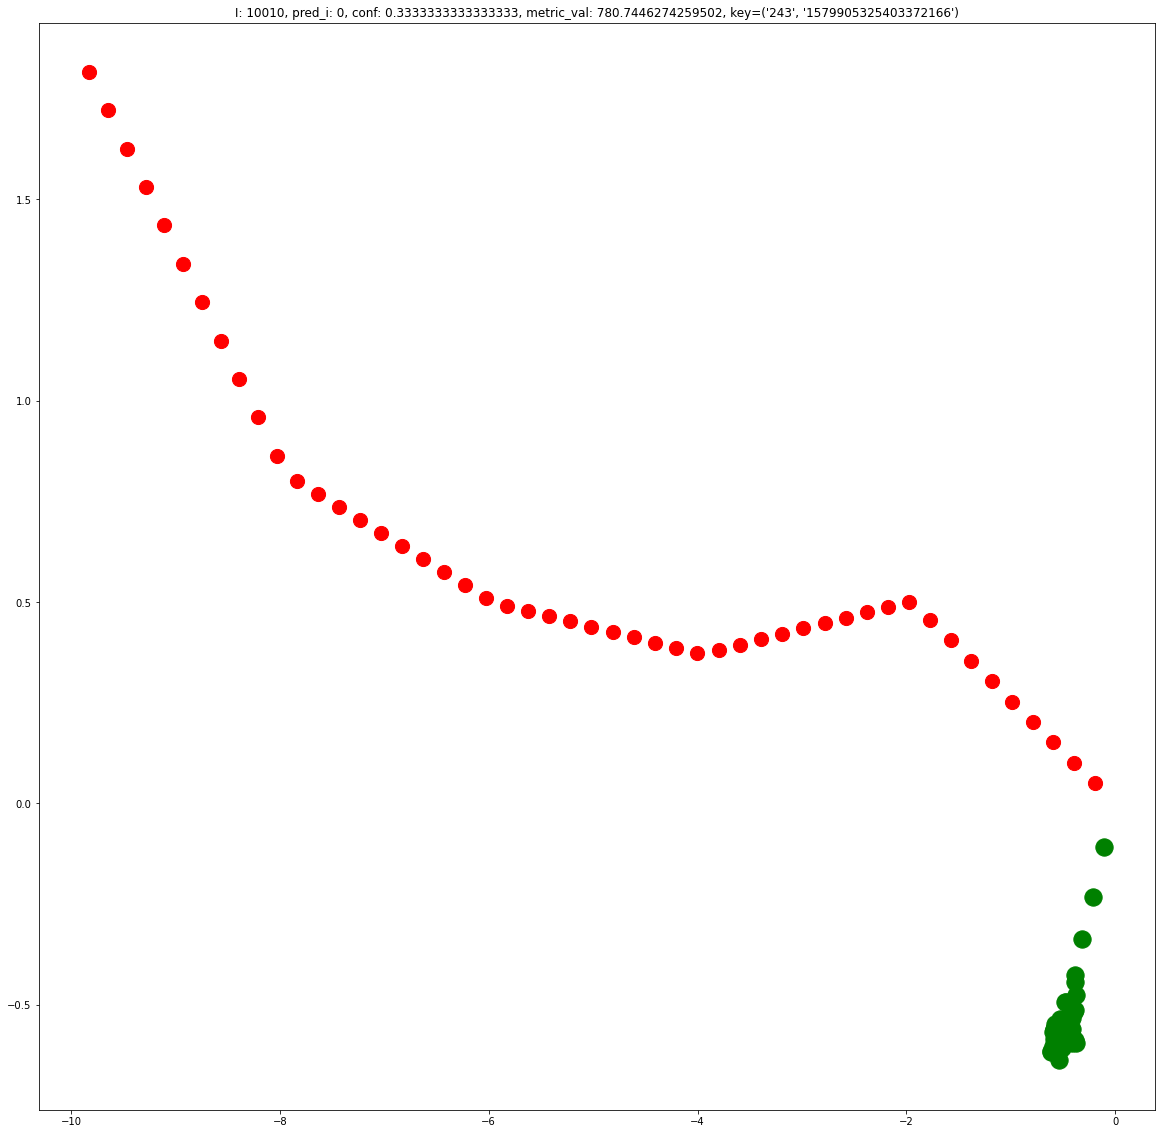

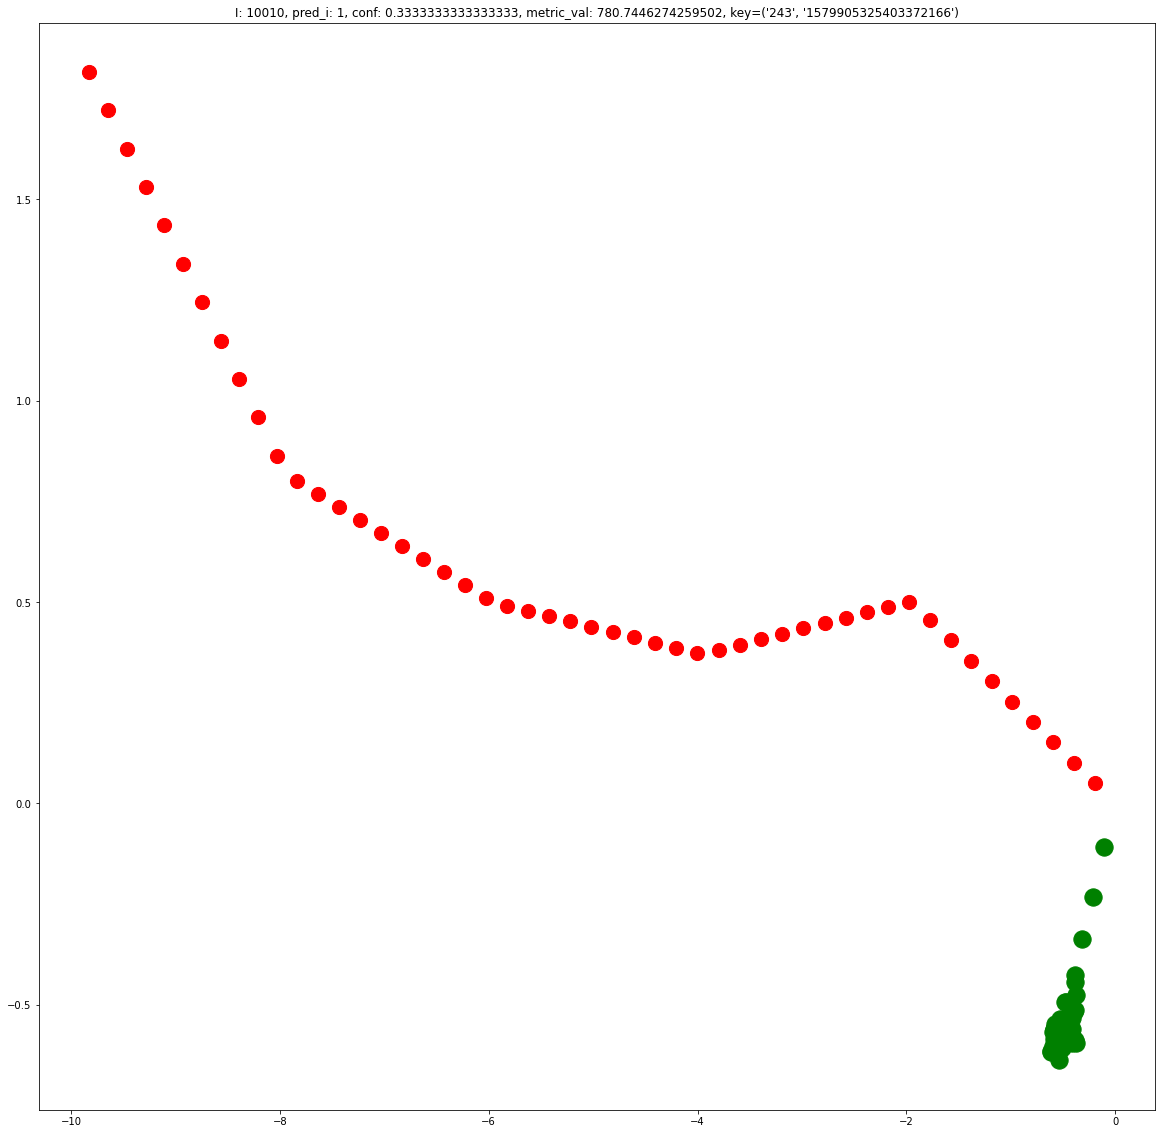

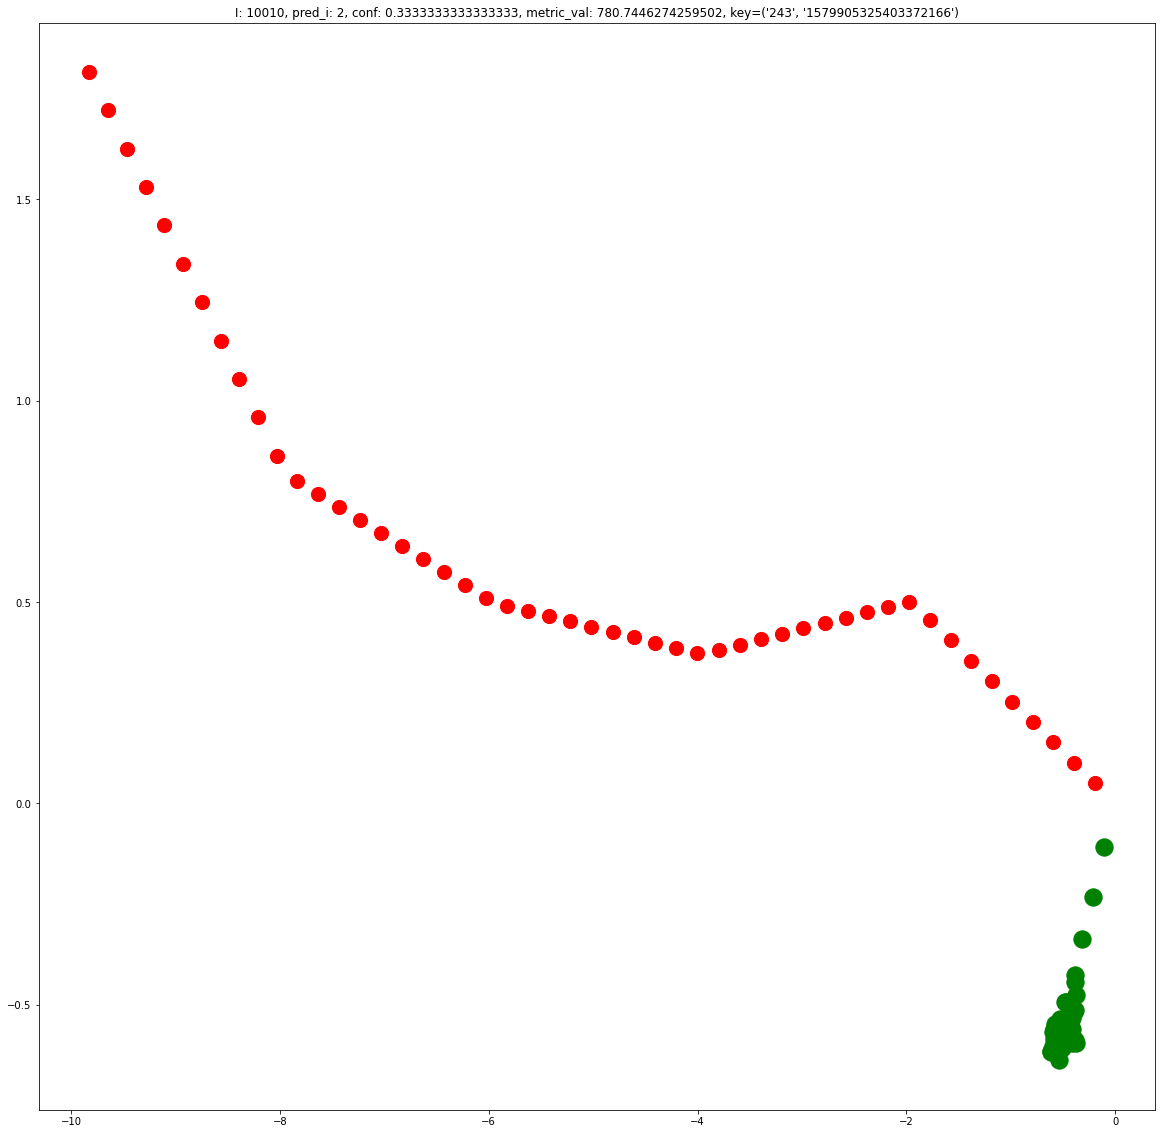

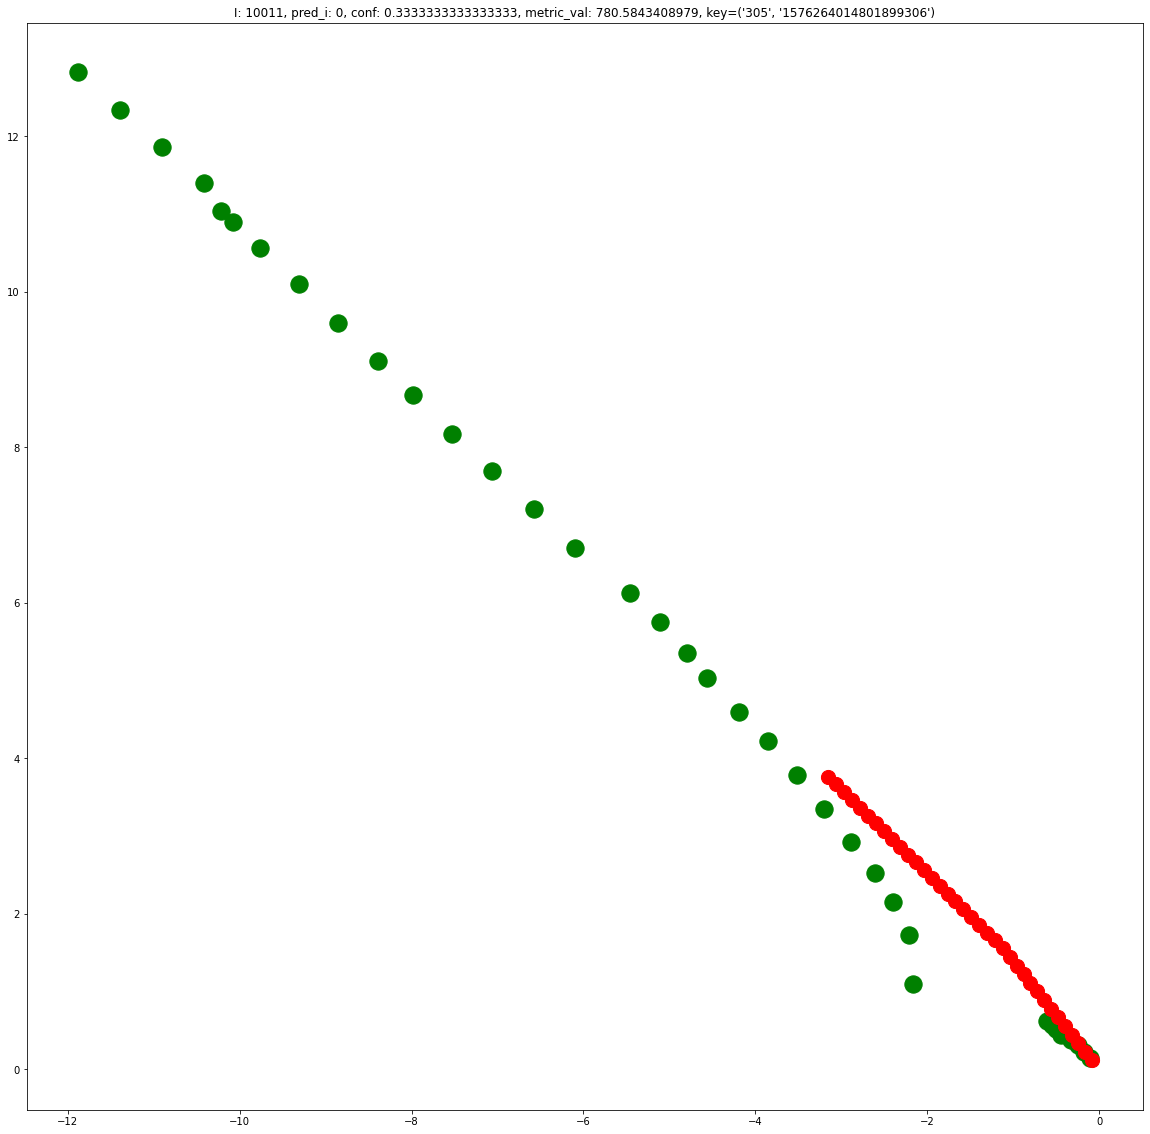

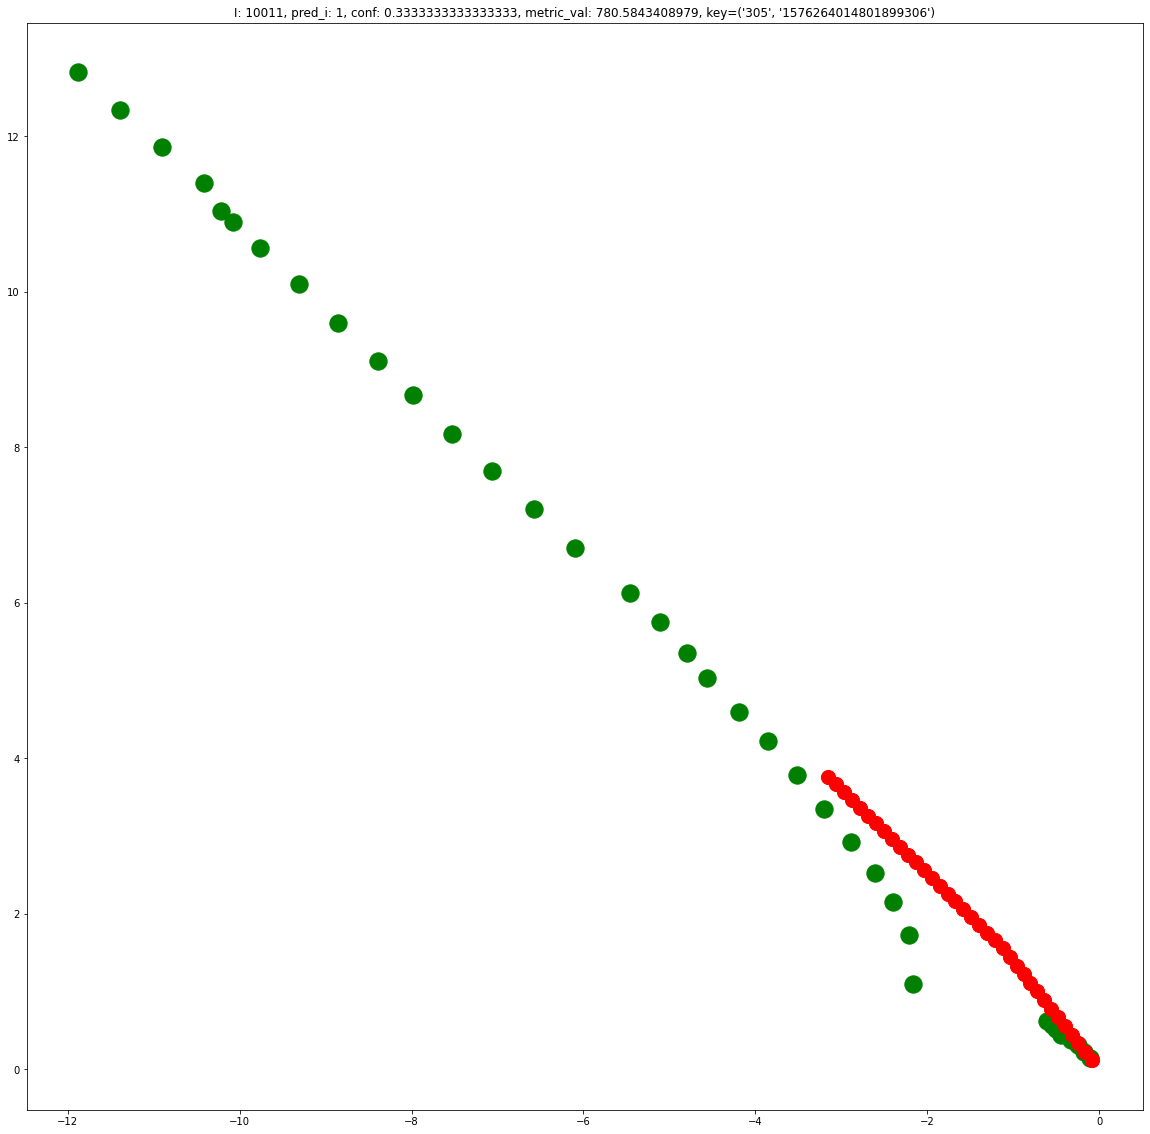

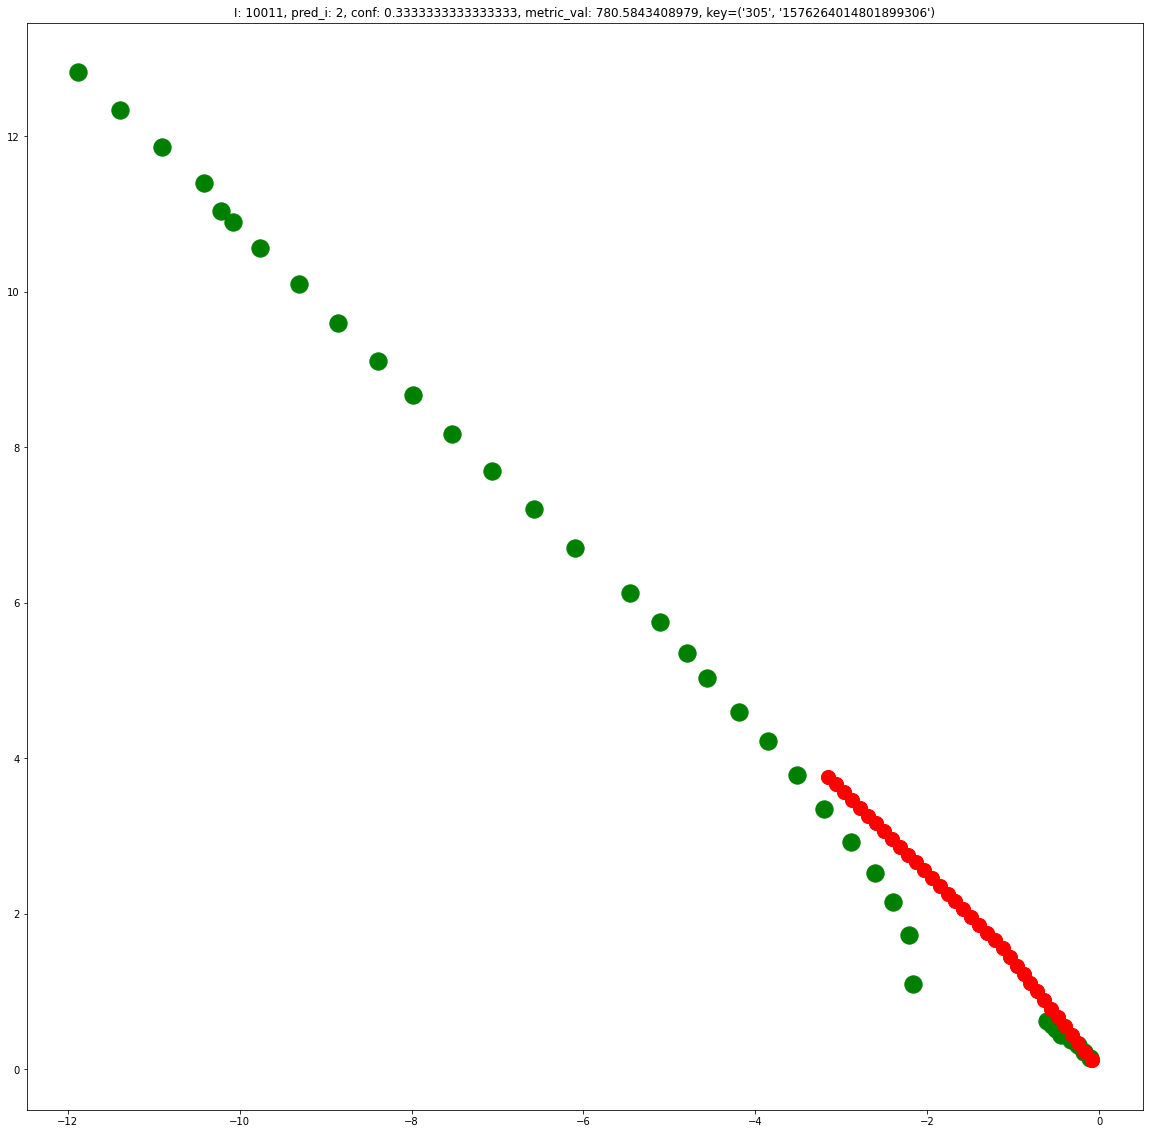

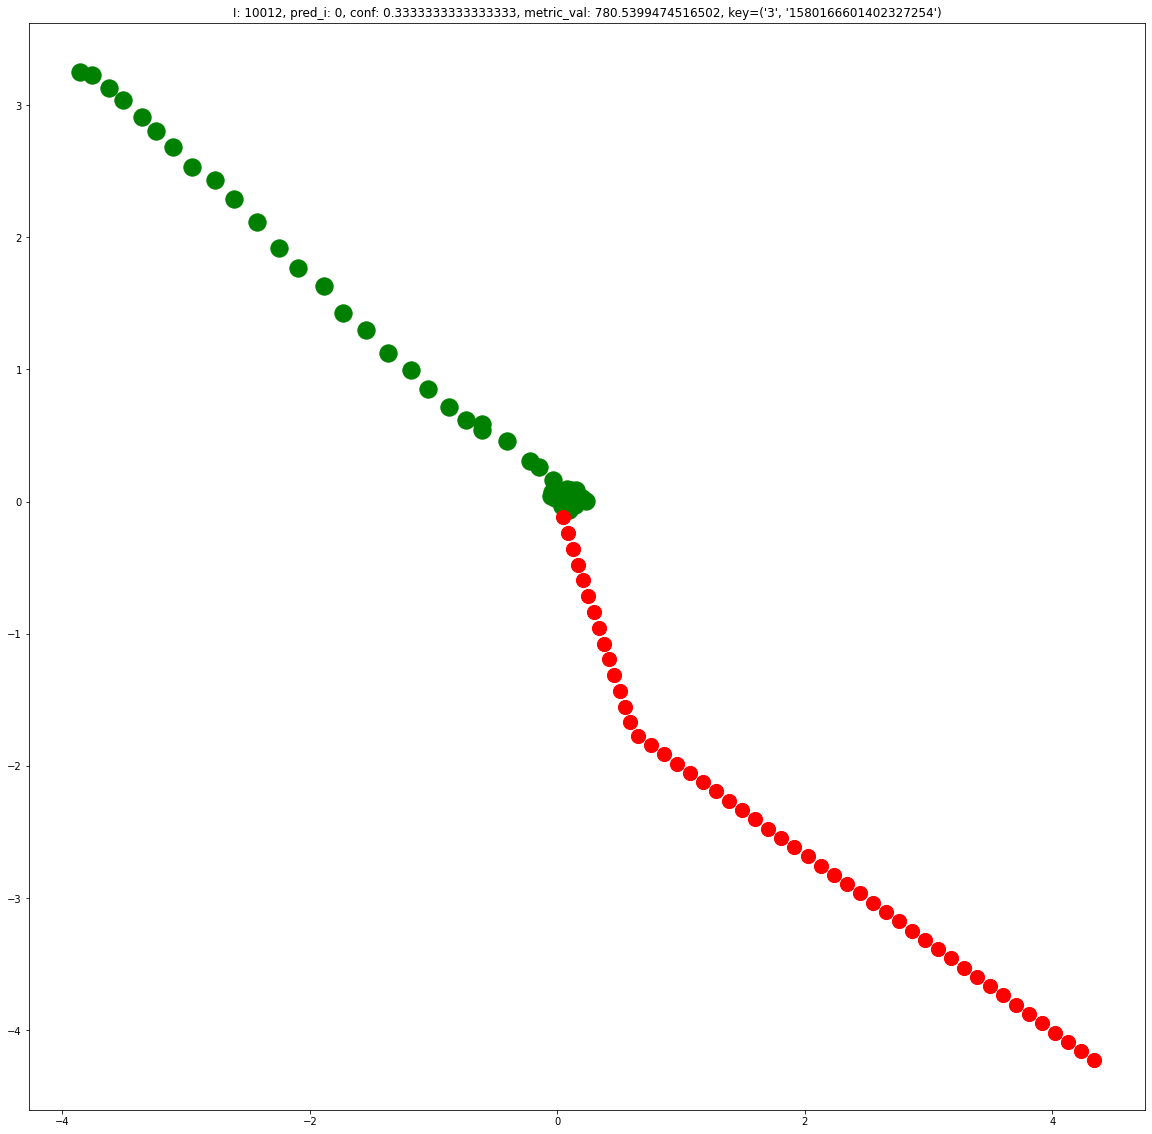

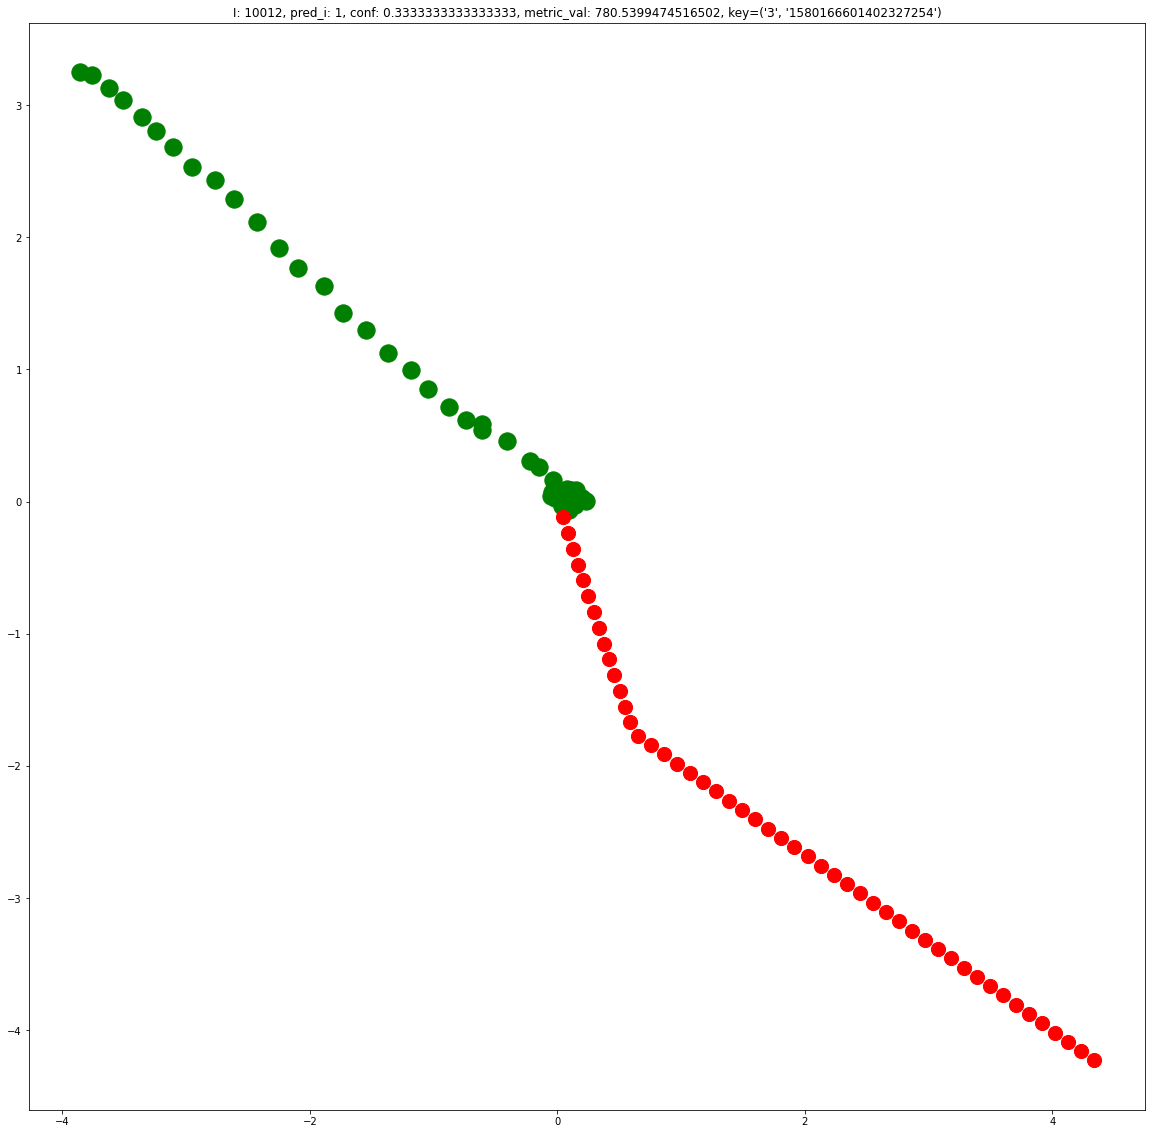

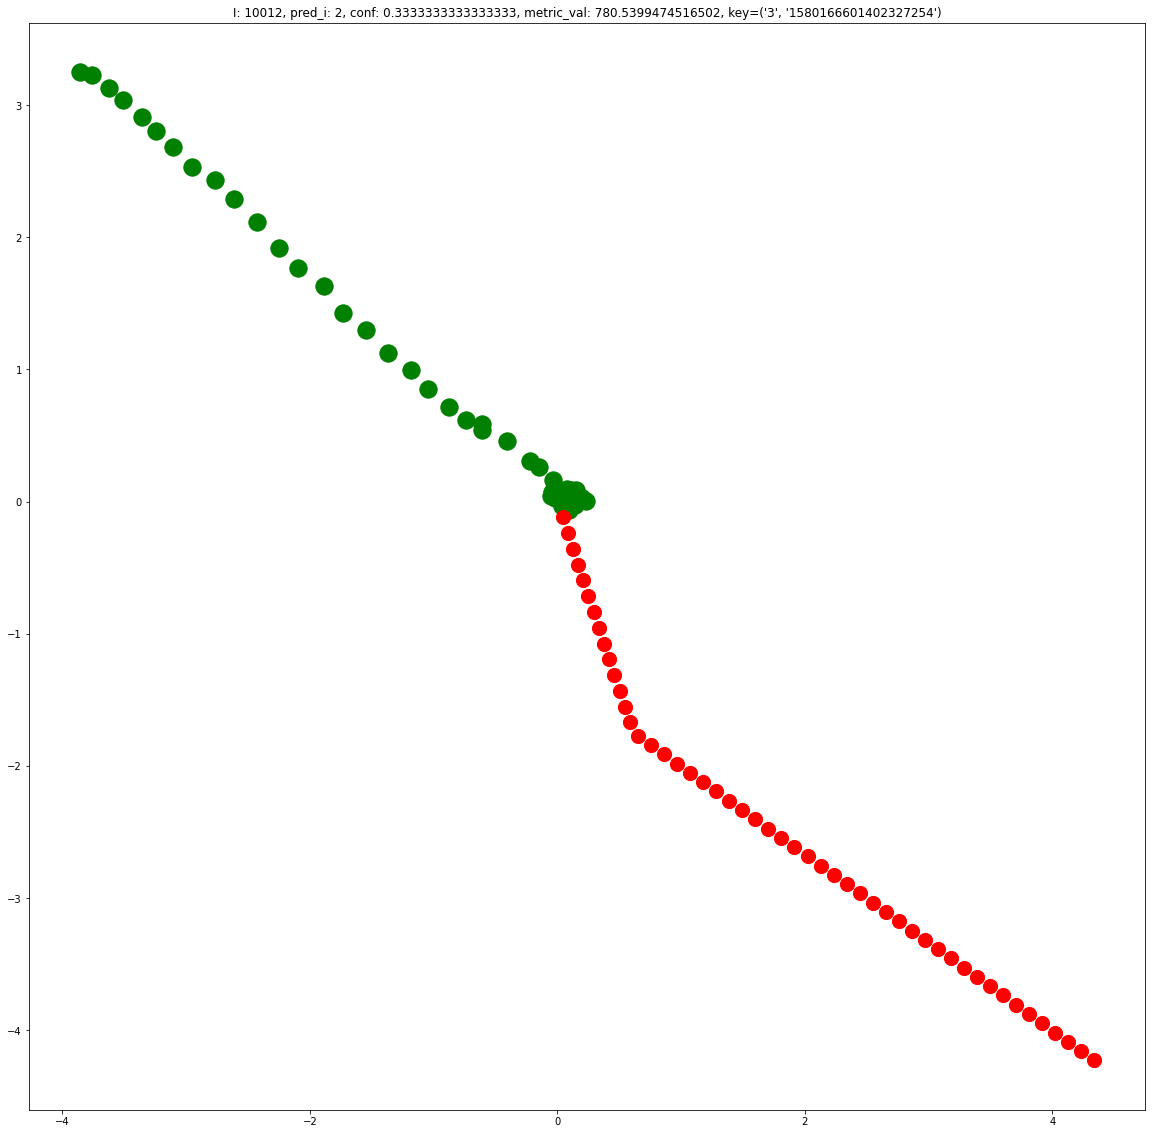

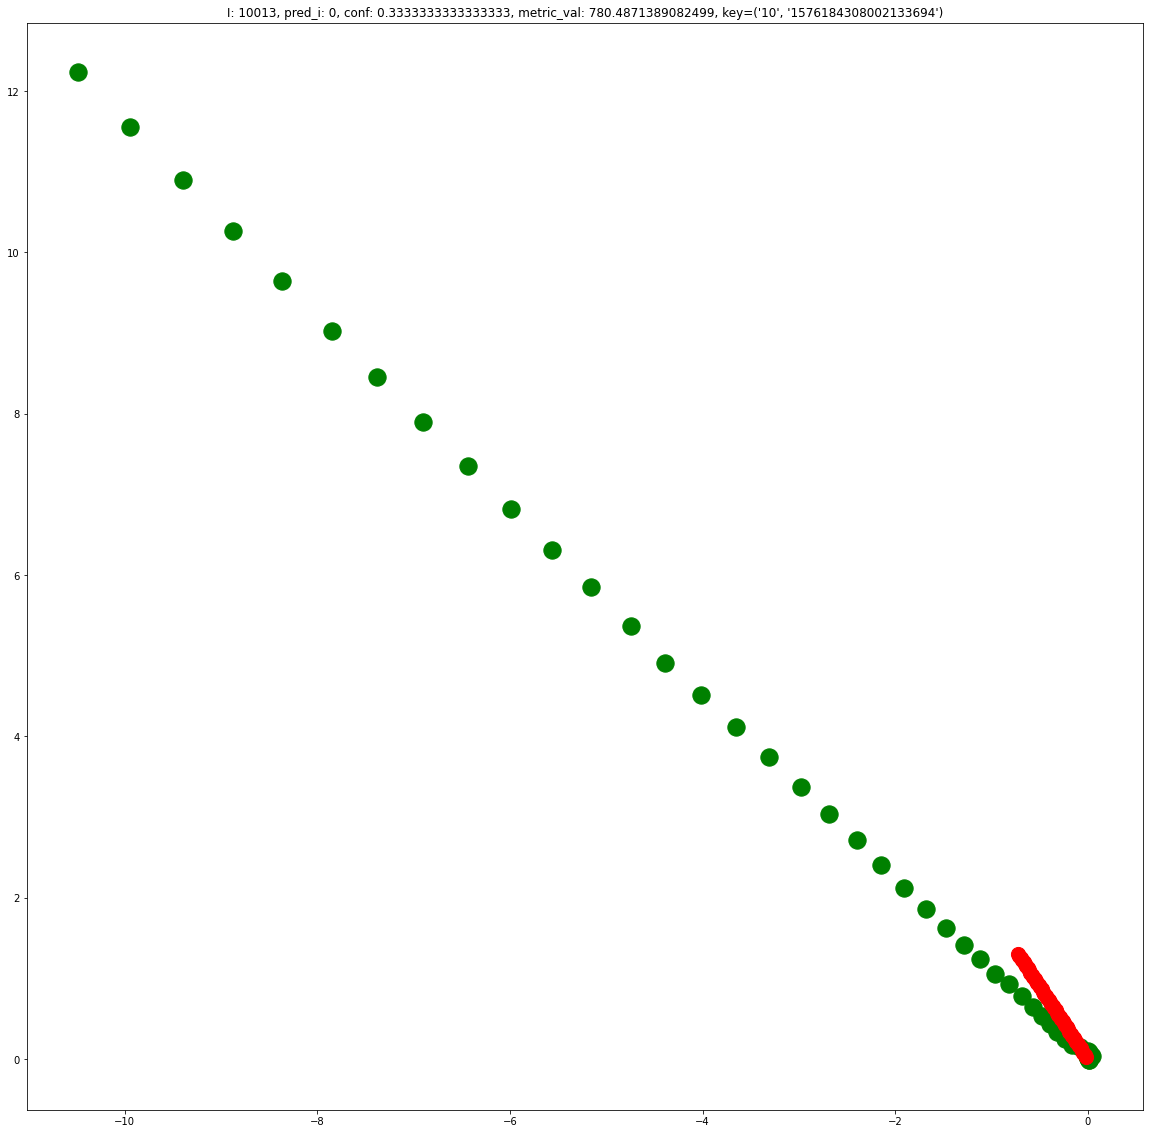

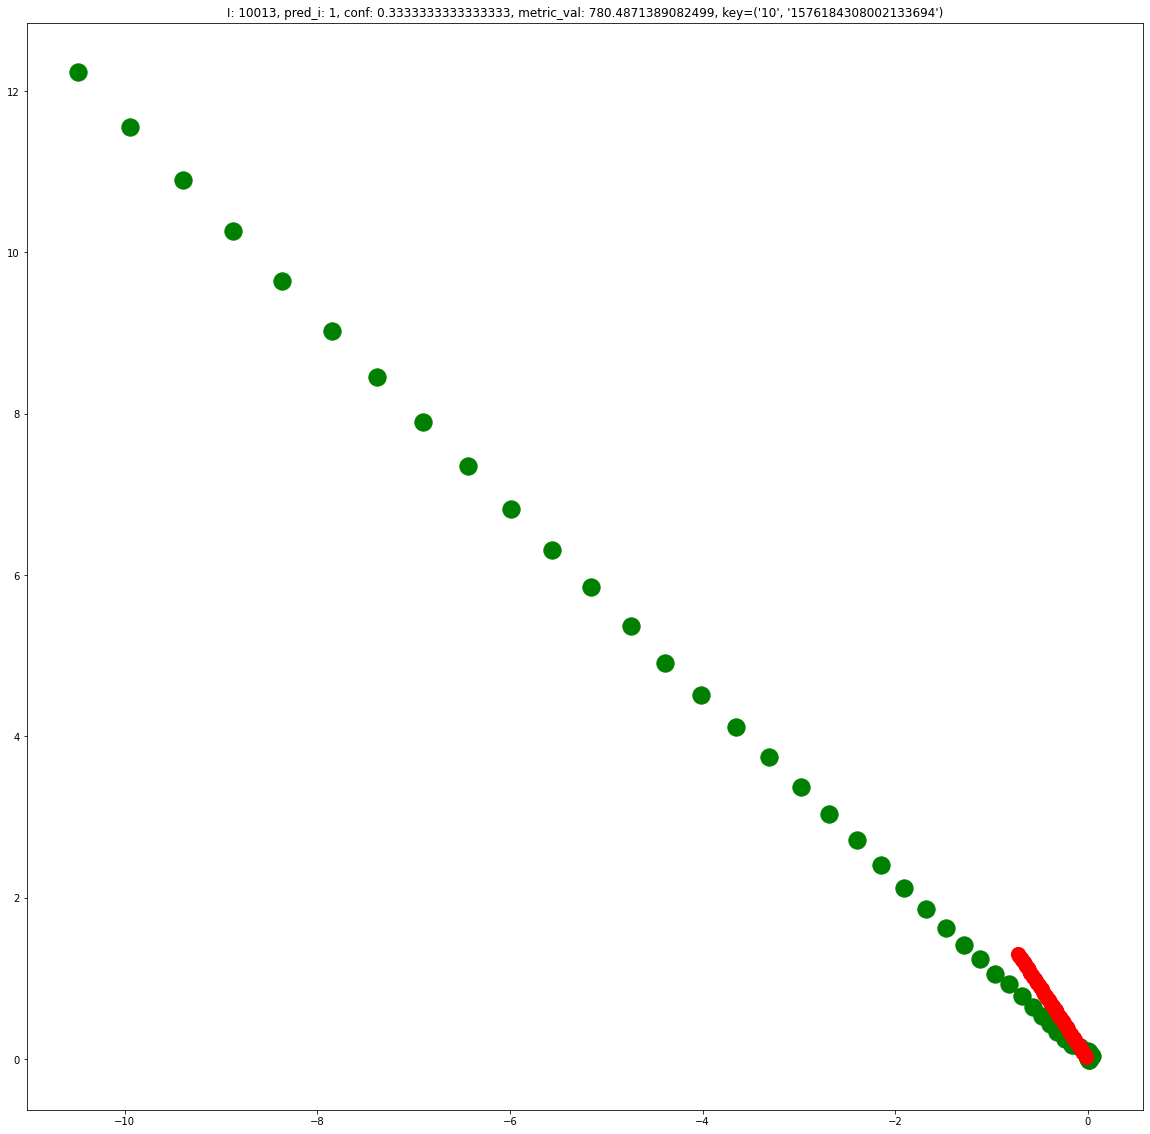

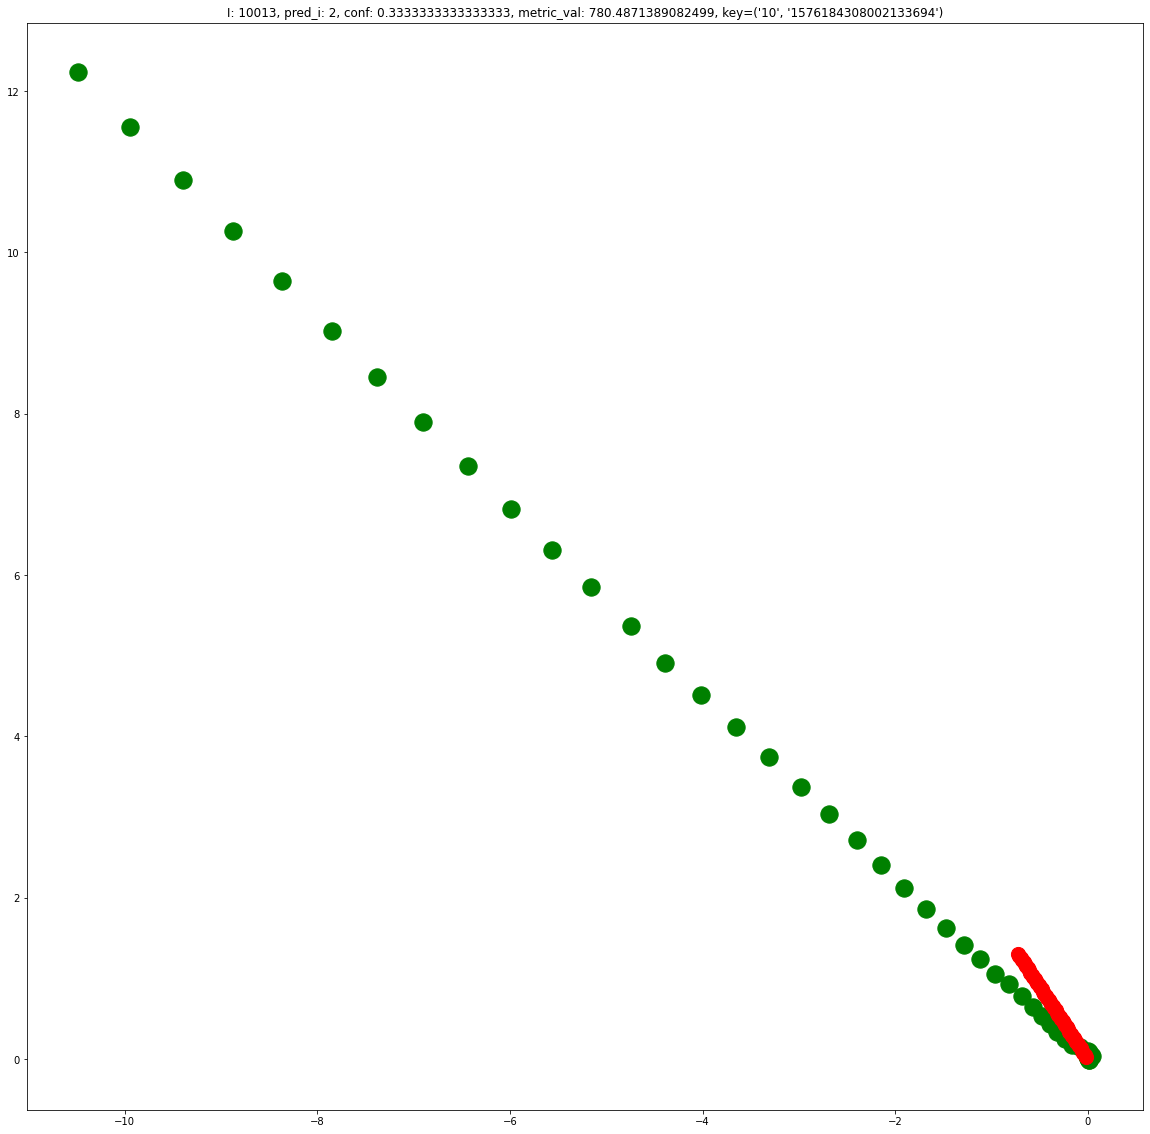

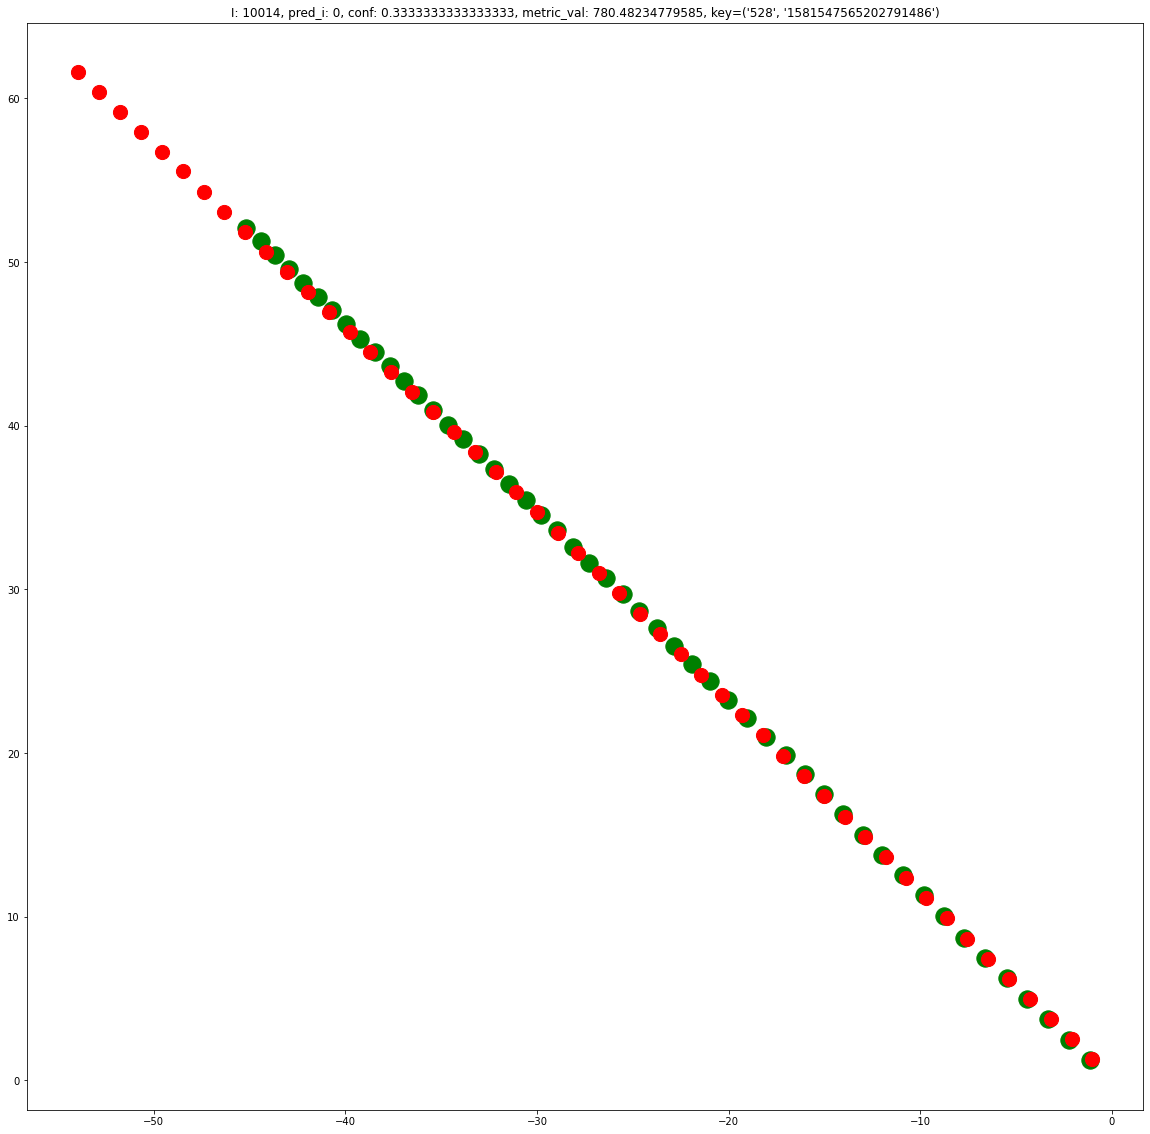

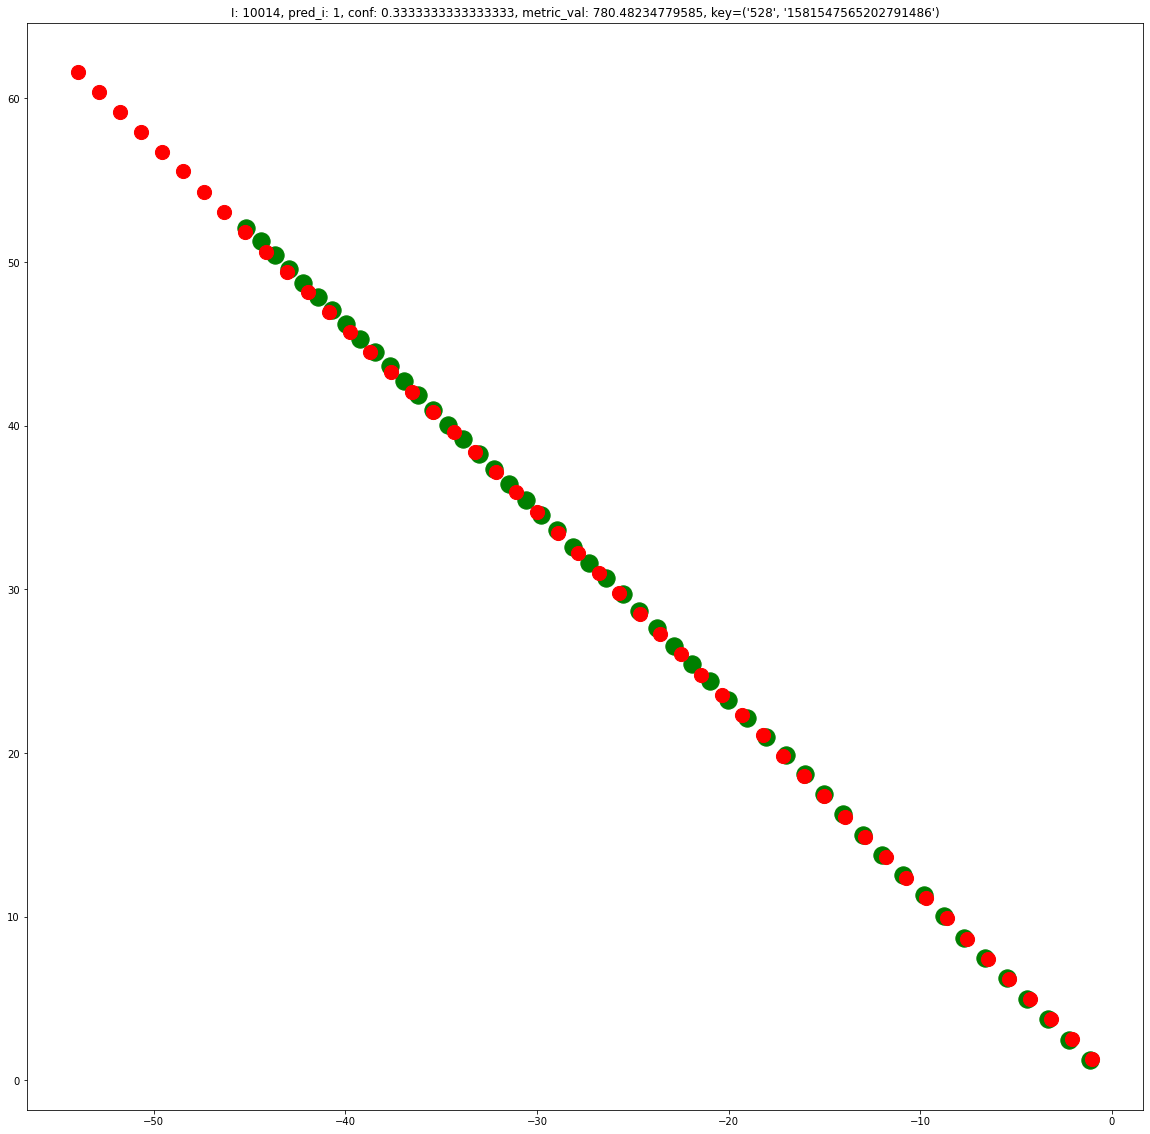

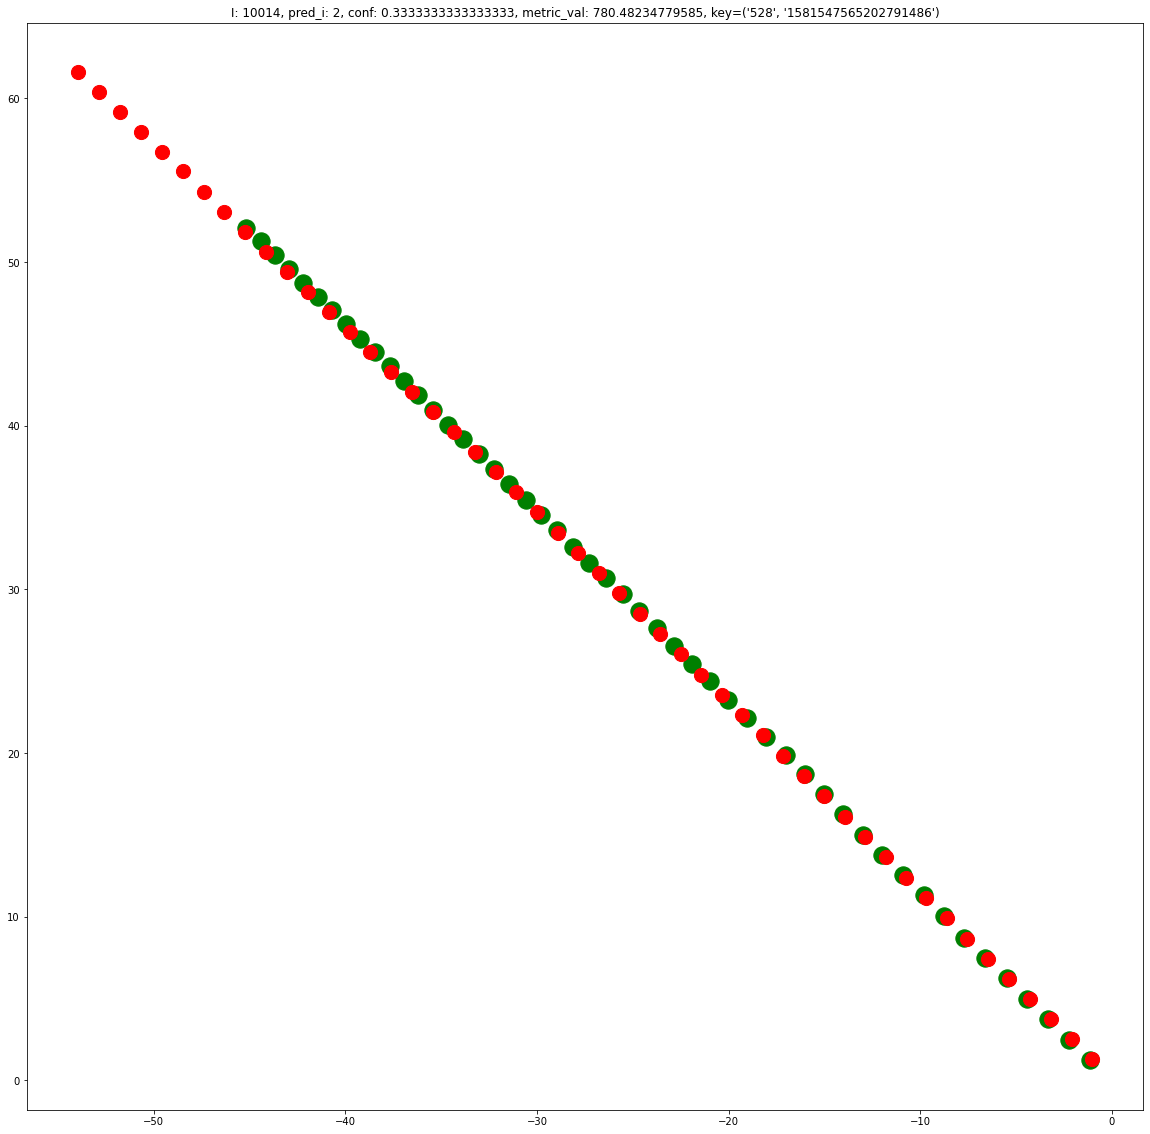

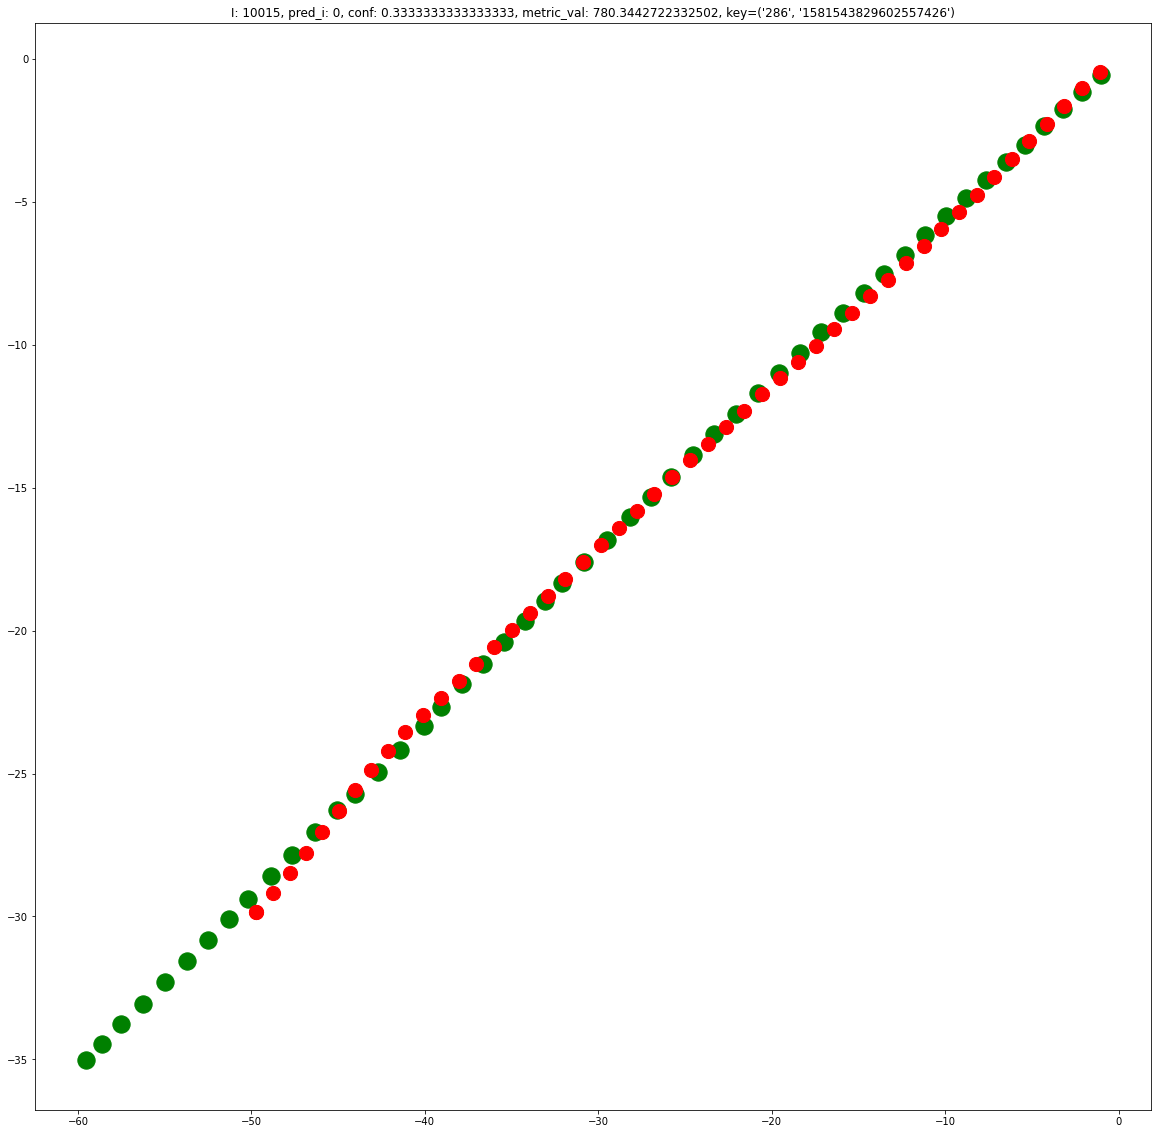

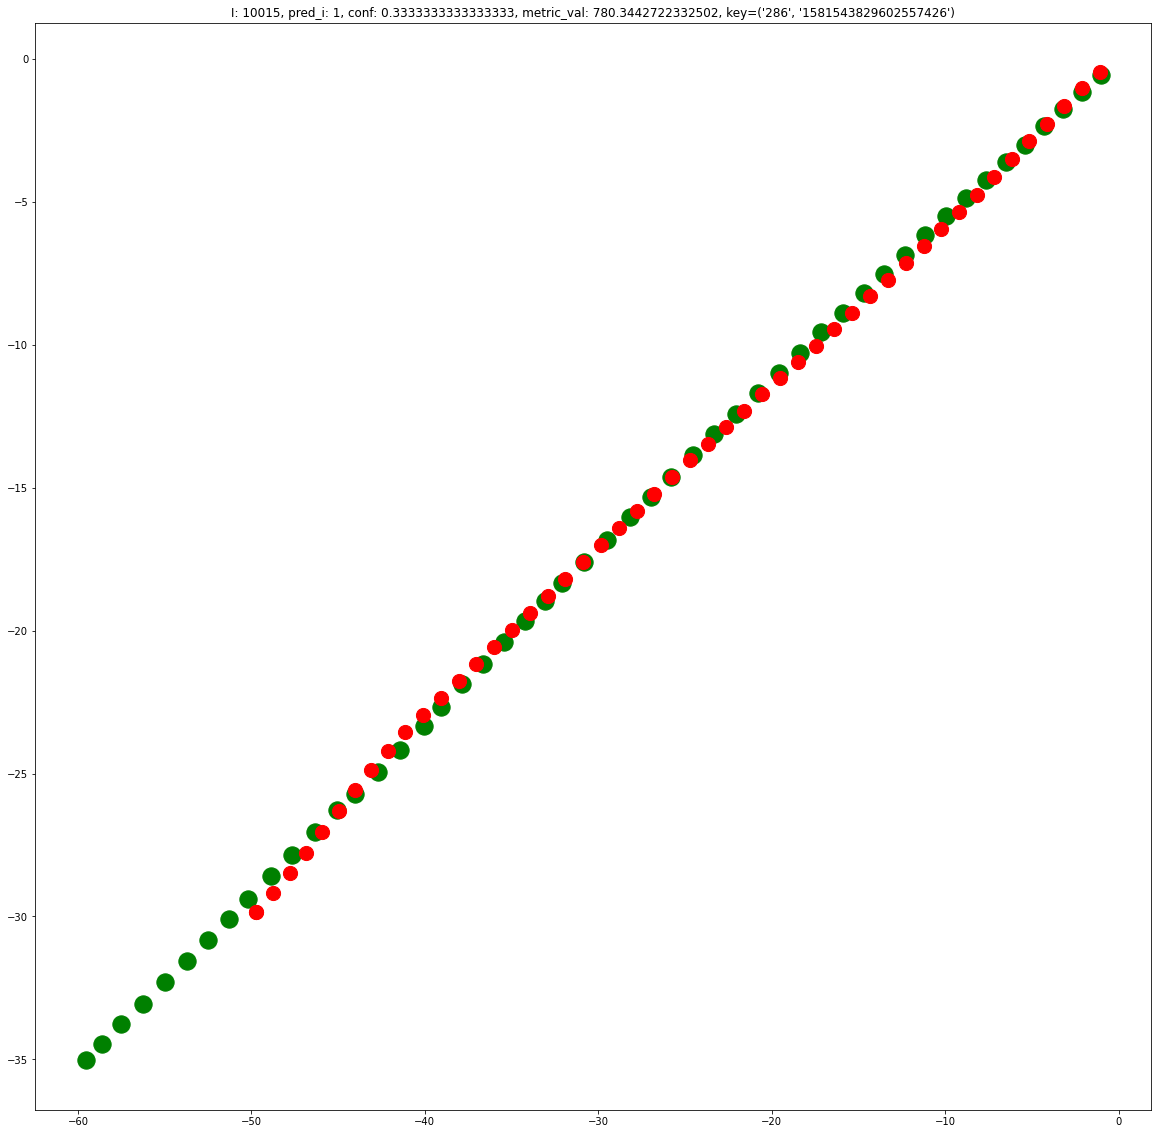

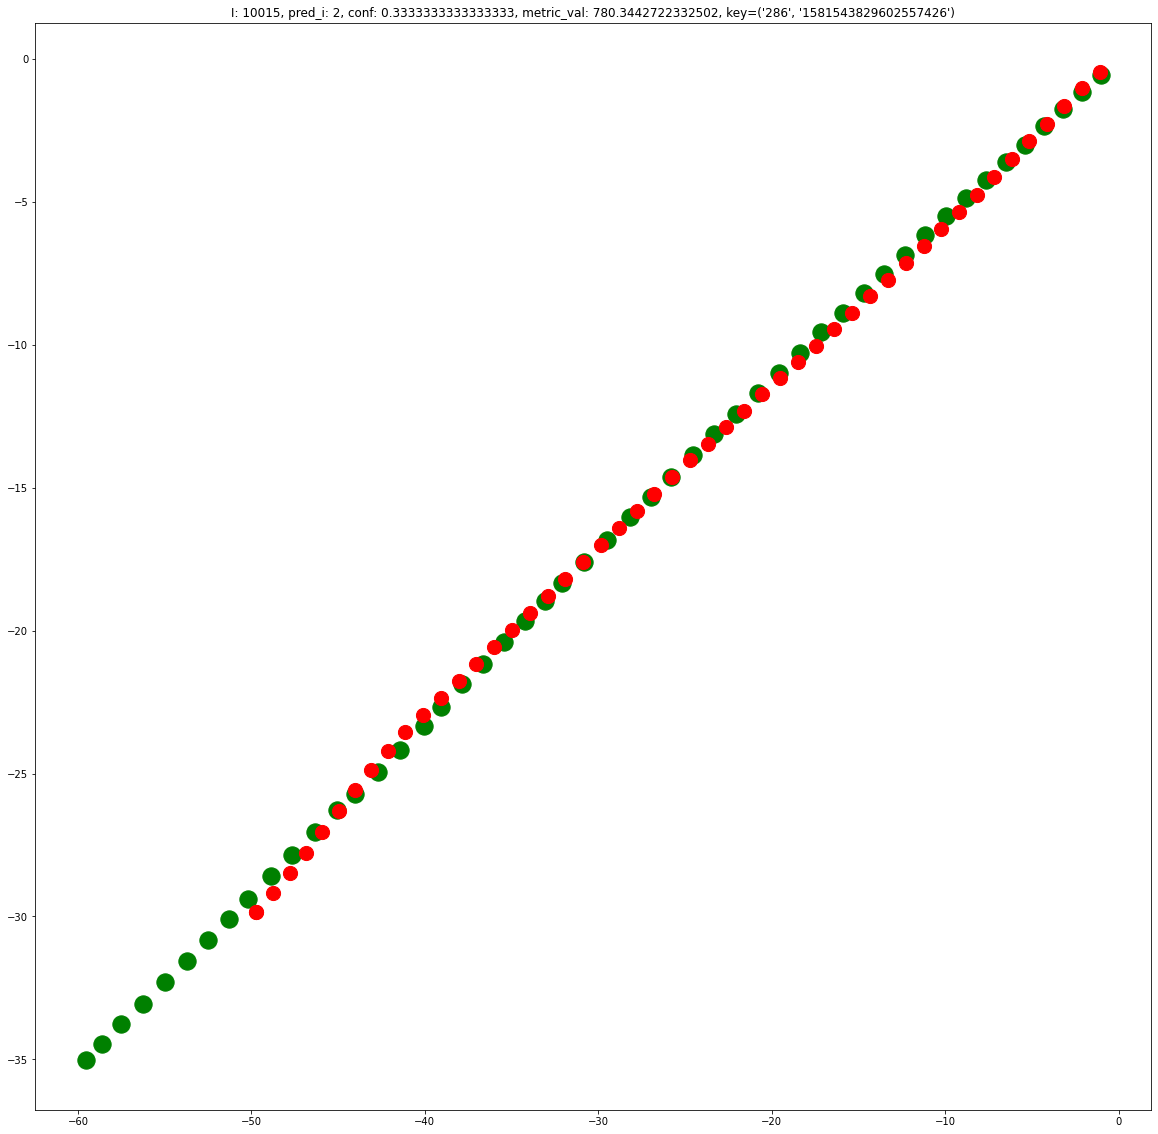

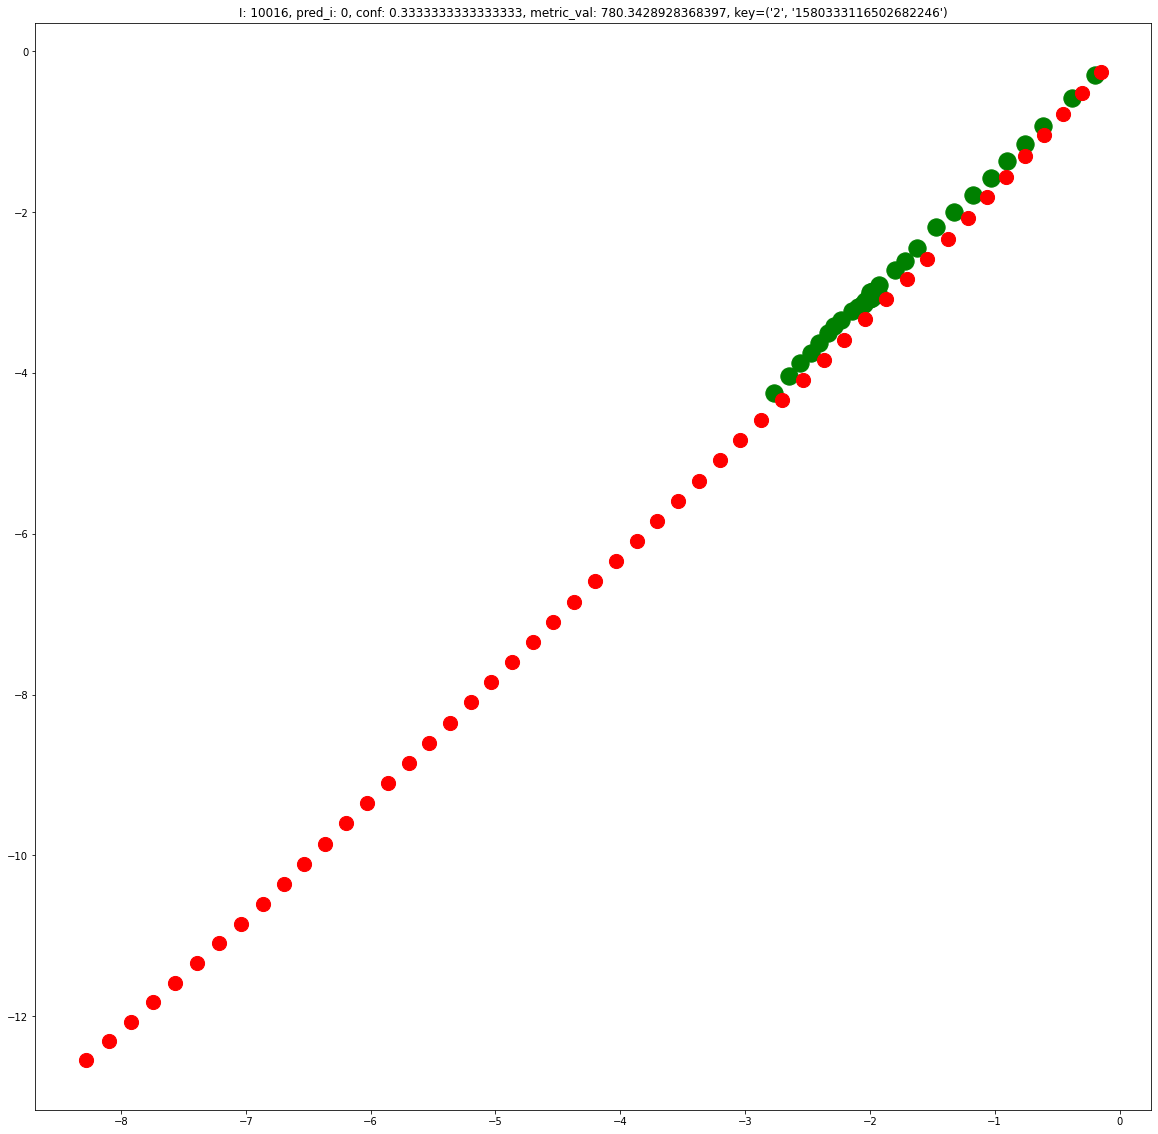

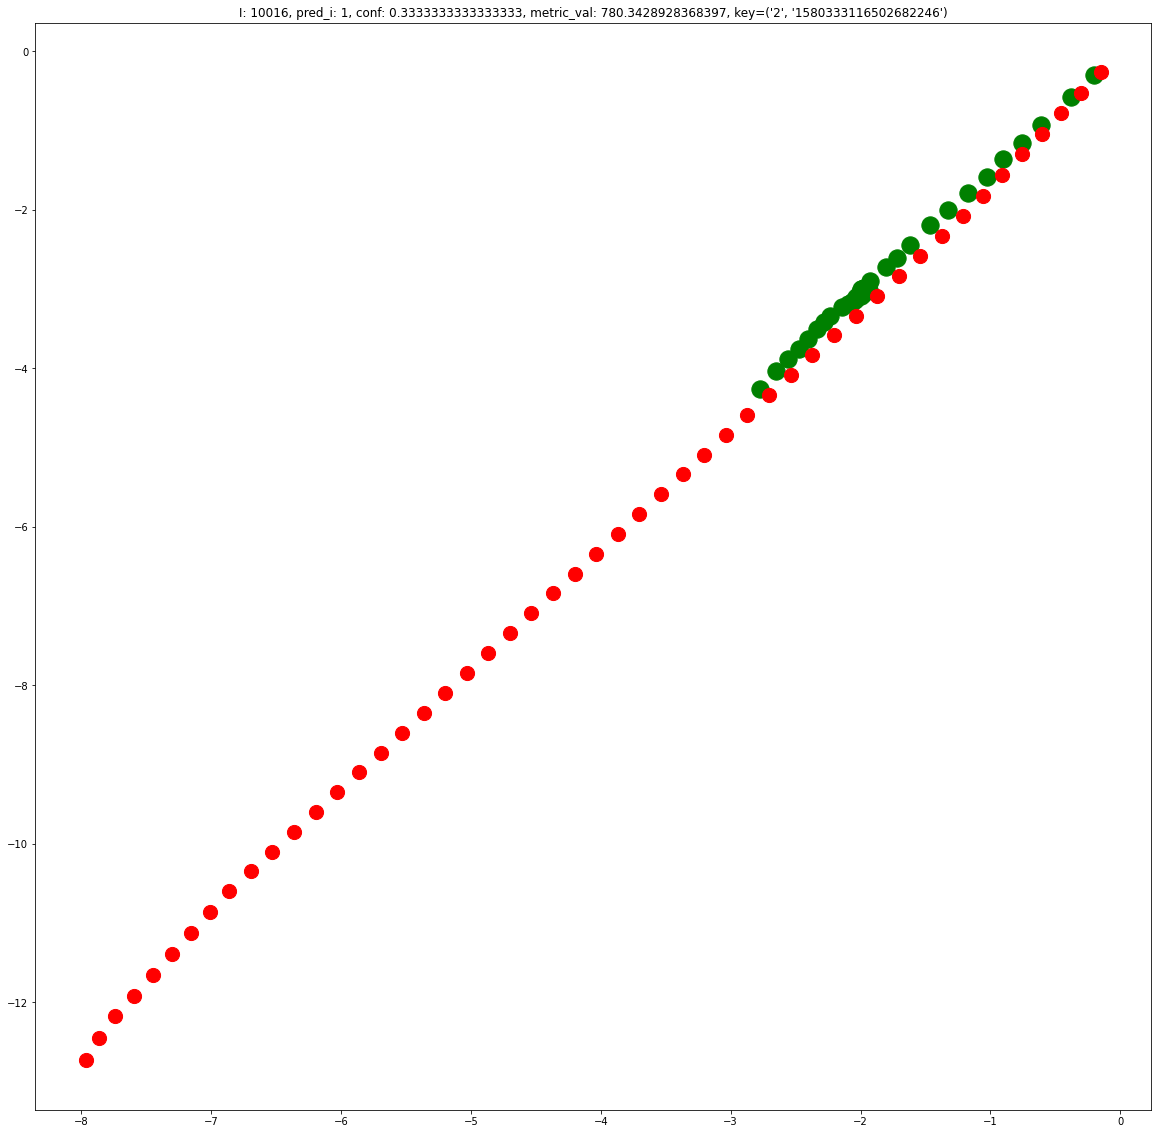

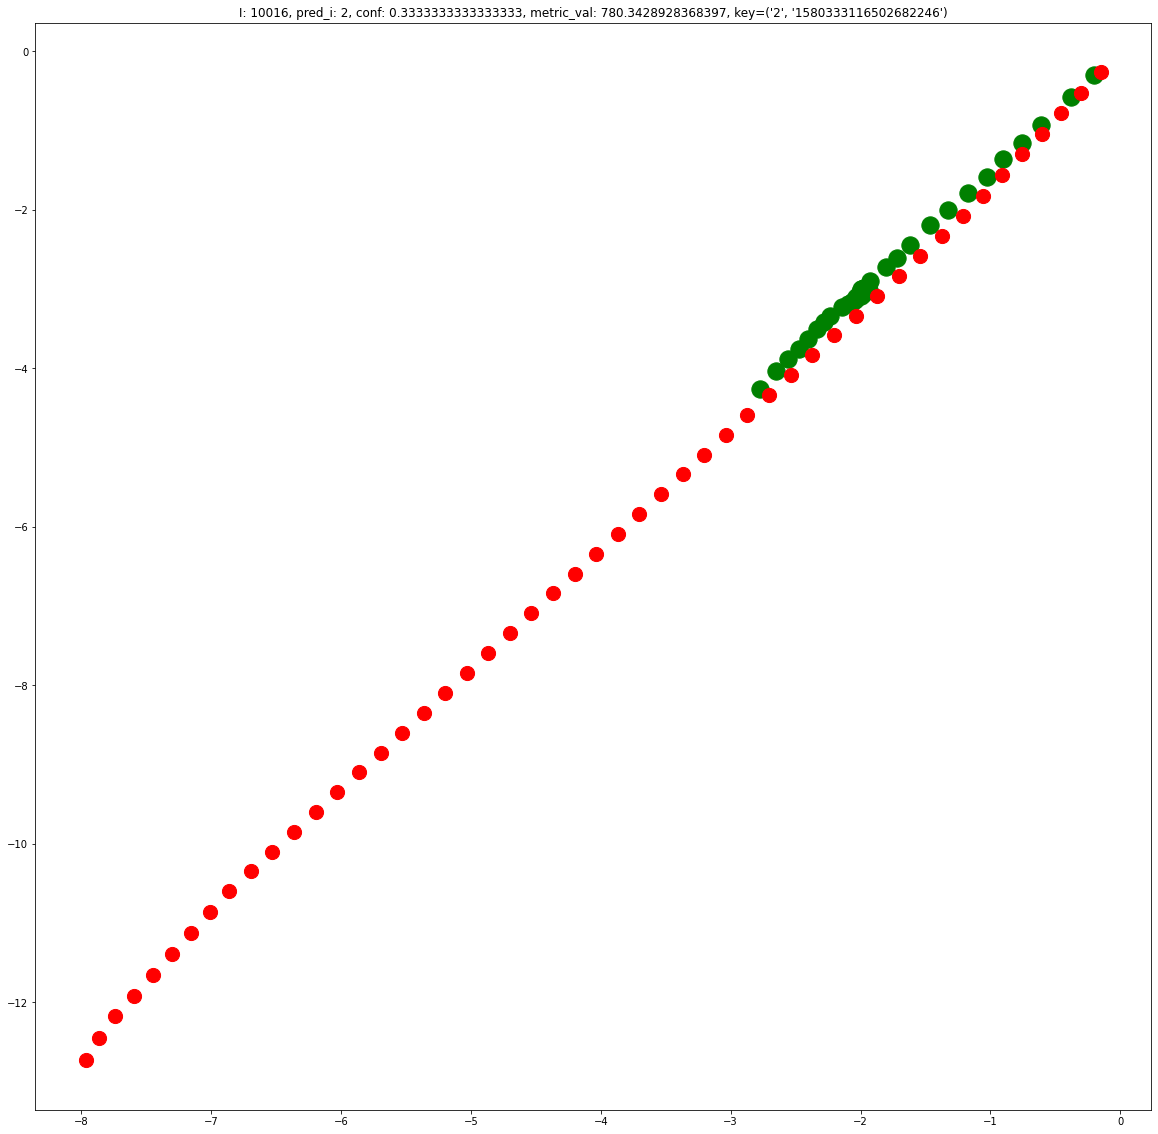

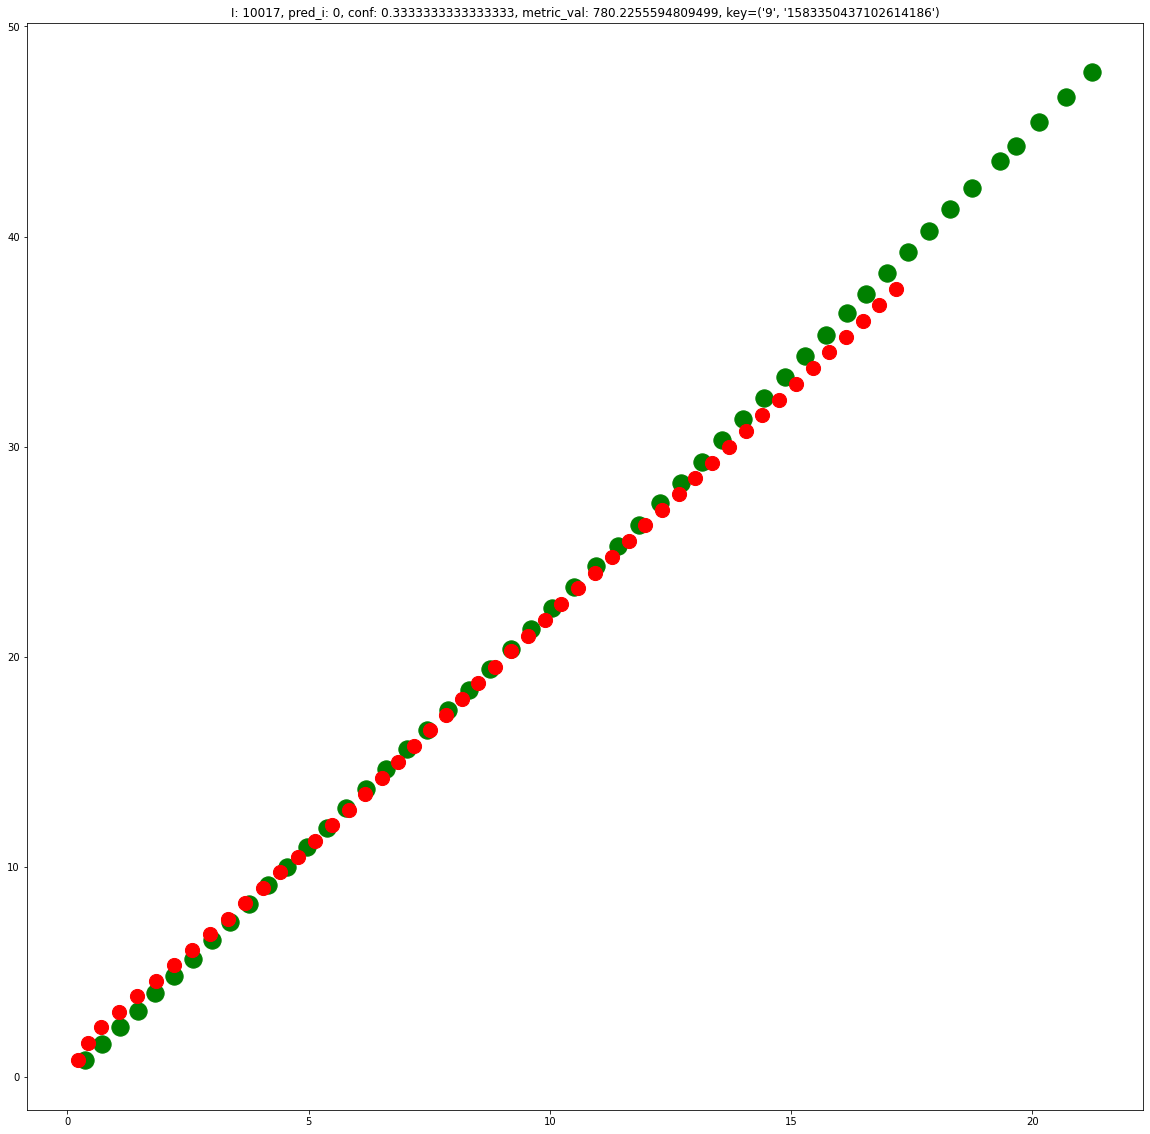

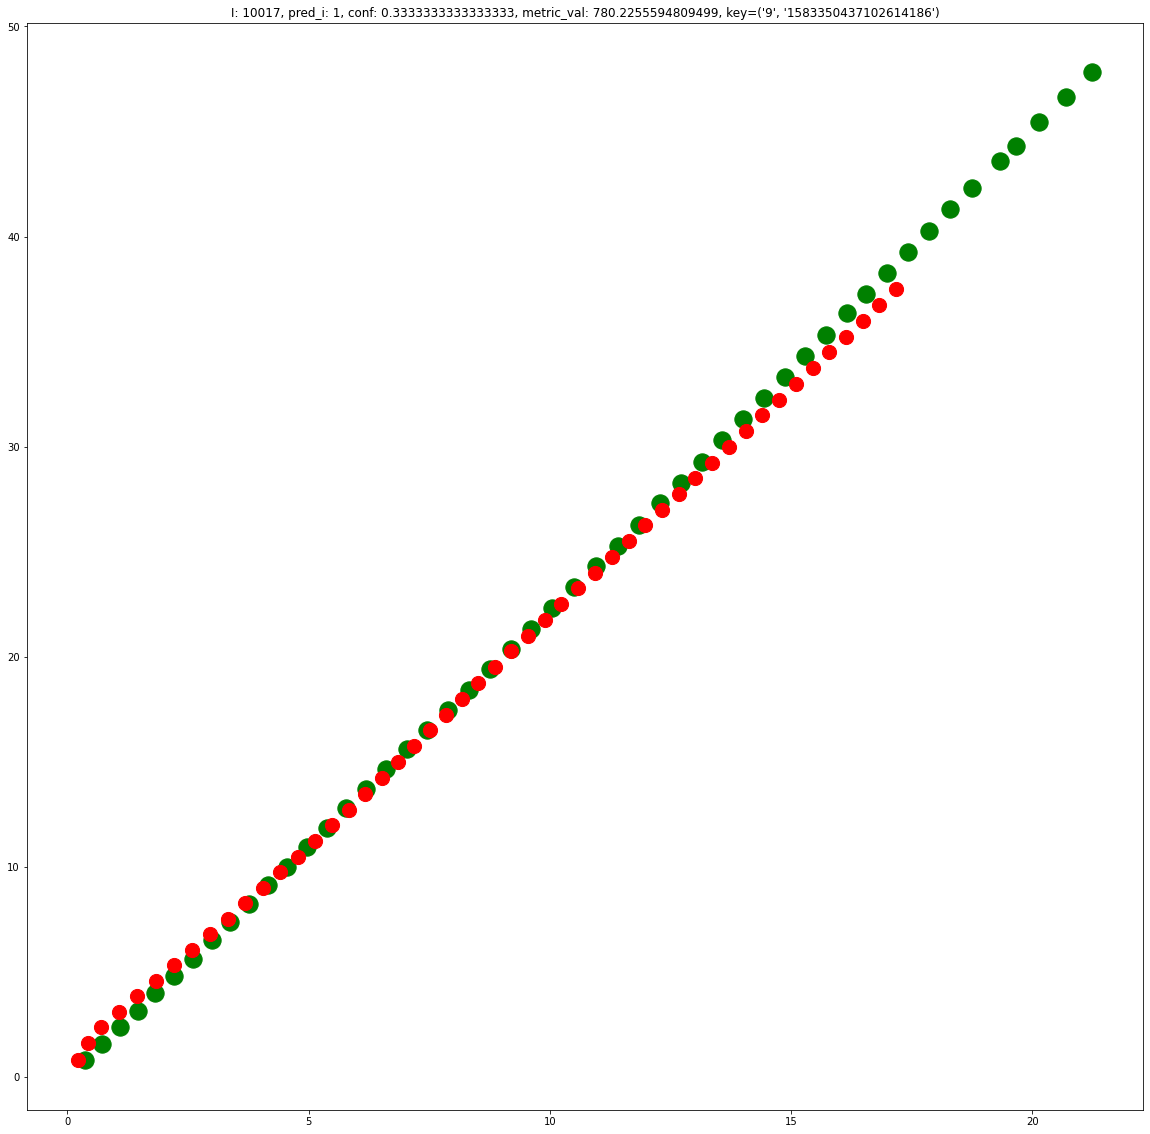

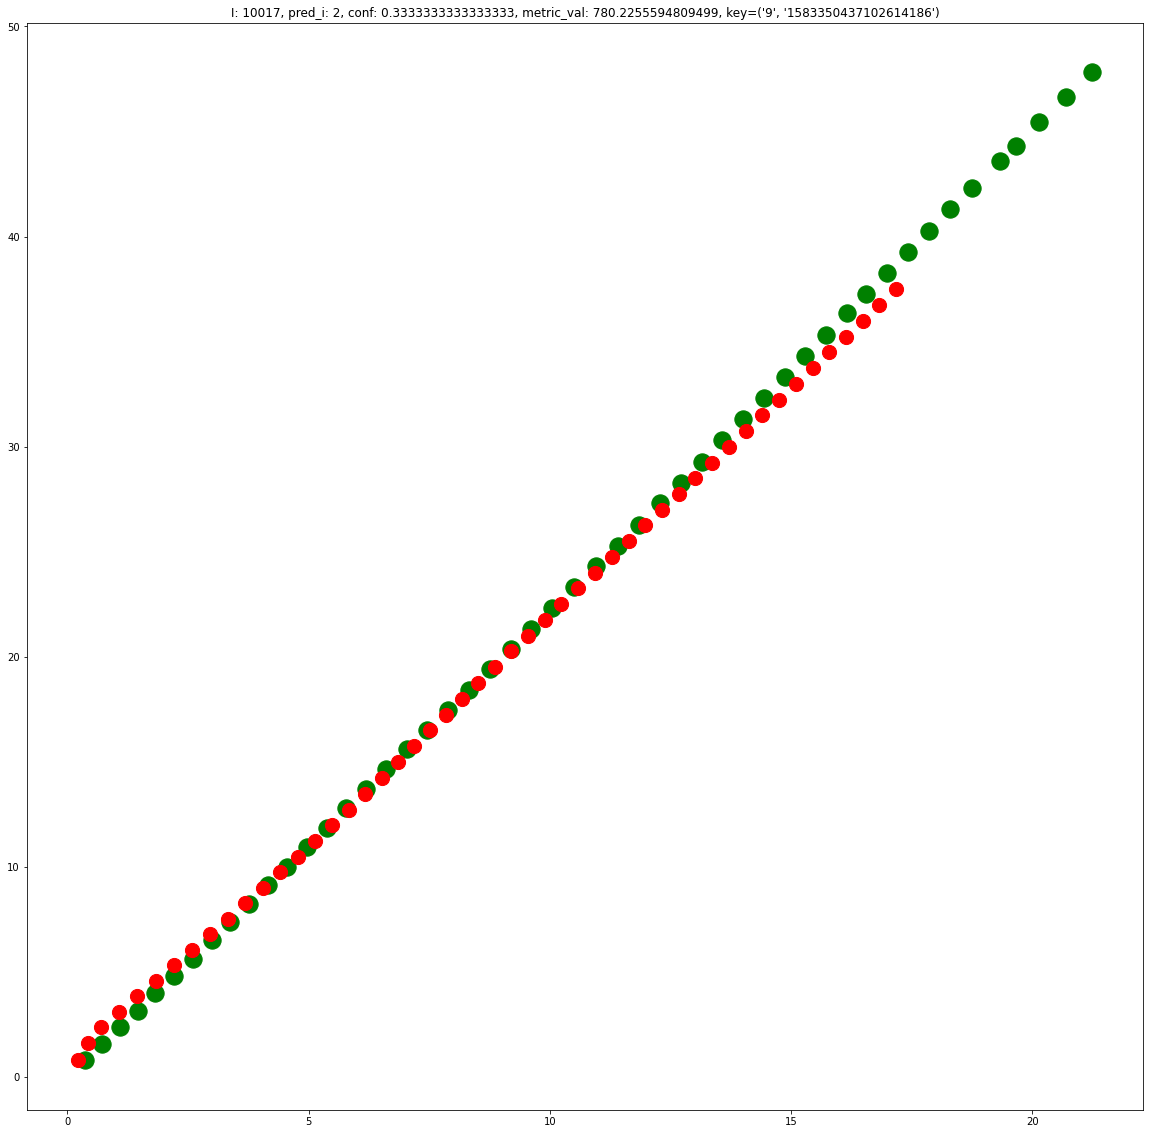

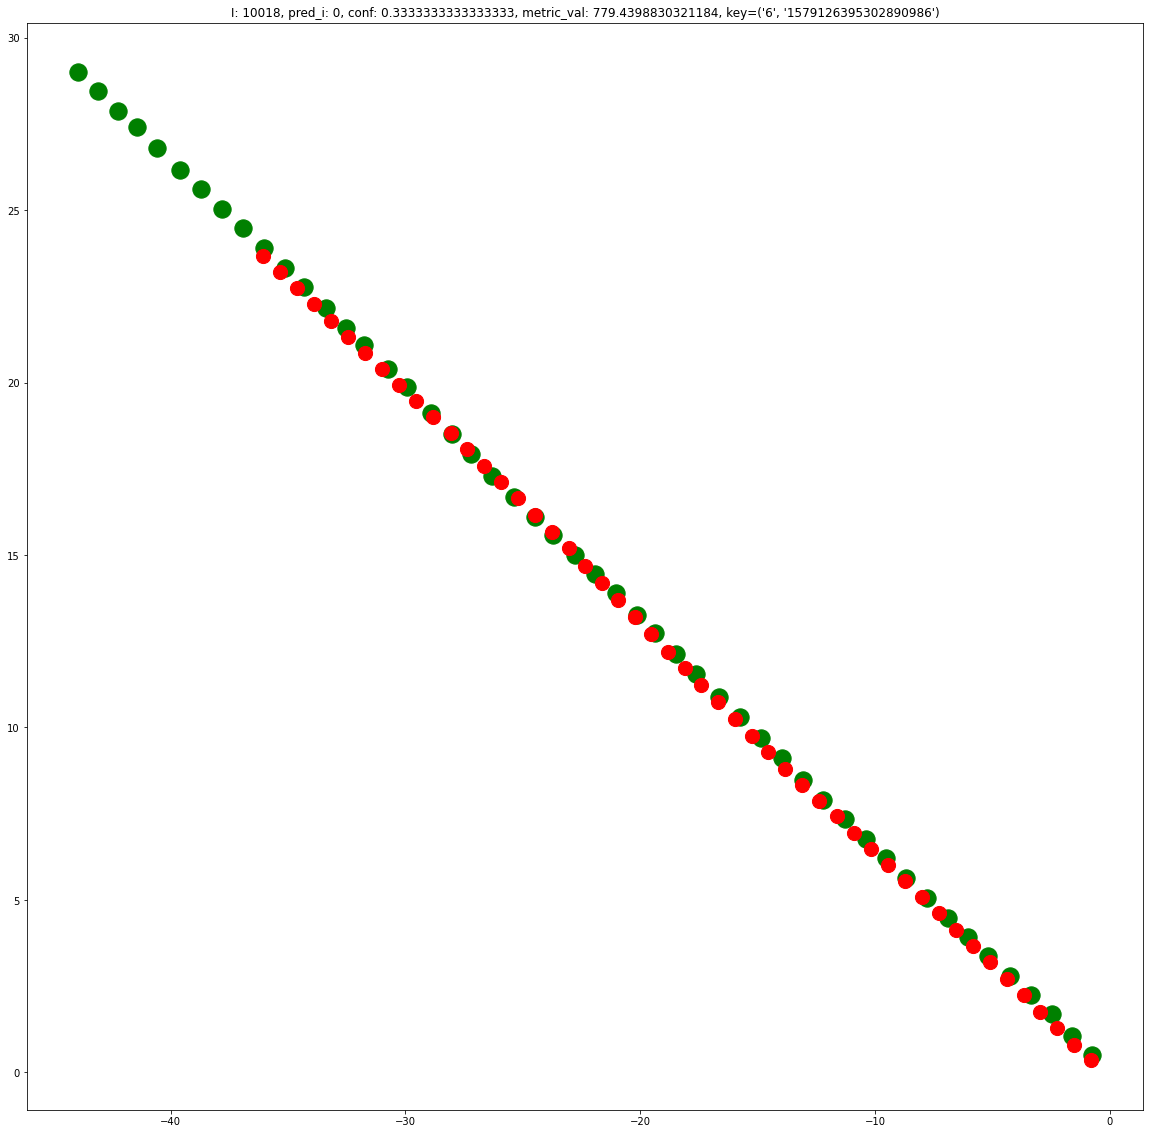

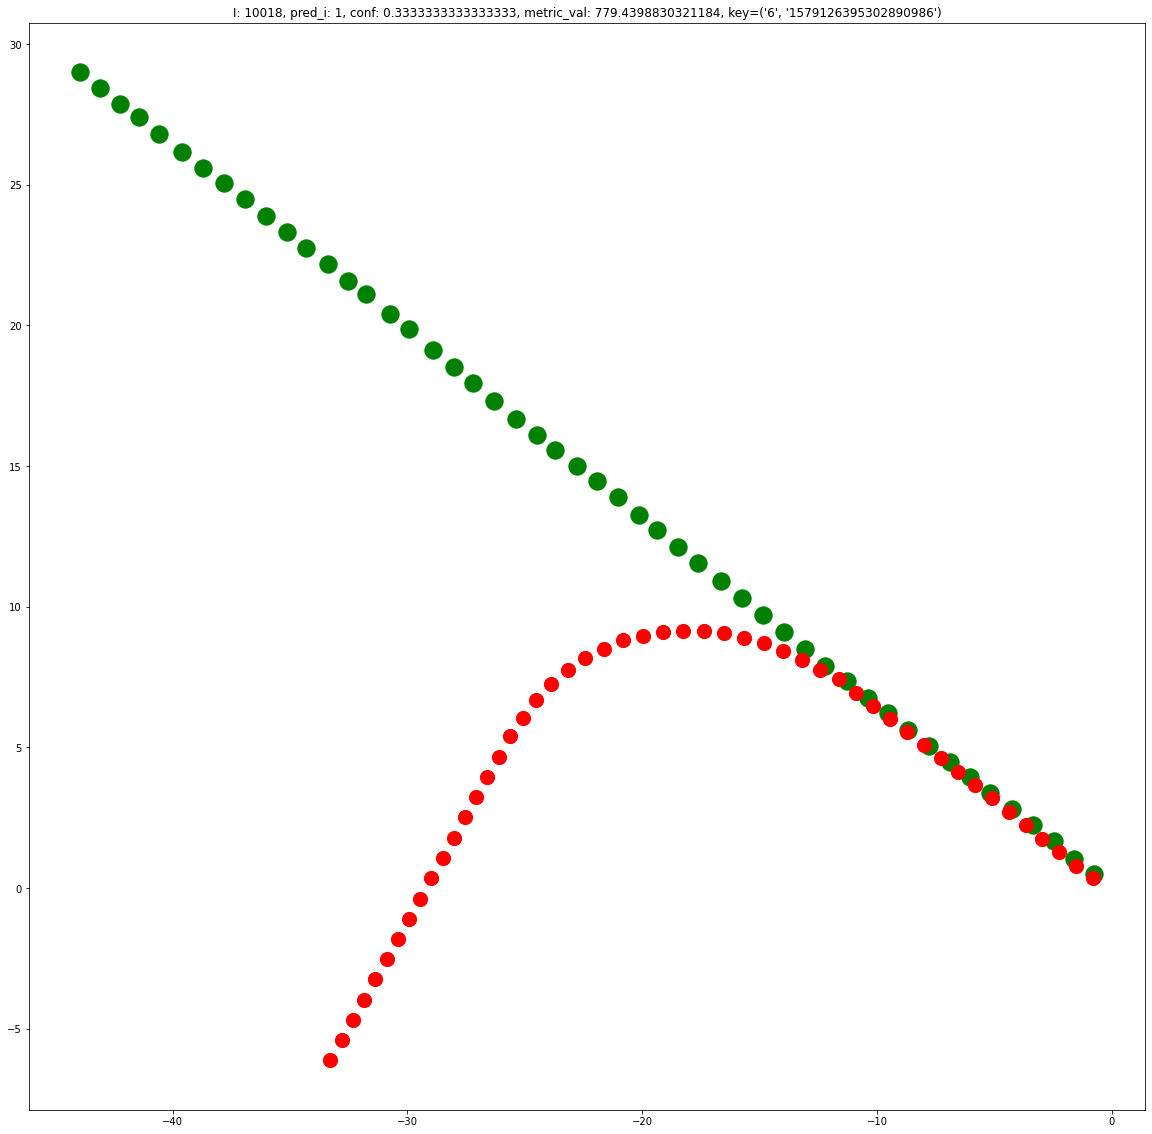

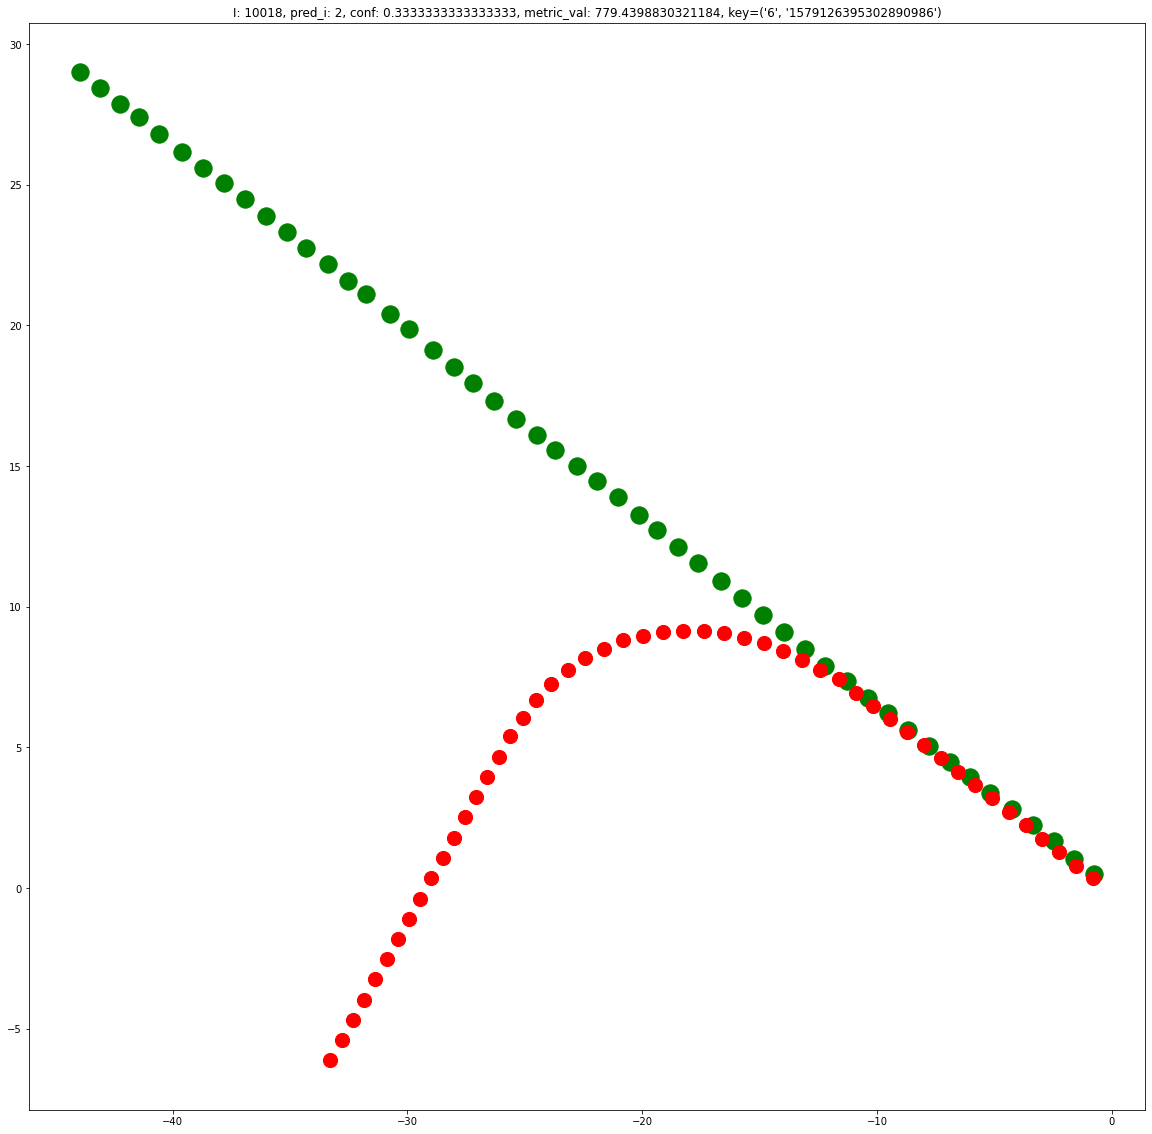

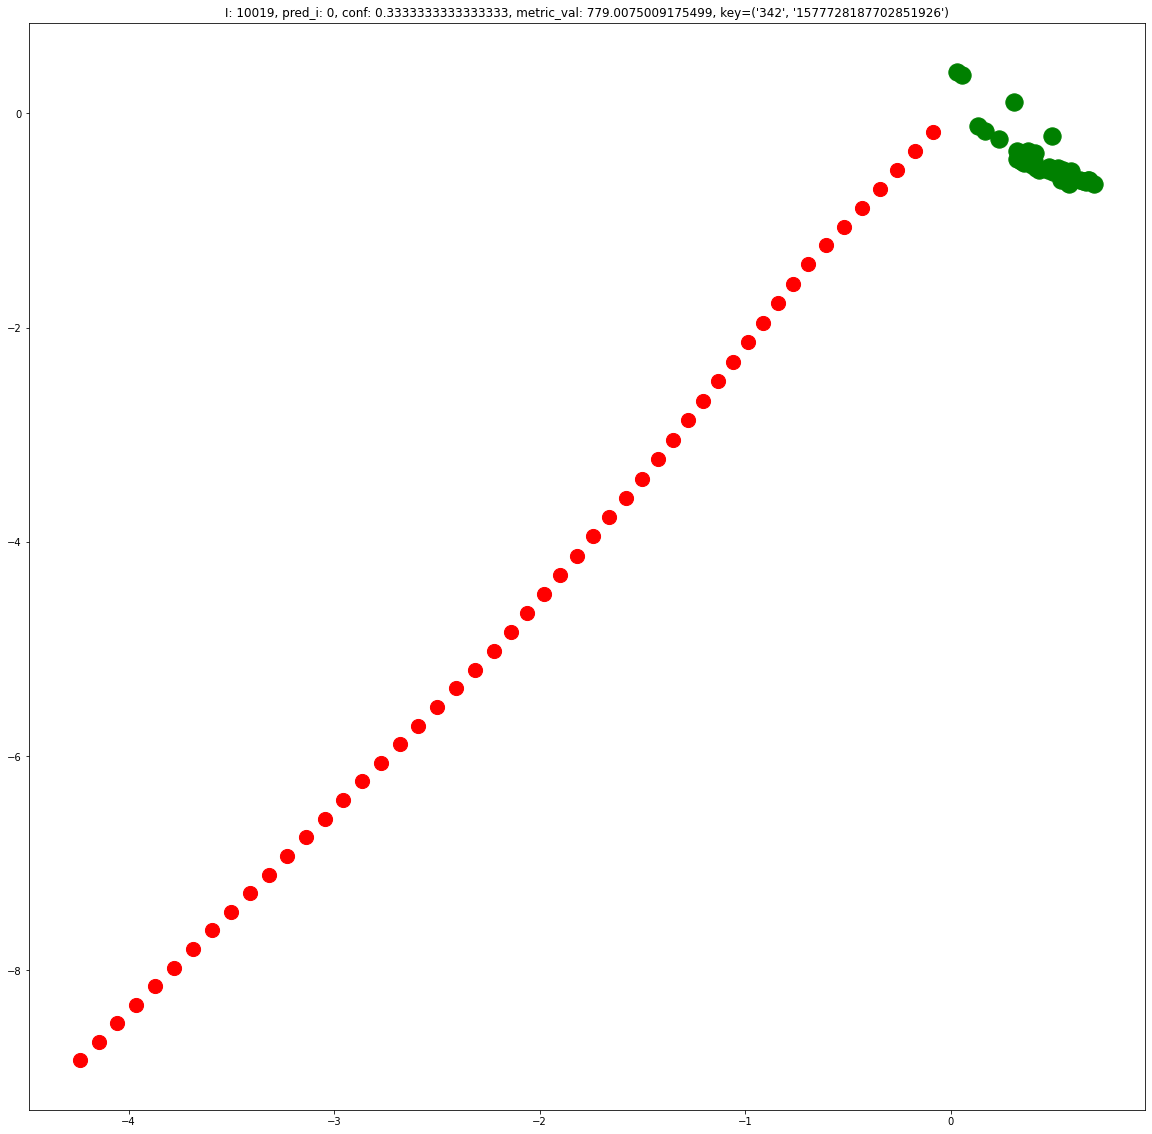

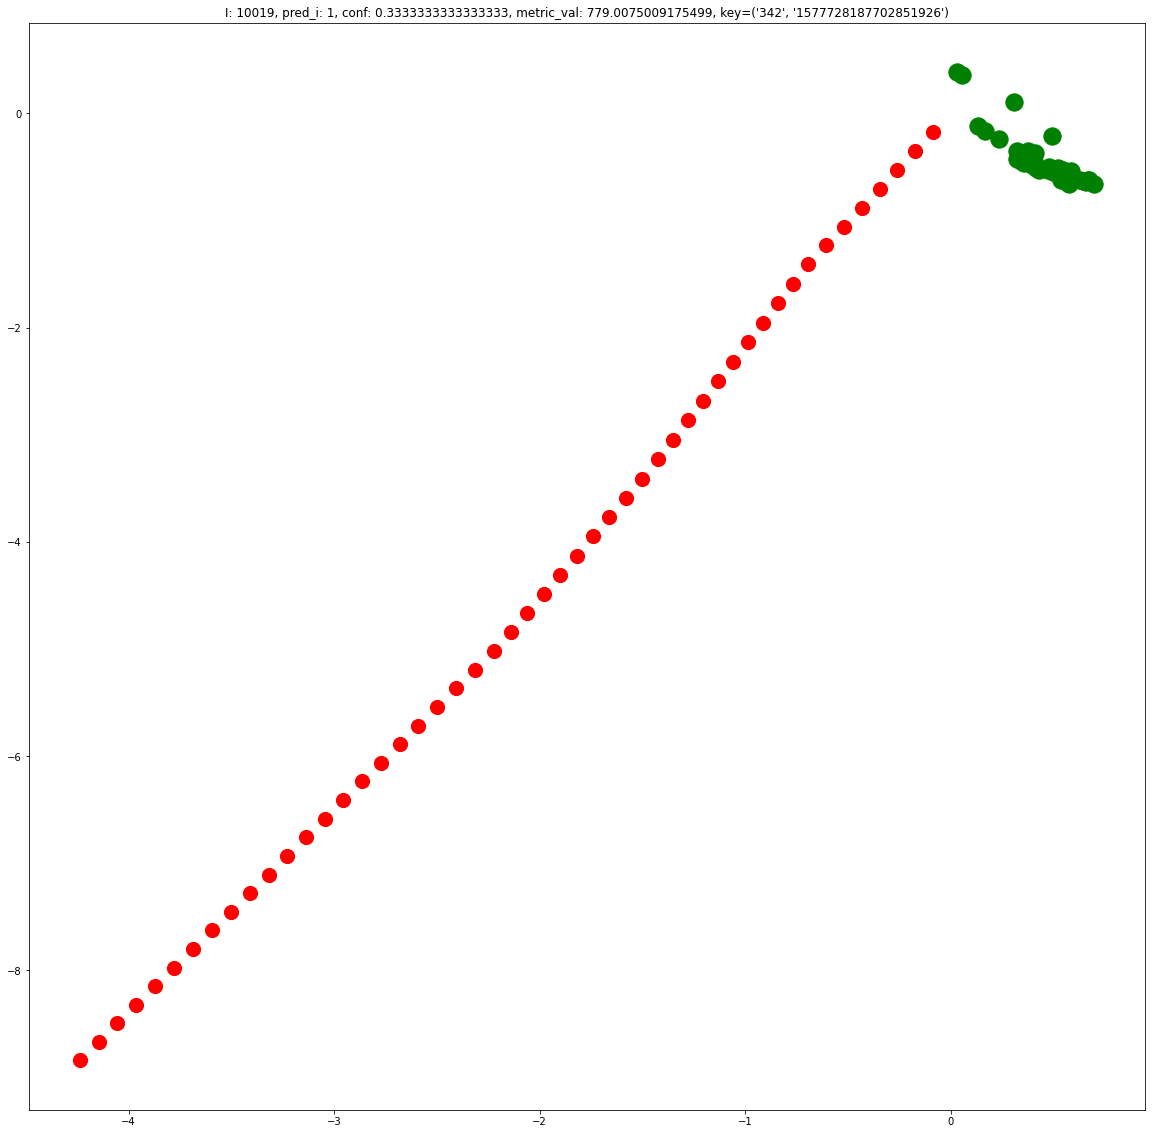

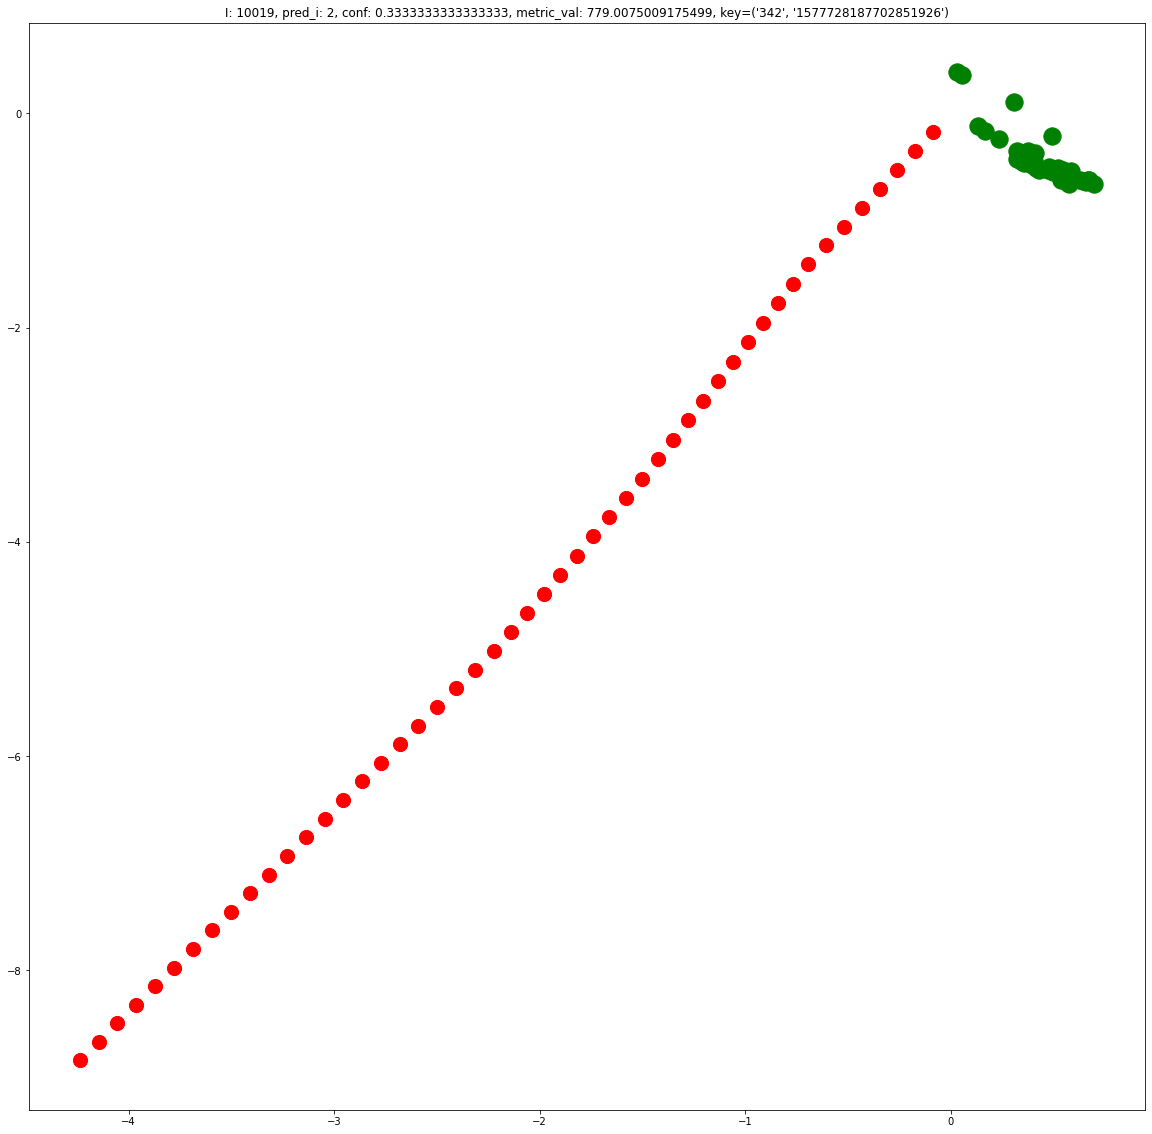

In [170]:
for i in range(10000, 10020):
    metric_val = metric_pred_gt_list_sorted[-i][0]
    availability = metric_pred_gt_list_sorted[-i][3]
    gt = metric_pred_gt_list_sorted[-i][2][availability == 1]
    preds = metric_pred_gt_list_sorted[-i][1]
    confs = metric_pred_gt_list_sorted[-i][4]
    key = metric_pred_gt_list_sorted[-i][5]
    for pred_i in range(3):
        if confs[pred_i] > 0:
            plt.figure(figsize=(20, 20))
            plt.scatter(gt[:, 0], gt[:, 1], c='green', s=300)
            pred = preds[pred_i][availability == 1]
            plt.scatter(pred[:, 0], pred[:, 1], c='red', s=200)
            plt.title(f'I: {i}, pred_i: {pred_i}, conf: {confs[pred_i]}, metric_val: {metric_val}, key={key}')
            print(key)

In [134]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    import os
    import sys

    if os.name == 'nt':
        from scripts.l5kit_modified.map_api import *
        from scripts.l5kit_modified.l5kit_modified import AgentDatasetModified, create_chopped_dataset

        os.environ["L5KIT_DATA_FOLDER"] = "input/"
    elif os.name == 'posix':
        from l5kit_modified.map_api import *
        from l5kit_modified.l5kit_modified import AgentDatasetModified, create_chopped_dataset


        os.environ["L5KIT_DATA_FOLDER"] = "../input/"
    else:
        sys.exit('Unsupported platform')

from l5kit.data import ChunkedDataset, LocalDataManager
import os
from random import sample
from scipy.spatial import KDTree
from collections import deque
from tqdm.auto import tqdm
from copy import deepcopy


############# CONSTANTS ###############
FILTER_AGENTS_THRESHOLD = 0.5
NUM_FRAMES_TO_CHOP = 100
NUM_FUTURE_FRAMES = 50
MIN_FUTURE_STEPS = 10
BATCH_SIZE = 256
NUM_PREDICTED_TRACKS = 3

world_to_ecef = np.asarray(
        [
            [8.46617444e-01, 3.23463078e-01, -4.22623402e-01, -2.69876744e06],
            [-5.32201938e-01, 5.14559352e-01, -6.72301845e-01, -4.29315158e06],
            [-3.05311332e-16, 7.94103464e-01, 6.07782600e-01, 3.85516476e06],
            [0.00000000e00, 0.00000000e00, 0.00000000e00, 1.00000000e00],
        ],
        dtype=np.float64,
    )

semantic_map_key = 'semantic_map/semantic_map.pb'

cfg = {"model_params": {"history_num_frames": 100,
                        "history_step_size": 1,
                        "future_num_frames": 50,
                        "future_step_size": 1},
       "raster_params": {"filter_agents_threshold": FILTER_AGENTS_THRESHOLD}}

dataset_path = 'scenes/sample.zarr'


################# HELPING FUNCTIONS ####################
def densify_sparse_segments(x_coordinates_seq_np, y_coordinates_seq_np, max_diff=0.01):
    # the operation is done just once, so performing it naively
    assert len(x_coordinates_seq_np) == len(y_coordinates_seq_np), "Different lens of x/y coordinates"
    x_final_seq_np = np.array([])
    y_final_seq_np = np.array([])
    for i in range(0, len(x_coordinates_seq_np) - 1):
        abs_diff = np.hypot(x_coordinates_seq_np[i + 1] - x_coordinates_seq_np[i],
                            y_coordinates_seq_np[i + 1] - y_coordinates_seq_np[i])
        if abs_diff > max_diff:
            n_interpolated_points = int(np.ceil(abs_diff / max_diff)) + 1
            x_points_to_append = np.interp(np.linspace(0, 1, n_interpolated_points),
                                           np.arange(2), x_coordinates_seq_np[i:i + 2])

            y_points_to_append = np.interp(np.linspace(0, 1, n_interpolated_points),
                                           np.arange(2), y_coordinates_seq_np[i:i + 2])

        else:
            x_points_to_append = x_coordinates_seq_np[i:i + 2]
            y_points_to_append = y_coordinates_seq_np[i:i + 2]
        if i > 0:
            x_points_to_append = x_points_to_append[1:]
            y_points_to_append = y_points_to_append[1:]
        x_final_seq_np = np.append(x_final_seq_np, x_points_to_append)
        y_final_seq_np = np.append(y_final_seq_np, y_points_to_append)
    return x_final_seq_np, y_final_seq_np


def sparsify(xy_seq_np, final_min_coord_dist_metr=2):
    prev_point = xy_seq_np[0]
    final_list = [prev_point]
    for i in range(1, len(xy_seq_np)):
        delta_x = prev_point[0] - xy_seq_np[i, 0]
        delta_y = prev_point[1] - xy_seq_np[i, 1]
        dist = np.hypot(delta_x, delta_y)
        if dist >= final_min_coord_dist_metr:
            final_list.append(xy_seq_np[i])
            prev_point = xy_seq_np[i]
    if np.any(prev_point != xy_seq_np[-1]):
        final_list.append(xy_seq_np[-1])
    return np.array(final_list)


def get_lane_cumul_distances(xy_seq_np):
    idx_2_cumul_distances = [[] for _ in range(len(xy_seq_np))]

    def get_dist(idx_0, idx_1):
        deltas = xy_seq_np[idx_0] - xy_seq_np[idx_1]
        return np.hypot(deltas[0], deltas[1])

    for i in range(len(xy_seq_np)):
        # computing backward along the lane
        dist_backward = 0
        backward_dists = []
        for k in range(i - 1, -1, -1):
            segment_len = get_dist(k, k + 1)
            dist_backward += segment_len
            backward_dists.append(dist_backward)
        idx_2_cumul_distances[i].extend(reversed(backward_dists))
        idx_2_cumul_distances[i].append(0)

        # computing forward along the lane
        dist_forward = 0
        for k in range(i + 1, len(xy_seq_np), 1):
            segment_len = get_dist(k, k - 1)
            dist_forward += segment_len
            idx_2_cumul_distances[i].append(dist_forward)
    return idx_2_cumul_distances


def get_helping_angle(vector_1):
    vector_0 = np.array([1, 0])
    angle_cos = np.dot(vector_0, vector_1) / np.linalg.norm(vector_1)
    alpha = np.arccos(angle_cos)
    if vector_1[1] < 0:
        alpha = 2 * np.pi - alpha
    return alpha


def get_lane_segments_sin_cosine(xy_seq_np):
    idx_2_sin_cos_forward = []
    for i in range(len(xy_seq_np) - 1):
        vector_1 = xy_seq_np[i + 1] - xy_seq_np[i]
        helping_angle = get_helping_angle(vector_1)
        idx_2_sin_cos_forward.append((np.sin(helping_angle), np.cos(helping_angle)))
    idx_2_sin_cos_forward.append((np.nan, np.nan))

    idx_2_sin_cos_backward = []
    for i in range(len(xy_seq_np) - 1, 0, -1):
        vector_1 = xy_seq_np[i - 1] - xy_seq_np[i]
        helping_angle = get_helping_angle(vector_1)
        idx_2_sin_cos_backward.append((np.sin(helping_angle), np.cos(helping_angle)))
    idx_2_sin_cos_backward.append((np.nan, np.nan))
    return idx_2_sin_cos_forward, list(reversed(idx_2_sin_cos_backward))


################# NAIVE LANE FOLLOWER ##################
class ConstantSpeedLaneFollower:

    def __init__(self, dataset_path=dataset_path, semantic_map_key=semantic_map_key,
                 world_to_ecef=world_to_ecef, cfg=cfg):
        dm = LocalDataManager(None)
        eval_zarr = ChunkedDataset(dm.require(dataset_path)).open()
        self.dataset = AgentDatasetModified(cfg, eval_zarr)
        semantic_map_path = dm.require(semantic_map_key)
        self.proto_API = MapAPI(semantic_map_path, world_to_ecef)
        self.lanes_crosswalks = self.precompute_map_elements()
        self.id_2_idx = {lane_id: i for i, lane_id in enumerate(self.lanes_crosswalks['lanes']['ids'])}
        self.lane_adj_list_forward, self.lane_adj_list_backward = self.precompute_lane_adjacencies()
        all_center_coords = np.concatenate(self.lanes_crosswalks['lanes']['center_line'], axis=0)
        self.kd_tree = KDTree(all_center_coords)

        self.kd_idx_2_lane_id_idx = []
        for lane_id, center_line in zip(self.lanes_crosswalks['lanes']['ids'], self.lanes_crosswalks['lanes']['center_line']):
            next_entries = [(lane_id, i) for i in range(len(center_line))]
            self.kd_idx_2_lane_id_idx.extend(next_entries)

    def precompute_map_elements(self):
        lanes_ids = []
        crosswalks_ids = []
        center_line_coords = []
        xy_left_coords = []
        xy_right_coords = []
        xy_left_coords_ = []
        xy_right_coords_ = []

        lane_point_idx_2_cumul_distances = []
        lane_point_idx_2_sin_cos_forward = []
        lane_point_idx_2_sin_cos_backward = []

        lanes_bounds = np.empty((0, 2, 2), dtype=np.float)  # [(X_MIN, Y_MIN), (X_MAX, Y_MAX)]
        crosswalks_bounds = np.empty((0, 2, 2), dtype=np.float)  # [(X_MIN, Y_MIN), (X_MAX, Y_MAX)]

        for element in tqdm(self.proto_API):
            element_id = MapAPI.id_as_str(element.id)

            if self.proto_API.is_lane(element):
                lane = self.proto_API.get_lane_coords(element_id)
                x_min = min(np.min(lane["xyz_left"][:, 0]), np.min(lane["xyz_right"][:, 0]))
                y_min = min(np.min(lane["xyz_left"][:, 1]), np.min(lane["xyz_right"][:, 1]))
                x_max = max(np.max(lane["xyz_left"][:, 0]), np.max(lane["xyz_right"][:, 0]))
                y_max = max(np.max(lane["xyz_left"][:, 1]), np.max(lane["xyz_right"][:, 1]))

                x_left_, y_left_ = densify_sparse_segments(lane["xyz_left"][:, 0],
                                                           lane["xyz_left"][:, 1])
                x_right_, y_right_ = densify_sparse_segments(lane["xyz_right"][:, 0],
                                                             lane["xyz_right"][:, 1])

                if len(x_left_) == len(x_right_):
                    x_right = x_right_
                    x_left = x_left_

                    y_right = y_right_
                    y_left = y_left_

                elif len(x_left_) < len(x_right_):
                    x_right = x_right_
                    x_left = np.interp(np.linspace(0, len(x_left_) - 1, len(x_right)),
                                       np.arange(len(x_left_)), x_left_)

                    y_right = y_right_
                    y_left = np.interp(np.linspace(0, len(y_left_) - 1, len(y_right)),
                                       np.arange(len(y_left_)), y_left_)

                elif len(x_left_) > len(x_right_):
                    x_left = x_left_
                    x_right = np.interp(np.linspace(0, len(x_right_) - 1, len(x_left)),
                                        np.arange(len(x_right_)), x_right_)

                    y_left = y_left_
                    y_right = np.interp(np.linspace(0, len(y_right_) - 1, len(y_left)),
                                        np.arange(len(y_right_)), y_right_)
                else:
                    raise Exception('Bug in lane length comparison')
                assert len(x_left) == len(x_right)

                center_line = np.transpose(np.vstack(((x_left + x_right) / 2,
                                                      (y_left + y_right) / 2)))
                center_line = sparsify(center_line)

                lanes_bounds = np.append(lanes_bounds, np.asarray([[[x_min, y_min], [x_max, y_max]]]), axis=0)
                lanes_ids.append(element_id)
                center_line_coords.append(center_line)
                xy_left_coords.append(lane["xyz_left"][:, :2])
                xy_right_coords.append(lane["xyz_right"][:, :2])
                xy_left_dense = np.transpose(np.vstack((x_left, y_left)))
                xy_right_dense = np.transpose(np.vstack((x_right, y_right)))
                xy_left_coords_.append(sparsify(xy_left_dense))
                xy_right_coords_.append(sparsify(xy_right_dense))

                lane_point_idx_2_cumul_distances.append(get_lane_cumul_distances(center_line))
                idx_2_sin_cos_forward, idx_2_sin_cos_backward = get_lane_segments_sin_cosine(center_line)
                lane_point_idx_2_sin_cos_forward.append(idx_2_sin_cos_forward)
                lane_point_idx_2_sin_cos_backward.append(idx_2_sin_cos_backward)
                assert len(idx_2_sin_cos_forward) == len(idx_2_sin_cos_backward) == len(center_line)

            if self.proto_API.is_crosswalk(element):
                crosswalk = self.proto_API.get_crosswalk_coords(element_id)
                x_min = np.min(crosswalk["xyz"][:, 0])
                y_min = np.min(crosswalk["xyz"][:, 1])
                x_max = np.max(crosswalk["xyz"][:, 0])
                y_max = np.max(crosswalk["xyz"][:, 1])

                crosswalks_bounds = np.append(
                    crosswalks_bounds, np.asarray([[[x_min, y_min], [x_max, y_max]]]), axis=0,
                )
                crosswalks_ids.append(element_id)

        return {
            "lanes": {"bounds": lanes_bounds, "ids": lanes_ids,
                      "center_line": center_line_coords,
                      "xy_left": xy_left_coords, "xy_right": xy_right_coords,
                      "xy_left_": xy_left_coords_, "xy_right_": xy_right_coords_,
                      "lane_point_idx_2_cumul_distances": lane_point_idx_2_cumul_distances,
                      "lane_point_idx_2_sin_cos_forward": lane_point_idx_2_sin_cos_forward,
                      "lane_point_idx_2_sin_cos_backward": lane_point_idx_2_sin_cos_backward
                      },
            "crosswalks": {"bounds": crosswalks_bounds, "ids": crosswalks_ids},
        }

    def precompute_lane_adjacencies(self):
        lane_adj_list_forward = [[] for _ in range(len(self.id_2_idx))]
        lane_adj_list_backward = [[] for _ in range(len(self.id_2_idx))]

        for element in tqdm(self.proto_API, desc='Computing lane adjacency lists'):
            element_id = MapAPI.id_as_str(element.id)
            if self.proto_API.is_lane(element):
                lanes_ahead = [self.proto_API.id_as_str(x) for x in self.proto_API.get_lanes_ahead(element_id)]
                lane_adj_list_forward[self.id_2_idx[element_id]].extend(lanes_ahead)
                for lane_ahead_id in lanes_ahead:
                    lane_adj_list_backward[self.id_2_idx[lane_ahead_id]].append(element_id)
        return lane_adj_list_forward, lane_adj_list_backward

    def get_predicted_coordinates(self, start_point_coord, lane_id, lane_point_idx, forward, speed_m_per_frame_vec,
                                  current_overshoot_m=0, n_prediction_steps=50, include_start=False):
        if np.all(speed_m_per_frame_vec == 0):
            return [start_point_coord.reshape(1, 2)]
        adj_list = self.lane_adj_list_forward if forward else self.lane_adj_list_backward
        lane_idx = self.id_2_idx[lane_id]
        lane_point_idx_2_cumul_distances = deepcopy(
            self.lanes_crosswalks['lanes']['lane_point_idx_2_cumul_distances'][lane_idx])
        center_line = deepcopy(self.lanes_crosswalks['lanes']['center_line'][lane_idx])
        center_line[lane_point_idx] = start_point_coord

        boarder_idx = len(center_line) - 1 if forward else 0

        # when already on the edge of the lane, proceed to the next lane
        if lane_point_idx == boarder_idx:
            consec_future_coordinates_tracks = []
            for consecutive_lane_id in adj_list[lane_idx]:
                consec_lane_point_idx = 0 if forward else len(
                    self.lanes_crosswalks['lanes']['center_line'][self.id_2_idx[consecutive_lane_id]]) - 1
                consec_future_coordinates_tracks.extend(
                    self.get_predicted_coordinates(start_point_coord, consecutive_lane_id,
                                              consec_lane_point_idx, forward, speed_m_per_frame_vec, current_overshoot_m,
                                              n_prediction_steps=n_prediction_steps, include_start=True))
            if n_prediction_steps == NUM_FUTURE_FRAMES and len(consec_future_coordinates_tracks) == 0:
                return [start_point_coord.reshape(1, 2)]
            return consec_future_coordinates_tracks

        direction_multiplier = 1 if forward else -1
        # constant speed
        speed_m_per_frame = np.hypot(speed_m_per_frame_vec[0], speed_m_per_frame_vec[1])

        # fixing distances after insertion of optional start point into lane
        deltas = center_line[lane_point_idx + direction_multiplier] - start_point_coord
        dist_to_next_point = np.hypot(deltas[0], deltas[1])
        dist_from_start = dist_to_next_point
        dist_delta = dist_to_next_point - lane_point_idx_2_cumul_distances[lane_point_idx][
            lane_point_idx + direction_multiplier]
        lane_point_idx_2_cumul_distances[lane_point_idx][lane_point_idx + direction_multiplier] += dist_delta
        fix_k = 2 * direction_multiplier
        while 0 <= lane_point_idx + fix_k < len(center_line):
            lane_point_idx_2_cumul_distances[lane_point_idx][lane_point_idx + fix_k] += dist_delta
            dist_from_start += lane_point_idx_2_cumul_distances[lane_point_idx][lane_point_idx + fix_k]
            fix_k += direction_multiplier

        if forward:
            lane_point_idx_2_sin_cos = deepcopy(self.lanes_crosswalks['lanes']['lane_point_idx_2_sin_cos_forward'][lane_idx])
        else:
            lane_point_idx_2_sin_cos = deepcopy(
                self.lanes_crosswalks['lanes']['lane_point_idx_2_sin_cos_backward'][lane_idx])

        # computing new sin/cos
        vector_1 = center_line[lane_point_idx + direction_multiplier] - start_point_coord
        helping_angle = get_helping_angle(vector_1)
        lane_point_idx_2_sin_cos[lane_point_idx] = (np.sin(helping_angle), np.cos(helping_angle))

        def find_next_point_idx_and_overshoot(travelled_dist, start_point_idx, current_overshoot_m):
            point_idx = start_point_idx + direction_multiplier
            cumul_distances = lane_point_idx_2_cumul_distances[start_point_idx]
            while 0 <= point_idx < len(cumul_distances) and cumul_distances[
                point_idx] - current_overshoot_m < travelled_dist:
                point_idx += direction_multiplier

            point_idx -= direction_multiplier
            overshoot = travelled_dist - cumul_distances[point_idx] + current_overshoot_m
            return point_idx, overshoot

        current_point_idx = lane_point_idx
        if not include_start:
            future_coordinates = []
        else:
            future_coordinates = [
                start_point_coord + current_overshoot_m * np.array([np.cos(helping_angle), np.sin(helping_angle)])]
            n_prediction_steps -= 1
        prediction_finished = False

        for step_i in range(n_prediction_steps):
            if prediction_finished:
                # to be able to check if there were consecutive lanes using step_i
                step_i -= 1
                break
            travelled_dist = speed_m_per_frame
            current_point_idx, current_overshoot_m = find_next_point_idx_and_overshoot(travelled_dist,
                                                                                       current_point_idx,
                                                                                       current_overshoot_m)
            current_point_coords = center_line[current_point_idx]
            if current_point_idx == boarder_idx:
                prediction_finished = True
                # process consecutive lane(s)
                if current_overshoot_m > 0:
                    consec_future_coordinates_tracks = []
                    for consecutive_lane_id in adj_list[lane_idx]:
                        consec_lane_point_idx = 0 if forward else len(
                            self.lanes_crosswalks['lanes']['center_line'][self.id_2_idx[consecutive_lane_id]]) - 1
                        consec_future_coordinates_tracks.extend(
                            self.get_predicted_coordinates(center_line[boarder_idx], consecutive_lane_id,
                                                      consec_lane_point_idx, forward, speed_m_per_frame_vec,
                                                      current_overshoot_m,
                                                      n_prediction_steps=n_prediction_steps - step_i,
                                                      include_start=True))
                    if len(future_coordinates):
                        future_coordinates = np.vstack(future_coordinates)
                        if len(consec_future_coordinates_tracks):
                            future_coordinates_tracks = [np.concatenate((future_coordinates, x), axis=0) for x in
                                                         consec_future_coordinates_tracks]
                        else:
                            future_coordinates_tracks = [future_coordinates]
                    else:
                        future_coordinates_tracks = consec_future_coordinates_tracks

            else:
                sin_, cos_ = lane_point_idx_2_sin_cos[current_point_idx]
                next_position_coordinates = current_point_coords + current_overshoot_m * np.array([cos_, sin_])
                future_coordinates.append(next_position_coordinates)
        if n_prediction_steps == 0 or step_i == n_prediction_steps - 1:
            if len(future_coordinates):
                future_coordinates_tracks = [np.vstack(future_coordinates)]
            elif n_prediction_steps == NUM_FUTURE_FRAMES:  # not a recursive call
                future_coordinates_tracks = [start_point_coord.reshape(1, 2)]
            else:
                future_coordinates_tracks = []

        return future_coordinates_tracks

    def is_lane_direction_forward(self, coordinates, lane_id, lane_point_idx, speed_vector):
        lane_idx = self.id_2_idx[lane_id]
        center_line = self.lanes_crosswalks['lanes']['center_line'][lane_idx]
        if lane_point_idx < len(center_line) - 1:
            forward_point = center_line[lane_point_idx + 1]
        elif len(self.lane_adj_list_forward[lane_idx]):
            consecutive_lane_id = self.lane_adj_list_forward[lane_idx][0]
            forward_point = self.lanes_crosswalks['lanes']['center_line'][self.id_2_idx[consecutive_lane_id]][0]
        else:
            forward_point = center_line[lane_point_idx]

        if lane_point_idx > 0:
            backward_point = center_line[lane_point_idx - 1]
        elif len(self.lane_adj_list_backward[lane_idx]):
            consecutive_lane_id = self.lane_adj_list_backward[lane_idx][0]
            backward_point = self.lanes_crosswalks['lanes']['center_line'][self.id_2_idx[consecutive_lane_id]][-1]
        else:
            backward_point = center_line[lane_point_idx]

        next_point = coordinates + speed_vector * 10
        diff_backward = next_point - backward_point
        diff_forward = next_point - forward_point
        return np.hypot(diff_forward[0], diff_forward[1]) < np.hypot(diff_backward[0], diff_backward[1])

    def get_prediction(self, start_coordinates, start_speed_m_per_frame):
        kd_idx = self.kd_tree.query(start_coordinates)[1]
        lane_id, lane_point_idx = self.kd_idx_2_lane_id_idx[kd_idx]
        is_forward = self.is_lane_direction_forward(start_coordinates, lane_id, lane_point_idx, start_speed_m_per_frame)
        print(start_coordinates,
                                                                   lane_id, lane_point_idx,
                                                                   is_forward,
                                                                   start_speed_m_per_frame)
        future_coordinates_tracks = self.get_predicted_coordinates(start_coordinates,
                                                                   lane_id, lane_point_idx,
                                                                   is_forward,
                                                                   start_speed_m_per_frame, n_prediction_steps=NUM_FUTURE_FRAMES)
        if len(future_coordinates_tracks) > NUM_PREDICTED_TRACKS:
            randomly_picked_future_coordinates_tracks = sample(future_coordinates_tracks, NUM_PREDICTED_TRACKS)
        else:
            randomly_picked_future_coordinates_tracks = future_coordinates_tracks
        for i, track in enumerate(randomly_picked_future_coordinates_tracks):
            if len(track) < NUM_FUTURE_FRAMES:
                track = np.concatenate((track, track[-1] * np.ones((NUM_FUTURE_FRAMES - len(track), 2))))
                randomly_picked_future_coordinates_tracks[i] = track
        return np.expand_dims(np.stack(randomly_picked_future_coordinates_tracks), 0)







In [137]:
lane_follower = ConstantSpeedLaneFollower()
for data in tqdm(dataloader, desc='Iterating over data...'):
    for batch_i in range(len(data)):
        timestamp = data[batch_i]['timestamp']
        agent_id = data[batch_i]['track_id']
        if agent_id == 594 and timestamp == 1579893489803225106:
            print(data[batch_i])
            print(compute_track_predictions(batch_i, data, None))

{'target_positions': array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32), 'target_yaws': array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
      

In [ ]:
('594', '1579893489803225106')

In [99]:
metric_pred_gt_list_sorted[-20:]

[(118218.50317231212,
  array([[[ -1.27764,  -0.66974],
          [ -2.54624,  -1.35642],
          [ -3.79325,  -2.08044],
          [ -5.01273,  -2.85022],
          [ -6.17569,  -3.7037 ],
          [ -7.27214,  -4.63881],
          [ -8.30039,  -5.64699],
          [ -9.24177,  -6.74002],
          [-10.0223 ,  -7.95206],
          [-10.6738 ,  -9.23338],
          [-11.18584, -10.57828],
          [-11.47962, -11.99059],
          [-11.53681, -13.42624],
          [-11.3896 , -14.85091],
          [-11.02741, -16.24724],
          [-10.32291, -17.5058 ],
          [ -9.47706, -18.66611],
          [ -8.52352, -19.74855],
          [ -7.55167, -20.81455],
          [ -6.57765, -21.87861],
          [ -5.60341, -22.94246],
          [ -4.62989, -24.00697],
          [ -3.65399, -25.06929],
          [ -2.67784, -26.13139],
          [ -1.70283, -27.19453],
          [ -0.72559, -28.25563],
          [  0.25142, -29.31693],
          [  1.22799, -30.37864],
          [  2.20362, -31.

In [15]:
import pandas as pd
pd.read_csv(pred_path_temp).shape

(71122, 305)

In [8]:
pd.read_csv('../l5kit/examples/agent_motion_prediction/lyft_trajectories_data/submission_20200827_154621.csv').shape

(71122, 305)

In [ ]:
data[0]

In [103]:
for i in range(20):
    print(data[0]['history_positions'][i] - data[0]['history_positions'][i + 1], data[0]['history_velocities'][i])

[0.4385376  0.70825195] [4.2793603 7.436639 ]
[0.4371338  0.73999023] [4.27592   7.4386096]
[0.44702148 0.7385254 ] [4.276028  7.4385343]
[0.46081543 0.73657227] [4.275854 7.438612]
[0.4281006  0.74975586] [4.2760944 7.438438 ]
[0.8114624 1.5603027] [4.276067  7.4383936]
[0.8557739 1.3693848] [3.5288138 5.801222 ]
[0.60736084 0.98779297] [2.2948935 3.8041594]
[0.25732422 0.4580078 ] [1.0126399 1.7491648]
[0.04095459 0.07373047] [0.23517583 0.3726723 ]
[1.9622192 2.5561523] [0. 0.]
[ -6.746704 -10.678467] [0. 0.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]


In [131]:
batch_i = 190

history_measurements = np.hstack((data[batch_i]['history_positions'],
                                      data[batch_i]['history_velocities']))
kalman_params.update({'fps': 10})
kalman_tracker_predictor = KalmanTrackerPredictor(**kalman_params)
kalman_tracker_predictor.process_history(history_measurements, data[batch_i]['history_availabilities'])
future_coords_offsets = kalman_tracker_predictor.predict_future_positions()

pred before [ 8.79364014 -6.65368652  0.          0.        ]
update with [ 8.243774  -6.4154053  0.         0.       ]
--------------------
pred before [ 8.24389525e+00 -6.41572108e+00 -2.19703915e-11  4.79094872e-08]
update with [ 7.460144  -6.0045166 -5.1964564  2.3213842]
--------------------
pred before [ 6.94075612 -5.80014544 -5.19562002  2.04892568]
update with [ 6.9761353 -5.6326904 -5.0906653  2.9747703]
--------------------
pred before [ 6.46705917 -5.34638817 -5.09068223  2.86515872]
update with [ 6.515991  -5.3447266 -4.9531198  2.9055812]
--------------------
pred before [ 6.02066615 -5.05464874 -4.9531419   2.900795  ]
update with [ 6.058716  -5.0499268 -4.7974515  2.911827 ]
--------------------
pred before [ 5.57895971 -4.75888091 -4.79747656  2.91052083]
update with [ 5.63562   -4.751465  -4.6749206  2.9293745]
--------------------
pred before [ 5.1681135  -4.45876041 -4.67494029  2.92714208]
update with [ 5.227722  -4.4958496 -4.583173   2.8606048]
------------------

In [132]:
future_coords_offsets

array([[[0.02278966, 0.00065663],
        [0.03422349, 0.00461769],
        [0.04565731, 0.00857875],
        [0.05709113, 0.0125398 ],
        [0.06852495, 0.01650086],
        [0.07995877, 0.02046192],
        [0.09139259, 0.02442297],
        [0.10282641, 0.02838403],
        [0.11426023, 0.03234509],
        [0.12569405, 0.03630615],
        [0.13712787, 0.0402672 ],
        [0.14856169, 0.04422826],
        [0.15999552, 0.04818932],
        [0.17142934, 0.05215038],
        [0.18286316, 0.05611143],
        [0.19429698, 0.06007249],
        [0.2057308 , 0.06403355],
        [0.21716462, 0.0679946 ],
        [0.22859844, 0.07195566],
        [0.24003226, 0.07591672],
        [0.25146608, 0.07987778],
        [0.2628999 , 0.08383883],
        [0.27433372, 0.08779989],
        [0.28576755, 0.09176095],
        [0.29720137, 0.09572201],
        [0.30863519, 0.09968306],
        [0.32006901, 0.10364412],
        [0.33150283, 0.10760518],
        [0.34293665, 0.11156623],
        [0.354

In [133]:
data[batch_i]['history_positions']

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 1.13525391e-02, -3.29589844e-03],
       [ 1.50146484e-02, -1.29394531e-02],
       [ 2.96630859e-02, -3.05175781e-02],
       [ 4.35180664e-02, -5.46875000e-02],
       [ 7.49511719e-02, -8.66699219e-02],
       [-2.25219727e-02,  5.24902344e-03],
       [-4.15649414e-02,  2.44140625e-03],
       [-4.36401367e-02,  4.02832031e-03],
       [-5.20019531e-02,  6.22558594e-03],
       [-5.37109375e-02,  1.39160156e-02],
       [-5.04150391e-02,  2.30712891e-02],
       [-5.37109375e-02,  3.03955078e-02],
       [-5.07202148e-02,  2.94189453e-02],
       [-4.52880859e-02,  2.06298828e-02],
       [-1.47094727e-02, -6.22558594e-03],
       [ 3.10668945e-02, -4.24804688e-02],
       [ 1.24450684e-01, -1.15722656e-01],
       [ 1.11755371e-01, -9.98535156e-02],
       [ 1.84753418e-01, -1.75048828e-01],
       [ 1.53564453e-01, -1.58569336e-01],
       [ 1.10473633e-01, -1.20239258e-01],
       [ 1.02050781e-01, -1.13769531e-01],
       [ 8.

In [134]:
data[batch_i].keys()

dict_keys(['target_positions', 'target_yaws', 'target_availabilities', 'history_positions', 'history_yaws', 'history_availabilities', 'track_id', 'timestamp', 'centroid', 'yaw', 'extent', 'label_probabilities', 'history_velocities'])

In [135]:
data[batch_i]['target_positions']

array([[-0.00384521,  0.0065918 ],
       [ 0.09228516, -0.07800293],
       [ 0.19250488, -0.16723633],
       [ 0.21069336, -0.19482422],
       [ 0.2199707 , -0.20861816],
       [ 0.25482178, -0.24804688],
       [ 0.31048584, -0.2972412 ],
       [ 0.1873169 , -0.19213867],
       [ 0.11132812, -0.12561035],
       [ 0.1519165 , -0.17382812],
       [ 0.0871582 , -0.11120605],
       [ 0.04846191, -0.07189941],
       [ 0.11578369, -0.13012695],
       [ 0.06616211, -0.07958984],
       [ 0.02838135, -0.05078125],
       [ 0.00518799, -0.03051758],
       [-0.00689697, -0.01635742],
       [-0.01873779, -0.00952148],
       [-0.02862549, -0.00256348],
       [ 0.06439209, -0.08984375],
       [ 0.17926025, -0.19140625],
       [ 0.11071777, -0.11779785],
       [ 0.06402588, -0.07495117],
       [ 0.02874756, -0.04821777],
       [ 0.01159668, -0.02600098],
       [-0.00128174, -0.0078125 ],
       [-0.01086426, -0.00512695],
       [ 0.08056641, -0.08740234],
       [ 0.18225098,

In [136]:
future_coords_offsets[0][:, 0]

array([0.02278966, 0.03422349, 0.04565731, 0.05709113, 0.06852495,
       0.07995877, 0.09139259, 0.10282641, 0.11426023, 0.12569405,
       0.13712787, 0.14856169, 0.15999552, 0.17142934, 0.18286316,
       0.19429698, 0.2057308 , 0.21716462, 0.22859844, 0.24003226,
       0.25146608, 0.2628999 , 0.27433372, 0.28576755, 0.29720137,
       0.30863519, 0.32006901, 0.33150283, 0.34293665, 0.35437047,
       0.36580429, 0.37723811, 0.38867193, 0.40010575, 0.41153957,
       0.4229734 , 0.43440722, 0.44584104, 0.45727486, 0.46870868,
       0.4801425 , 0.49157632, 0.50301014, 0.51444396, 0.52587778,
       0.5373116 , 0.54874543, 0.56017925, 0.57161307, 0.58304689])

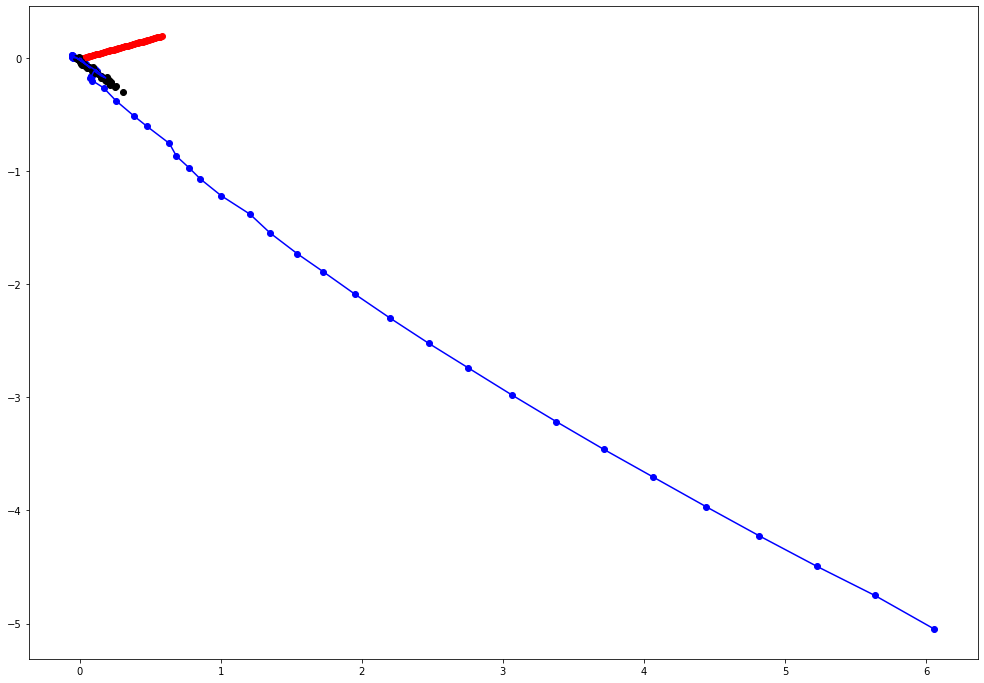

In [137]:
plt.figure(figsize=(17, 12))
plt.scatter(data[batch_i]['history_positions'][:54, 0], data[batch_i]['history_positions'][:54, 1], c='b')
plt.plot(data[batch_i]['history_positions'][:54, 0][::-1], 
            data[batch_i]['history_positions'][:54, 1][::-1], c='b')

plt.scatter(future_coords_offsets[0][:, 0], future_coords_offsets[0][:, 1], c='r')
plt.scatter(data[batch_i]['target_positions'][:54, 0], data[batch_i]['target_positions'][:54, 1], c='black')